# Analysis of minimal pairs and homophones


In [10]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
import statsmodels.formula.api as sm
import seaborn as sns
from tqdm import tqdm

import src.utils as utils

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

## Pipeline

Here, we define the general pipeline to analyze pre-processed lexicons (real and artificial).

In [3]:
NUM_ARTIFICIAL = 10

In [4]:
def get_stats_for_lexicon(df_lex):
    """Return basic stats about lexicon. Number of homophones, etc."""
    return {'homophone_percentage': round((len(df_lex[df_lex['num_homophones']>0]) / len(df_lex)), 4),
            'mean_homophones': round(df_lex['num_homophones'].mean(), 4),
            'max_homophones': round(df_lex['num_homophones'].max(), 2),
            'mean_mp': round(df_lex['neighborhood_size'].mean(), 4),
            'max_mp': round(df_lex['neighborhood_size'].max(), 2),
            'total_mp': round(df_lex['neighborhood_size'].sum(), 2),
            'mean_mp_w_hp': round(df_lex['neighborhood_size_with_homophones'].mean(), 4),
            'max_mp_w_hp': round(df_lex['neighborhood_size_with_homophones'].max(), 2),
            'total_mp_w_hp': round(df_lex['neighborhood_size_with_homophones'].sum(), 2)}

In [5]:
def process_and_extract_artificials(df_artificials, N=10):
    """Extract each artificial lexicon from aggregated dataframe.
    
    Also returns information about homophony distribution and minimal pair distribution.
    """
    processed_artificials = []
    homophone_percentages = []
    mean_homophones, max_homophones = [], []
    mean_mp, max_mp, total_mp = [], [], []
    # Neighborhood size with homophones
    mean_mp_hp, max_mp_hp, total_mp_hp = [], [], []
    for i in tqdm(range(N)):

        df_tmp = df_artificials[df_artificials['lexicon']==i]

        df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                          phon_column="word", word_column="word")
        
        lex_stats = get_stats_for_lexicon(df_tmp_processed)

        homophone_percentages.append(lex_stats['homophone_percentage'])
        mean_homophones.append(lex_stats['mean_homophones'])
        max_homophones.append(lex_stats['max_homophones'])
        mean_mp.append(lex_stats['mean_mp'])
        max_mp.append(lex_stats['max_mp'])
        total_mp.append(lex_stats['total_mp'])
        mean_mp_hp.append(lex_stats['mean_mp_w_hp'])
        max_mp_hp.append(lex_stats['max_mp_w_hp'])
        total_mp_hp.append(lex_stats['total_mp_w_hp'])
                
        processed_artificials.append(df_tmp_processed)
    
    return {'processed_dataframes': processed_artificials,
            'homophone_percentages': homophone_percentages,
            'mean_homophones': mean_homophones,
            'max_homophones': max_homophones,
            'mean_mp': mean_mp,
            'max_mp': max_mp,
            'total_mp': total_mp,
            'mean_mp_w_hp': mean_mp_hp,
            'max_mp_w_hp': max_mp_hp,
            'total_mp_w_hp': total_mp_hp
           }
    

In [51]:
def plot_real_vs_art(art_dist, real_value, statistic, language, ylabel="Count"):
    """Compare distribution of test statistics from artificial lexicon to real lexicon."""
    
    print("Mean of artificial: {x}.".format(x=statistics.mean(art_dist)))
    print("Median of artificial: {x}.".format(x=statistics.median(art_dist)))
    print("Standard deviation of artificial: {x}.".format(x=statistics.stdev(art_dist)))
    print("Range of artificial: ({x}, {y}).".format(x=min(art_dist), y=max(art_dist)))
    print("Real value: {x}.".format(x=real_value))
    
    plt.hist(art_dist)
    plt.title("{lan}: {x} (real vs. artificial)".format(lan=language, x=statistic))
    plt.xlabel(statistic)
    plt.ylabel(ylabel)
    plt.axvline(x=real_value, linestyle="dotted", color="red")
    # plt.axvline(x=0, linestyle="dashed", color="blue")

In [7]:
def load_lexicons_for_language(language, phon_column="PhonDISC", word_column="Word"):
    """Loads lexicons for a given language."""
    df_real = pd.read_csv("data/processed/{lan1}/minimal_pairs/{lan2}_all_mps.csv".format(lan1=language,
                                                                                         lan2=language))
    df_real_processed = utils.preprocess_for_analysis(df_real, word_column=word_column, phon_column=phon_column)
    df_artificials = pd.read_csv("data/processed/{lan1}/minimal_pairs/{lan2}_artificial_10_matched_on_sylls_mps_no_restriction.csv".format(lan1=language,
                                                                                                                           lan2=language))
    return df_real, df_real_processed, df_artificials
    

In [8]:
def analyze_stats(df_og, list_of_artificials, formula, covariates):
    """Analyze stats for real vs artificial dataframes."""
    result_real = sm.poisson(formula=formula, 
                data=df_og).fit(disp=0)
    
    params = result_real.params
    params['real'] = "Yes"
    real_r2 = result_real.prsquared
    params['pr2'] = real_r2
    
    coefs = []
    coefs.append(params)
    
    for df_art in list_of_artificials:
        result_fake = sm.poisson(formula=formula, 
                data=df_art).fit(disp=0)
        fake_r2 = result_fake.prsquared
        params = result_fake.params
        params['real'] = "No"
        params['pr2'] = fake_r2
        coefs.append(params)
    
    return pd.DataFrame(coefs)

In [9]:
def process_stats(df_real, list_of_fakes, formula, covariates, covariate_labels, language):
    """Pipeline for processing and plotting stats results."""
    df_stats = analyze_stats(df_real, list_of_fakes, formula=formula, covariates=covariates)
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    for index, cov in enumerate(COVARIATES):
        ax = fig.add_subplot(len(COVARIATES)+1, 1, index+1)

        real_value = df_stats[df_stats['real']=="Yes"][cov].values[0]
        art_values = df_stats[df_stats['real']=="No"][cov].values

        ax.hist(art_values)
        ax.axvline(x=real_value, linestyle="dotted", color="red")
        ax.axvline(x=0, linestyle="dashed")
        ax.text(s="Real coef: {sl}".format(sl=round(real_value, 2)),x=real_value, y =1)

        plt.title("{lan}: coefficient for {cov}".format(lan=LANGUAGE, cov=COVARIATE_LABELS[index]))


    # Now add pr2
    ax = fig.add_subplot(len(COVARIATES)+1, 1, index+2)
    real_value = df_stats[df_stats['real']=="Yes"]['pr2'].values[0]
    art_values = df_stats[df_stats['real']=="No"]['pr2'].values
    ax.hist(art_values)
    ax.axvline(x=real_value, linestyle="dotted", color="red")
    ax.axvline(x=0, linestyle="dashed")
    ax.text(s="Real R^2: {sl}".format(sl=round(real_value, 2)),x=real_value, y =1)
    plt.title("{lan}: Pseudo R^2".format(lan=LANGUAGE, cov=COVARIATE_LABELS[index]))
    
    fig.subplots_adjust(hspace=.5)
    
    target = formula.split(" ~")[0]
    regressors = ' '.join(covariates)
    plt.savefig("Figures/{l1}/{l2}_stats_{target}_{regressors}.png".format(l1=language,
                                                                           l2=language,
                                                                           target=target,
                                                                           regressors=regressors), 
                dpi=300)
    
    # Now save individual versions

    ### Set up directories
    if not os.path.exists("Figures/{lan}/individual_plots".format(lan=language)):
        print("Figures/{lan}/individual_plots".format(lan=language))
        os.mkdir("Figures/{lan}/individual_plots".format(lan=language))
    for index, cov in enumerate(COVARIATES):
        fig = plt.figure()
        fig.set_figwidth(9)
        real_value = df_stats[df_stats['real']=="Yes"][cov].values[0]
        art_values = df_stats[df_stats['real']=="No"][cov].values

        plt.hist(art_values)
        plt.axvline(x=real_value, linestyle="dotted", color="red")
        plt.axvline(x=0, linestyle="dashed")
        plt.text(s="Real coef: {sl}".format(sl=round(real_value, 2)),x=real_value, y =1)

        plt.title("{lan}: coefficient for {cov}".format(lan=LANGUAGE, cov=COVARIATE_LABELS[index]))
        if not os.path.exists("Figures/{lan}/individual_plots/{cov}".format(lan=language, cov=cov)):
            print("Figures/{lan}/individual_plots/{cov}".format(lan=language, cov=cov))
            os.mkdir("Figures/{lan}/individual_plots/{cov}".format(lan=language, cov=cov))
        plt.savefig("Figures/{l1}/individual_plots/{cov1}/{l2}_{target}_{cov2}_{regressors}.png".format(l1=language,
                                                                                                       cov1=cov,
                                                                                   l2=language,
                                                                                   target=target,
                                                                                   cov2=cov,
                                                                                   regressors=regressors), 
                    dpi=300)
        plt.close(fig)
    
    # Now do pr2
    fig = plt.figure()
    fig.set_figwidth(9)
    real_value = df_stats[df_stats['real']=="Yes"]['pr2'].values[0]
    art_values = df_stats[df_stats['real']=="No"]['pr2'].values

    plt.hist(art_values)
    plt.axvline(x=real_value, linestyle="dotted", color="red")
    plt.axvline(x=0, linestyle="dashed")
    plt.text(s="Real R^2: {sl}".format(sl=round(real_value, 2)),x=real_value, y =1)

    plt.title("{lan}: Pseudo R^2".format(lan=LANGUAGE, cov=COVARIATE_LABELS[index]))

    plt.savefig("Figures/{l1}/individual_plots/{l2}_{target}_r2_{regressors}.png".format(l1=language,
                                                                               l2=language,
                                                                               target=target,
                                                                               cov=cov,
                                                                               regressors=regressors), 
                dpi=300)
    plt.close(fig)

## Predictions

In each case, we'll be comparing some test statistic (max # homophones per word, coefficient for *surprisal*, etc.) across the real and the artificial lexica. The critical question is whether the test statistic in the real lexicon exceeds (in the expected direction) the distribution of values from the artificial lexica.

Here's a couple of examples below.

In [12]:
np.random.seed(42)

In [13]:
real_value = -.8

Mean of artificial: -0.49551938888301245.
Median of artificial: -0.494803629017014.
Median of artificial: 0.007230083334490977.
Real value: -0.8.


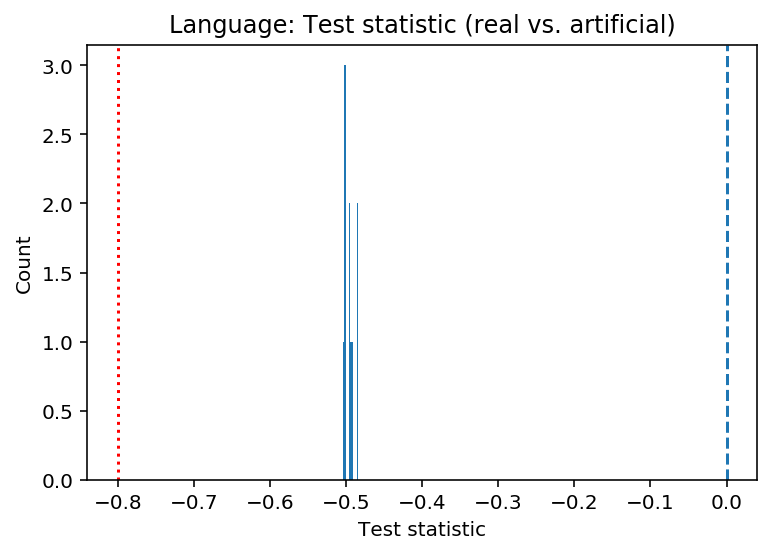

In [14]:
# Here's what it should look like if the real lexica explains *more* variance.
art_dist = np.random.normal(loc=-.5, scale=.01, size=10)
plot_real_vs_art(art_dist, real_value, "Test statistic", "Language" )
plt.axvline(0, linestyle="dashed")
plt.savefig("Figures/predictions/stats/real_wins.png", dpi=300)

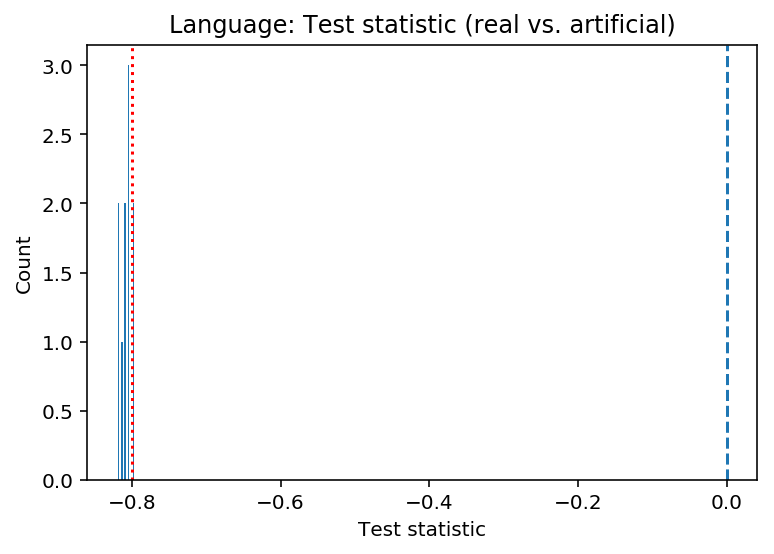

In [13]:
# Here's what it should look like if the real lexica falls squarely in the middle of the artificial distribution.
art_dist = np.random.normal(loc=-.8, scale=.01, size=10)
plot_real_vs_art(art_dist, real_value, "Test statistic", "Language" )
plt.axvline(0, linestyle="dashed")

plt.savefig("Figures/predictions/stats/real_same.png", dpi=300)

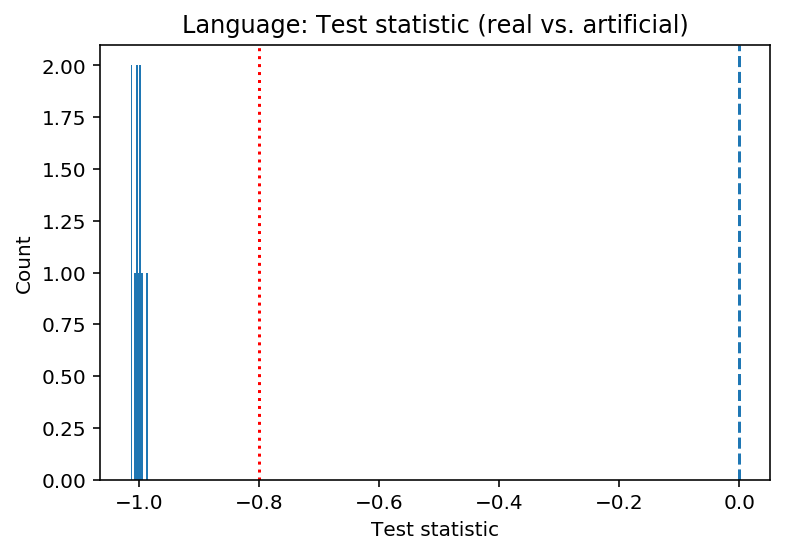

In [14]:
# And here's what it would look like if the real lexica is actually *less* efficient.
art_dist = np.random.normal(loc=-1, scale=.01, size=10)
plot_real_vs_art(art_dist, real_value, "Test statistic", "Language" )
plt.axvline(0, linestyle="dashed")

plt.savefig("Figures/predictions/stats/real_loses.png", dpi=300)

In [15]:
real_value = 20

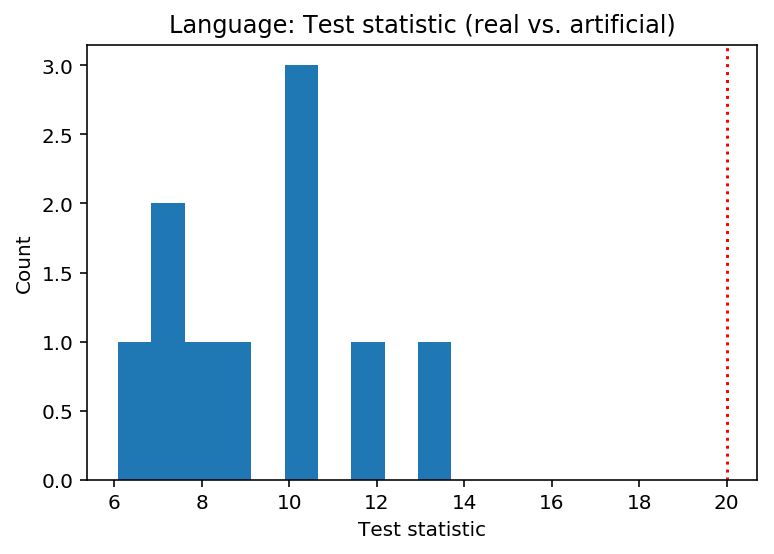

In [16]:
# Here's what it should look like if the real lexica explains *more* variance.
art_dist = np.random.normal(loc=10, scale=2, size=10)
plot_real_vs_art(art_dist, real_value, "Test statistic", "Language" )
# plt.axvline(0, linestyle="dashed")

plt.savefig("Figures/predictions/descriptive/real_wins.png", dpi=300)

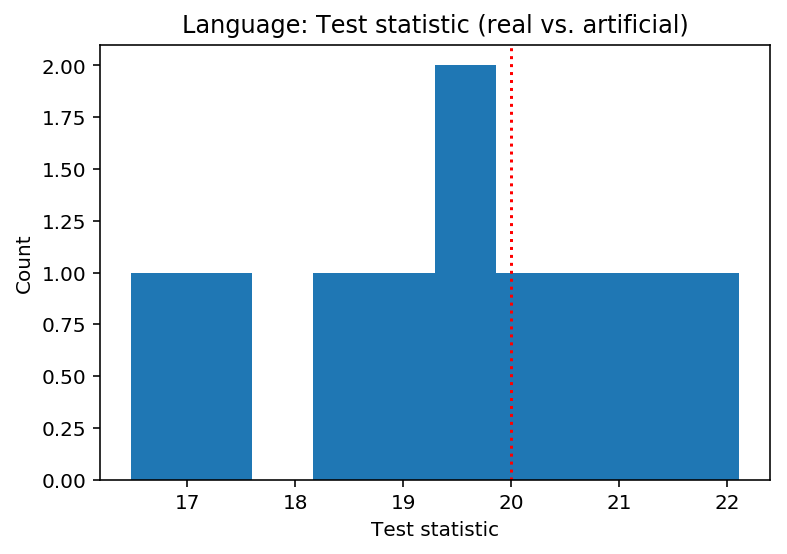

In [17]:
# Here's what it should look like if the real lexica falls squarely in the middle of the artificial distribution.
art_dist = np.random.normal(loc=20, scale=2, size=10)
plot_real_vs_art(art_dist, real_value, "Test statistic", "Language" )
# plt.axvline(0, linestyle="dashed")

plt.savefig("Figures/predictions/descriptive/real_same.png", dpi=300)

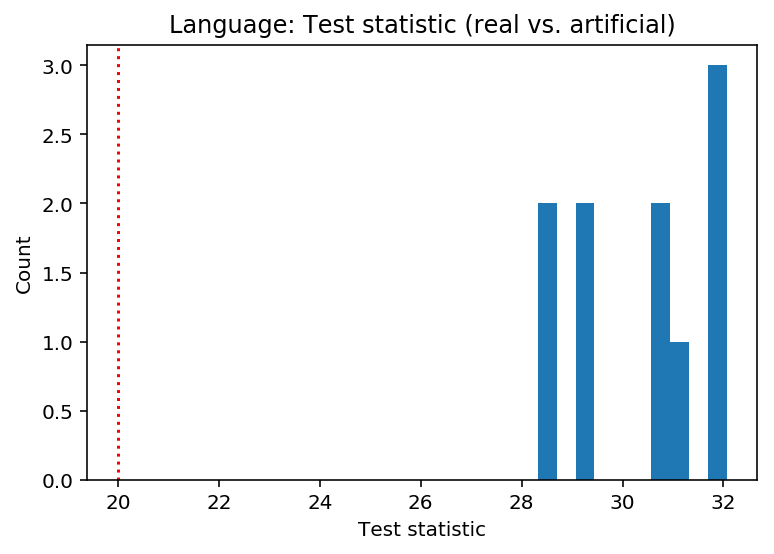

In [18]:
# And here's what it would look like if the real lexica is actually *less* efficient.
art_dist = np.random.normal(loc=30, scale=2, size=10)
plot_real_vs_art(art_dist, real_value, "Test statistic", "Language" )
# plt.axvline(0, linestyle="dashed")

plt.savefig("Figures/predictions/descriptive/real_loses.png", dpi=300)

## English

In [15]:
df_celex, df_celex_processed, df_english_artificials = load_lexicons_for_language("english")

/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)


In [16]:
len(df_celex)

52438

In [17]:
len(df_celex_processed)

35107

In [18]:
df_english_stats = get_stats_for_lexicon(df_celex_processed)

### Preprocess artificials

In [19]:
info_for_english = process_and_extract_artificials(df_english_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


In [20]:
processed_artificials = info_for_english['processed_dataframes']

#### Norm surprisal

In [21]:
df_celex_processed['surprisal_normed'] = df_celex_processed['surprisal'] / df_celex_processed['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

### Visualizations

In [21]:
artificials = []
for df_tmp_processed in tqdm(processed_artificials):

    df_tmp_processed['surprisal_binned'] = pd.cut(df_tmp_processed['surprisal'], bins=20, labels=range(1, 21))
    df_agg_art = utils.agg_homophones_by_syllable(df_tmp_processed, 
                                              syl_column='surprisal_binned', 
                                              homophone_column='num_homophones')
    artificials.append(df_agg_art)

    
df_celex_processed['surprisal_binned'] = pd.cut(df_celex_processed['surprisal'], bins=20, labels=range(1, 21))
df_agg_real = utils.agg_homophones_by_syllable(df_celex_processed, 
                                      syl_column='surprisal_binned', 
                                      homophone_column='num_homophones')
df_artificials = pd.concat(artificials)

100%|██████████| 10/10 [00:01<00:00,  7.14it/s]


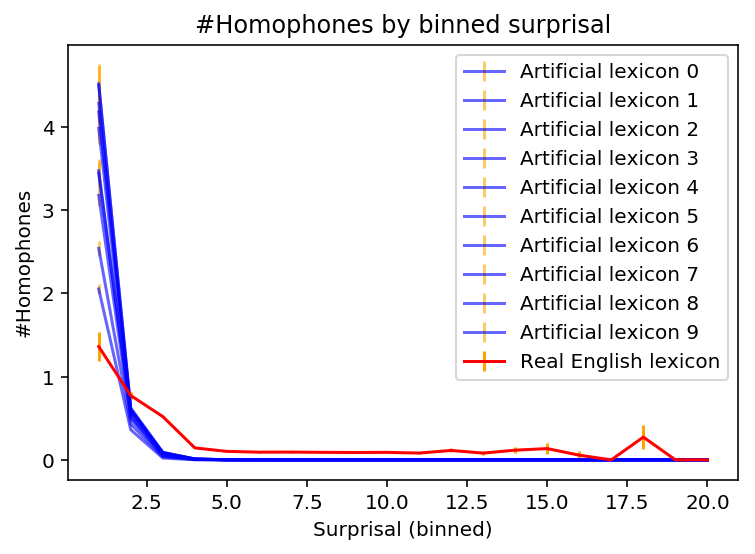

In [22]:
plt.title("#Homophones by binned surprisal")
plt.xlabel("Surprisal (binned)")
plt.ylabel("#Homophones")

for i, df in enumerate(artificials):
    
    plt.errorbar(df['num_sylls'], df['mean_homophones'], alpha = .6,
                        yerr=df['sem_homophones'], color = "blue", ecolor="orange",
                label = "Artificial lexicon {x}".format(x=i))

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real English lexicon")
plt.legend(loc='upper right')

plt.savefig("Figures/english/data_visualizations/surprisal_homophones.png", dpi=300)

In [201]:
artificials = []
for df_tmp_processed in tqdm(processed_artificials):

    df_agg_art = utils.agg_homophones_by_syllable(df_tmp_processed, 
                                              syl_column='num_sylls_est', 
                                              homophone_column='num_homophones')
    artificials.append(df_agg_art)

df_artificials = pd.concat(artificials)

df_agg_real = utils.agg_homophones_by_syllable(df_celex_processed, 
                                          syl_column='num_sylls_est', 
                                          homophone_column='num_homophones')

  0%|          | 0/10 [00:00<?, ?it/s]/Users/seantrott/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/seantrott/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


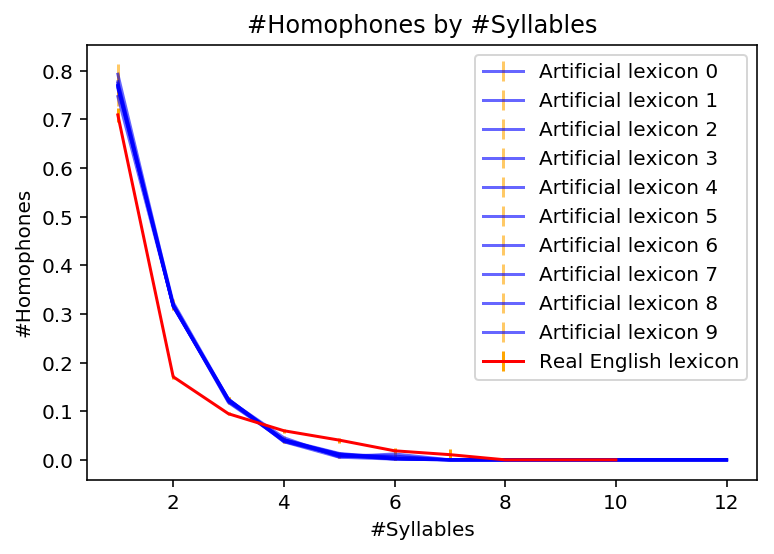

In [203]:
plt.title("#Homophones by #Syllables")
plt.xlabel("#Syllables")
plt.ylabel("#Homophones")

for i, df in enumerate(artificials):
    
    plt.errorbar(df['num_sylls'], df['mean_homophones'], alpha = .6,
                        yerr=df['sem_homophones'], color = "blue", ecolor="orange",
                label = "Artificial lexicon {x}".format(x=i))

plt.errorbar(df_agg_real['num_sylls'], df_agg_real['mean_homophones'], 
                    yerr=df_agg_real['sem_homophones'], color="red", ecolor="orange",
            label = "Real English lexicon")
plt.legend(loc='upper right')

plt.savefig("Figures/english/data_visualizations/syllables_homophones.png", dpi=300)

### `#homophones` ~ `rank_homophones`

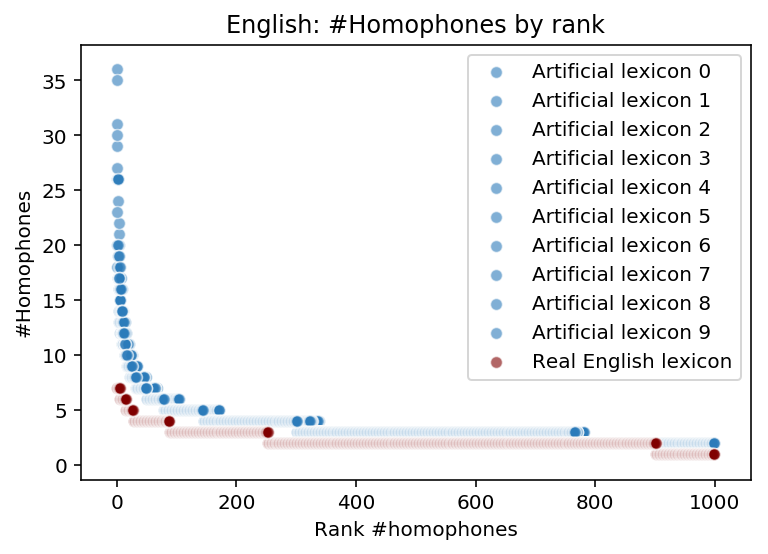

In [24]:
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    sns.scatterplot(data = df_tmp_art[df_tmp_art['rank_num']<1000],
                    x = "rank_num",
                    alpha = .6,
                    y = "num_homophones", 
                    color = sns.color_palette("Blues")[4], 
                    label = "Artificial lexicon {x}".format(x=index))

df_celex_processed['rank_num'] = df_celex_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "num_homophones", 
                color = "maroon",
                alpha = .6,
                label = "Real English lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("English: #Homophones by rank")

plt.savefig("Figures/english/data_visualizations/rank_homophones.png", dpi=300)

### `#minimal pairs` ~ `rank_minimal_pairs`

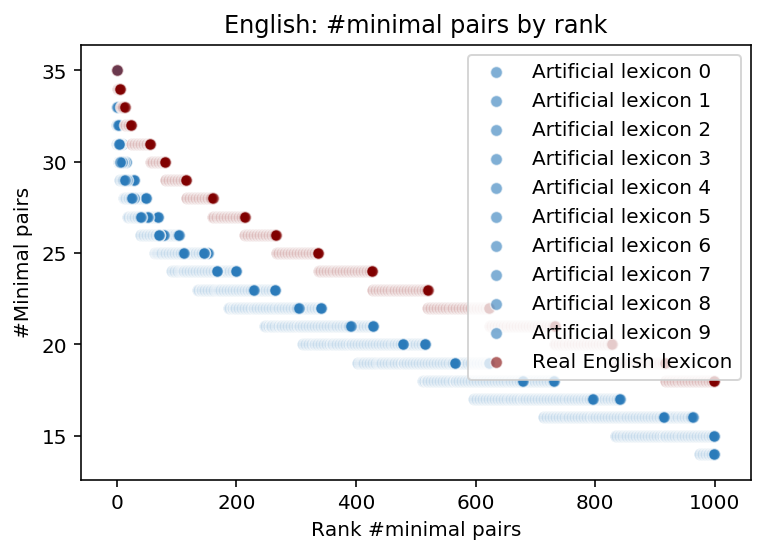

In [25]:
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_neighborhood'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    sns.scatterplot(data = df_tmp_art[df_tmp_art['rank_neighborhood']<1000],
                    x = "rank_neighborhood",
                    alpha = .6,
                    y = "neighborhood_size", 
                    color = sns.color_palette("Blues")[4], 
                    label = "Artificial lexicon {x}".format(x=index))

df_celex_processed['rank_neighborhood'] = df_celex_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_neighborhood']<1000],
               x = "rank_neighborhood",
               y = "neighborhood_size", 
                color = "maroon",
                alpha = .6,
                label = "Real English lexicon")
plt.xlabel("Rank #minimal pairs")
plt.ylabel("#Minimal pairs")
plt.title("English: #minimal pairs by rank")

plt.savefig("Figures/english/data_visualizations/rank_neighborhoods.png", dpi=300)

### Comparing neighborhood distributions (Dautriche et al, 2016)

As reported by Dautriche et al (2016), there are more minimal pairs in the real lexicon than in the artificial English lexicons, whether or not homophones are included. The same goes for the **mean** neighborhood size per word.

There are also larger **max** neighborhoods in English, but only when not counting homophones in neighborhood size. When homophones are included, the artificial lexicons have larger neighborhoods––presumably because there are much larger numbers of homophones per wordform in the artificial lexicons.

Mean of artificial: 1.60575.
Median of artificial: 1.60545.
Standard deviation of artificial: 0.017614214588097768.
Range of artificial: (1.5751, 1.6313).
Real value: 1.9914.


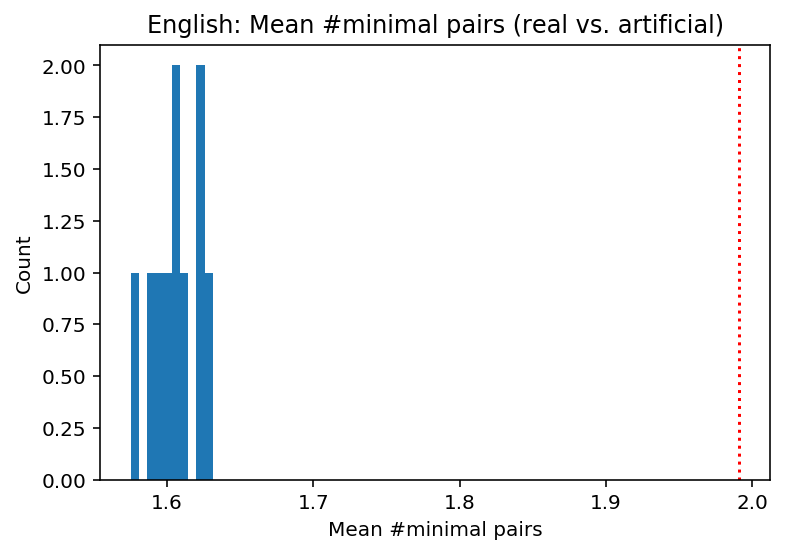

In [52]:
plot_real_vs_art(info_for_english['mean_mp'], df_english_stats['mean_mp'],
                'Mean #minimal pairs', language="English")

Mean of artificial: 2.79294.
Median of artificial: 2.7876000000000003.
Standard deviation of artificial: 0.022333741289806253.
Range of artificial: (2.7622, 2.8383).
Real value: 3.403.


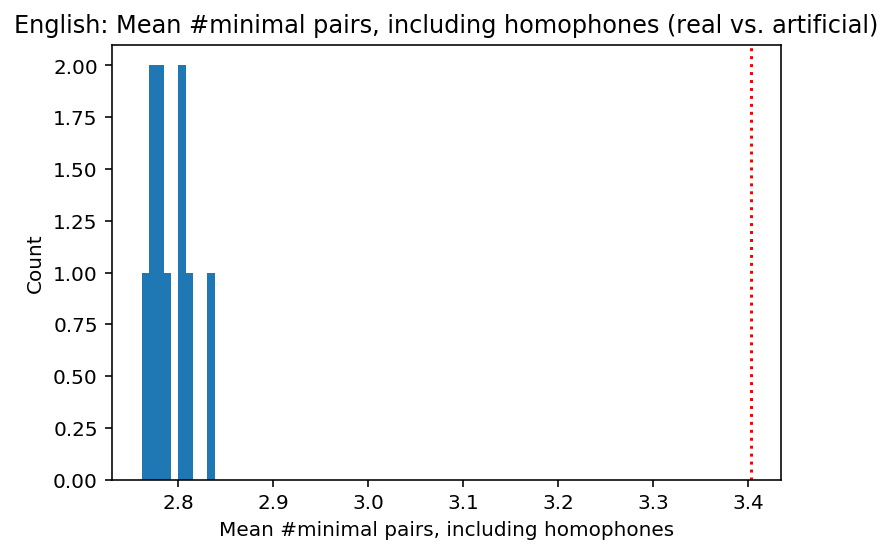

In [53]:
plot_real_vs_art(info_for_english['mean_mp_w_hp'], df_english_stats['mean_mp_w_hp'],
                'Mean #minimal pairs, including homophones', language="English")

Mean of artificial: 32.
Median of artificial: 33.0.
Standard deviation of artificial: 1.0.
Range of artificial: (31, 35).
Real value: 35.


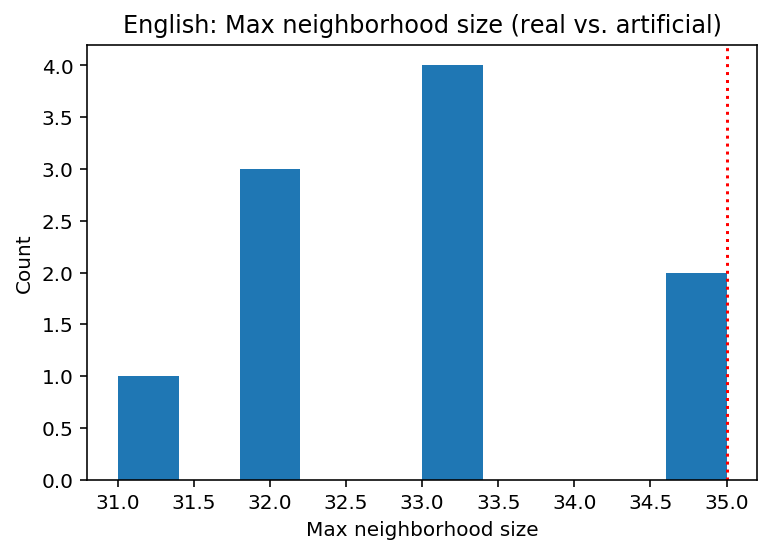

In [54]:
plot_real_vs_art(info_for_english['max_mp'], df_english_stats['max_mp'],
                'Max neighborhood size', language="English")

Mean of artificial: 91.
Median of artificial: 92.0.
Standard deviation of artificial: 8.246211251235321.
Range of artificial: (77, 103).
Real value: 98.


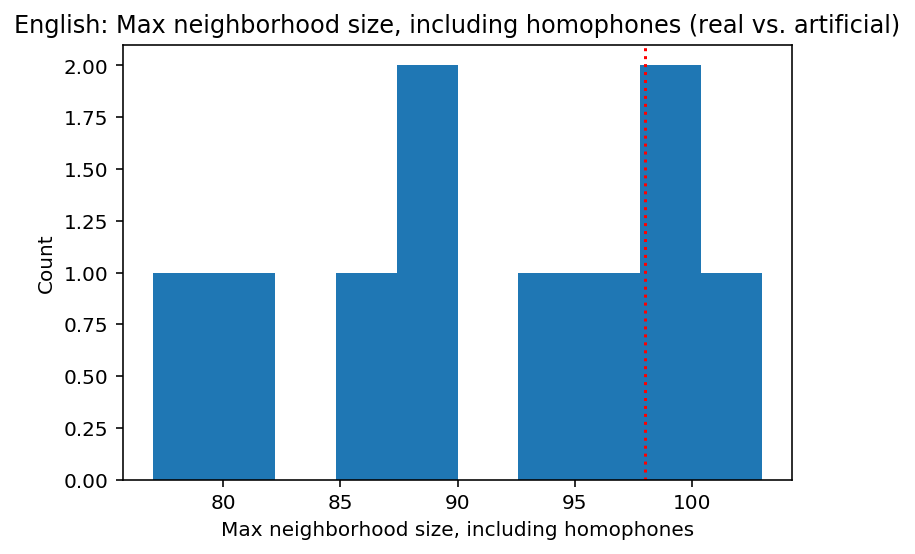

In [55]:
plot_real_vs_art(info_for_english['max_mp_w_hp'], df_english_stats['max_mp_w_hp'],
                'Max neighborhood size, including homophones', language="English")

Mean of artificial: 68153.
Median of artificial: 68153.0.
Standard deviation of artificial: 771.2703806059195.
Range of artificial: (66744, 69340).
Real value: 69911.


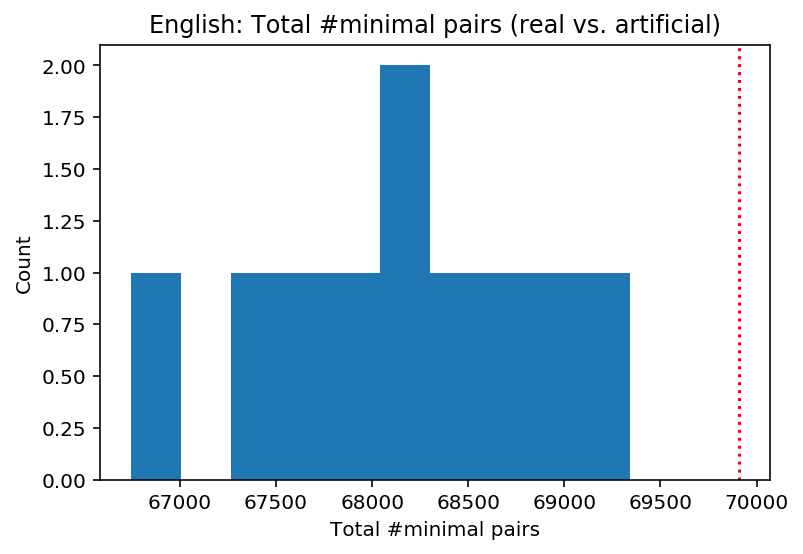

In [56]:
plot_real_vs_art(info_for_english['total_mp'], df_english_stats['total_mp'],
                'Total #minimal pairs', language='English')

Mean of artificial: 118540.
Median of artificial: 118412.5.
Standard deviation of artificial: 953.6141777469544.
Range of artificial: (117297, 120451).
Real value: 119469.


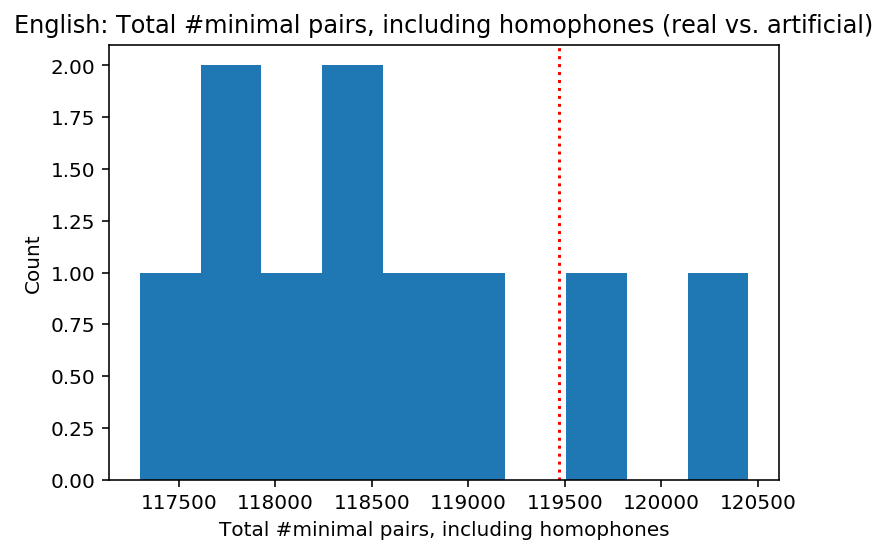

In [57]:
plot_real_vs_art(info_for_english['total_mp_w_hp'], df_english_stats['total_mp_w_hp'],
                'Total #minimal pairs, including homophones', language='English')

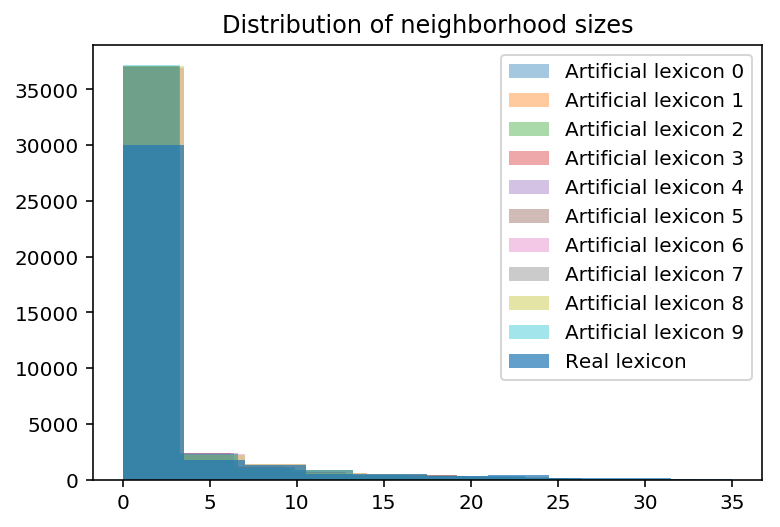

In [58]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size'], 
          alpha = .7, label = "Real lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

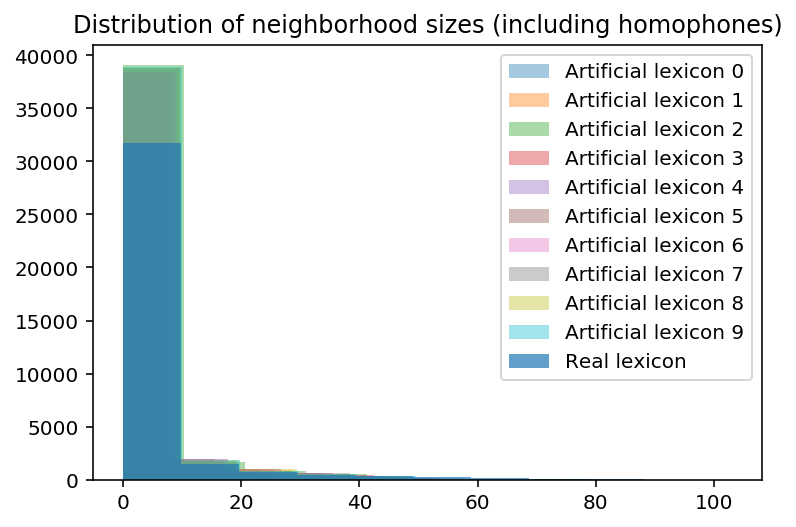

In [59]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size_with_homophones'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size_with_homophones'], 
          alpha = .7, label = "Real lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes (including homophones)")
plt.legend()

### Comparing homophone distributions

See also: https://github.com/seantrott/homophone_simulations/blob/master/using_null_lexicons.ipynb

When it comes to **homophones**, however, the artificial lexicons have a higher number of *maximum* homophones per word (upwards of 80, in some cases) than the real lexicon (below 10). There is also a higher number of *mean* homophones per word.

On the other hand, the real English lexicon has a higher proportion of homophonous wordforms overall.

Mean of artificial: 0.15009.
Median of artificial: 0.1502.
Standard deviation of artificial: 0.0007324995259763337.
Range of artificial: (0.1488, 0.151).
Real value: 0.1564.


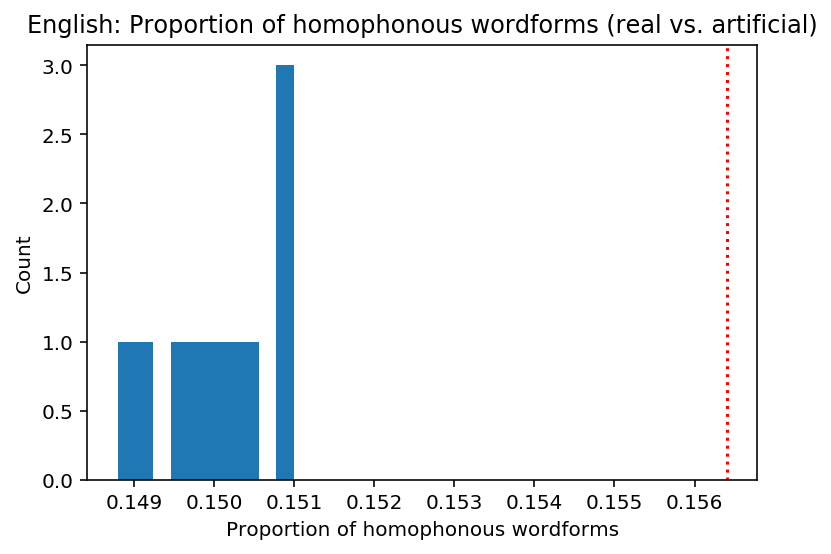

In [60]:
plot_real_vs_art(info_for_english['homophone_percentages'], df_english_stats['homophone_percentage'],
                'Proportion of homophonous wordforms', language='English')
plt.savefig("Figures/english/english_percent_homophones.png", dpi=300)

Mean of artificial: 0.2355.
Median of artificial: 0.2355.
Standard deviation of artificial: 0.0013029880190461337.
Range of artificial: (0.2335, 0.2375).
Real value: 0.1931.


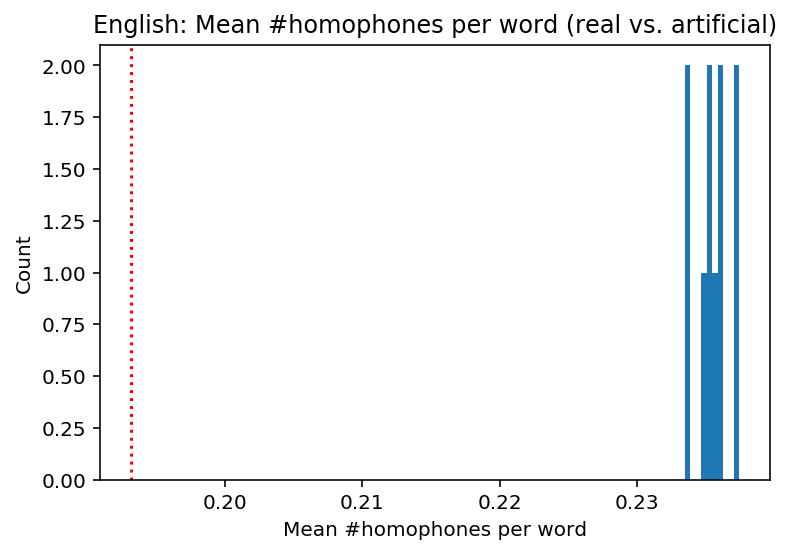

In [61]:
plot_real_vs_art(info_for_english['mean_homophones'], df_english_stats['mean_homophones'],
                'Mean #homophones per word', language='English')
plt.savefig("Figures/english/english_mean_homophones.png", dpi=300)

Mean of artificial: 27.
Median of artificial: 28.0.
Standard deviation of artificial: 5.916079783099616.
Range of artificial: (18, 36).
Real value: 7.


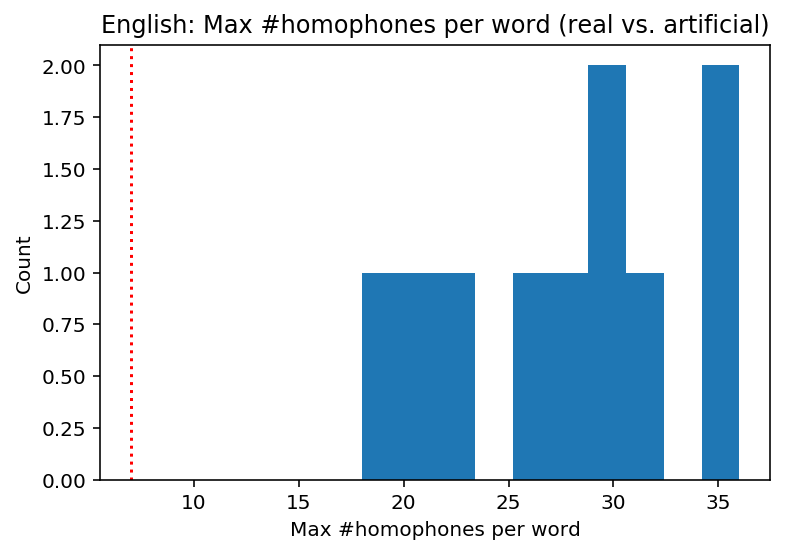

In [62]:
plot_real_vs_art(info_for_english['max_homophones'], df_english_stats['max_homophones'],
                'Max #homophones per word', language='English')
plt.savefig("Figures/english/english_max_homophones.png", dpi=300)

### Number of homophones and neighborhood size

Do larger neighborhoods have more homophones?

Here, we regress: 
```
#homophones ~ neighborhood size + #syllables + surprisal
```


Interestingly, we find the following effects:

- The effect of **surprisal** is larger in artificial lexicons than the real lexicon (as shown in our other analysis).
- The effect of **#syllables** is larger in artificial lexicons than the real lexicon. This is in contrast to the other analysis. The difference here is that we're also factoring in neighborhood size as a covariate.
- Finally, the effect of **neighborhood size** is larger in the *real* lexicon than artifical lexicons. 

#### Analysis

In [23]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
    # 'neighborhood_size'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#syllables', 
    # '#minimal pairs'
]
LANGUAGE = 'English'

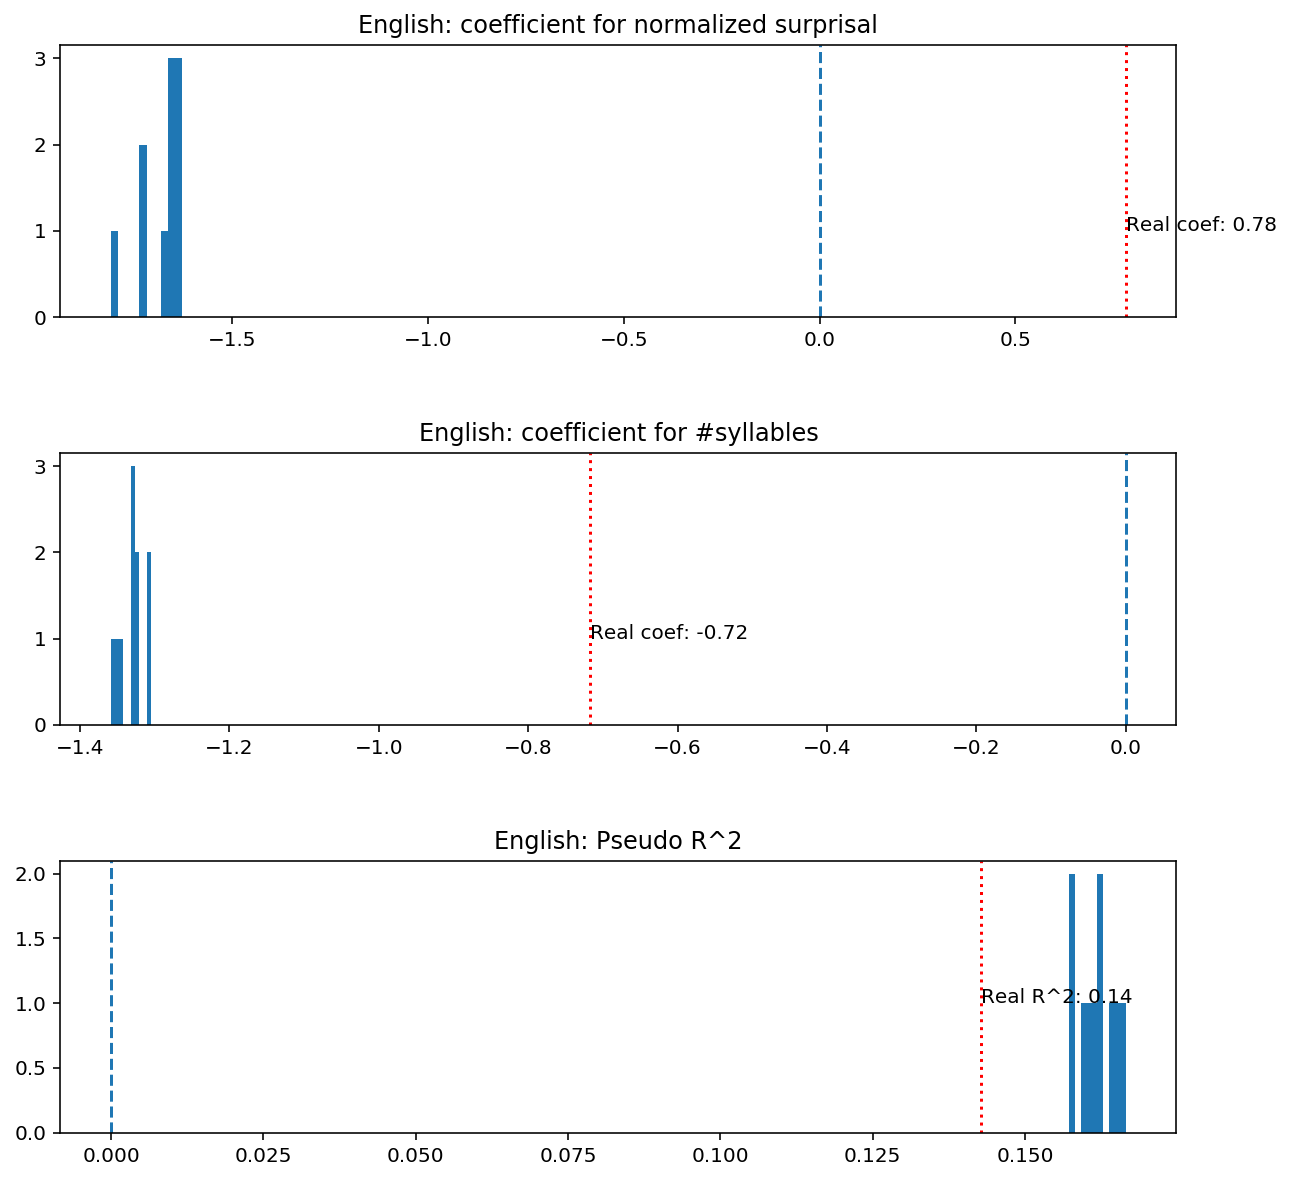

In [24]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

In [31]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
    'neighborhood_size'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#syllables', 
    '#minimal pairs'
]
LANGUAGE = 'English'

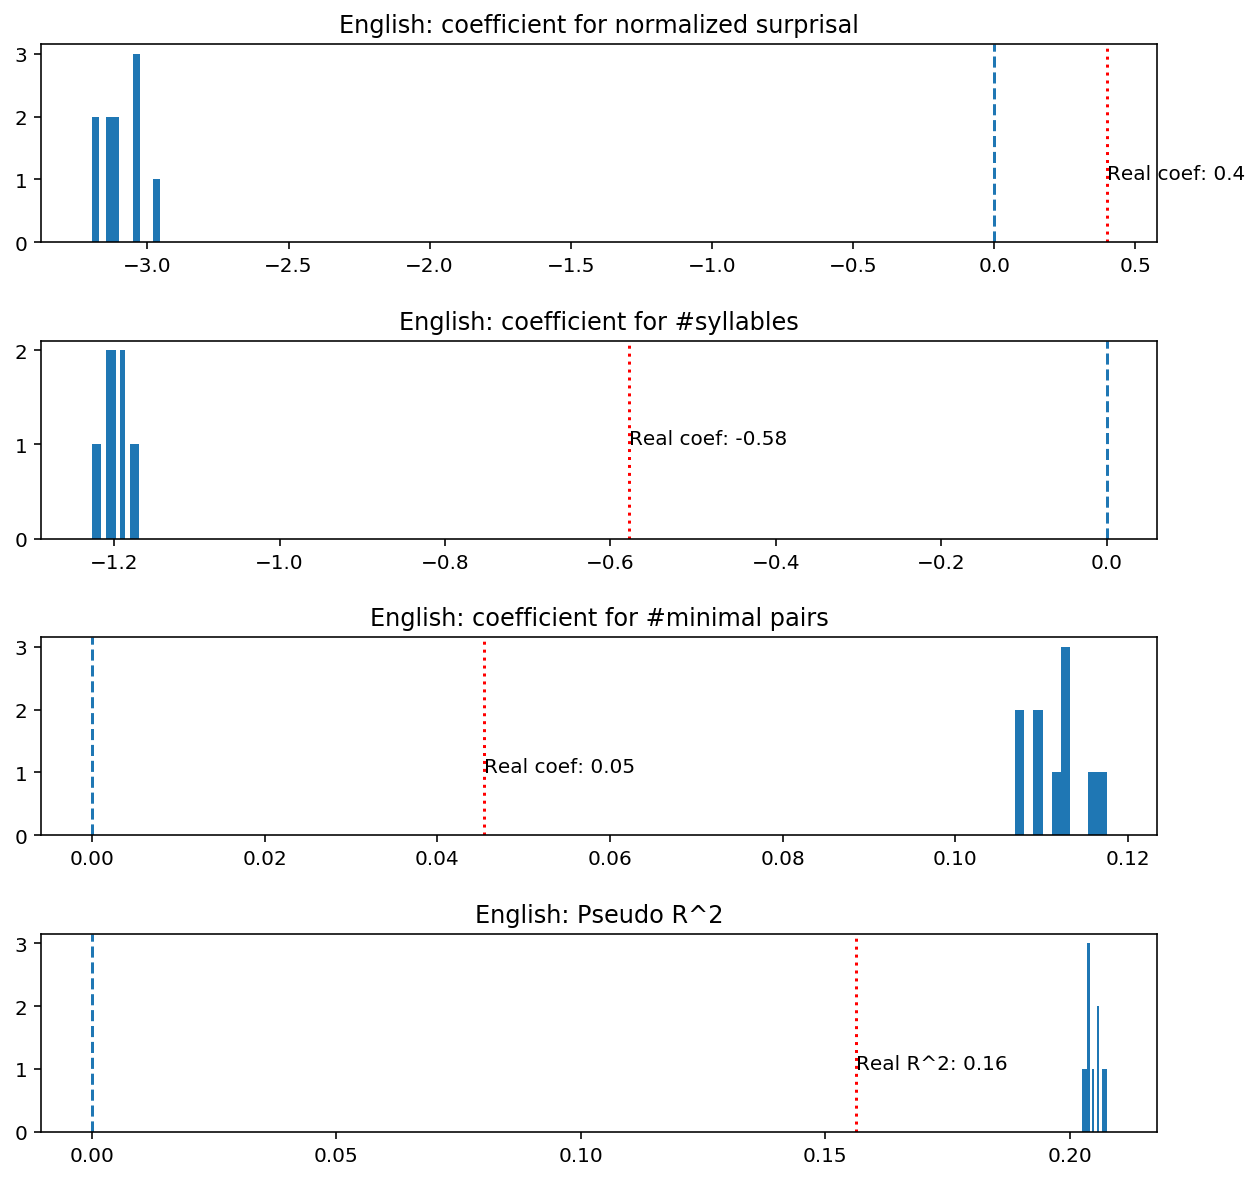

In [32]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

### Predicting *neighborhood size* from number of homophones

Do words with more homophones have larger neighborhoods?

(Here, we don't do the analysis for neighborhood estimates including homophones, because this results in a singular matrix.)

#### Analysis

In [34]:
TARGET = 'neighborhood_size'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalizd surprisal', 
    '#syllables', 
]
LANGUAGE = 'English'

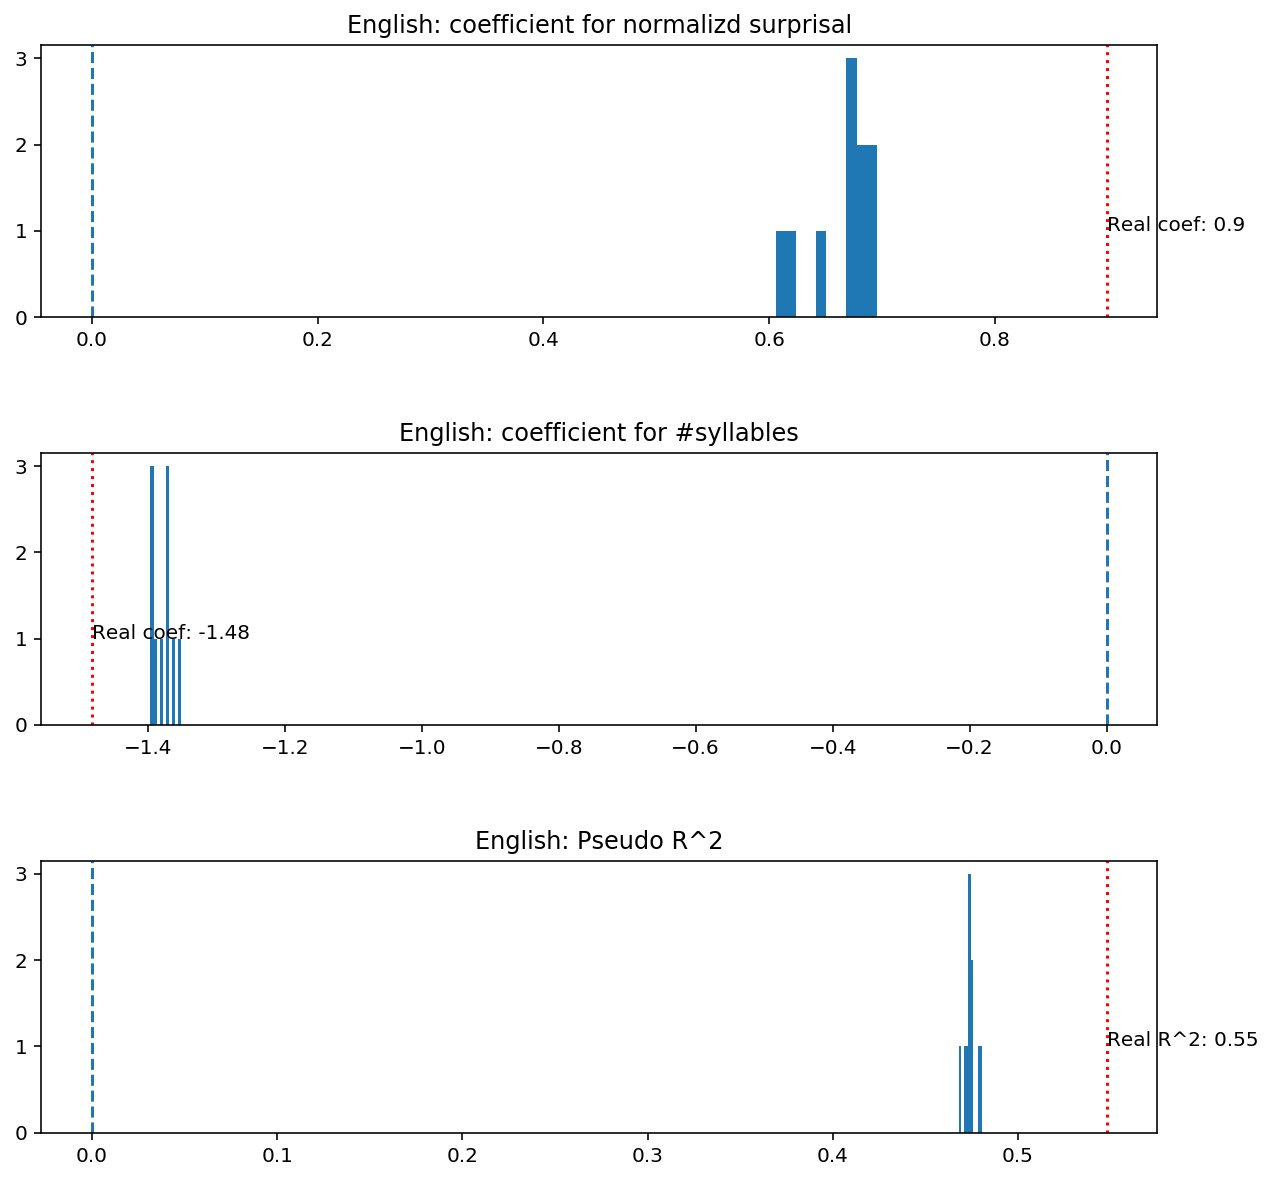

In [35]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

# German

In [36]:
df_celex, df_celex_processed, df_german_artificials = load_lexicons_for_language("german")

/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)


In [37]:
len(df_celex)

51719

In [38]:
len(df_celex_processed)

50474

In [39]:
df_german_stats = get_stats_for_lexicon(df_celex_processed)

### Preprocess artificials

In [40]:
info_for_german = process_and_extract_artificials(df_german_artificials)

100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


In [41]:
processed_artificials = info_for_german['processed_dataframes']

#### Norm surprisal

In [42]:
df_celex_processed['surprisal_normed'] = df_celex_processed['surprisal'] / df_celex_processed['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Visualizations

### `#homophones` ~ `rank_homophones`

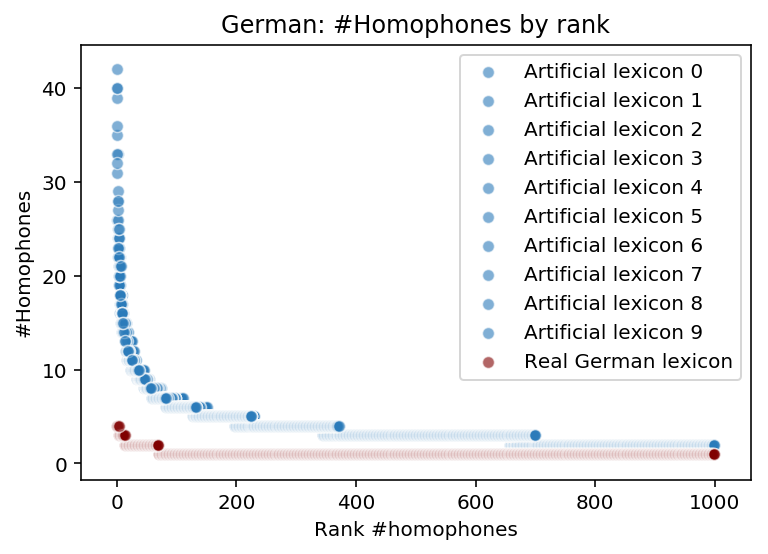

In [183]:
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    sns.scatterplot(data = df_tmp_art[df_tmp_art['rank_num']<1000],
                    x = "rank_num",
                    alpha = .6,
                    y = "num_homophones", 
                    color = sns.color_palette("Blues")[4], 
                    label = "Artificial lexicon {x}".format(x=index))

df_celex_processed['rank_num'] = df_celex_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "num_homophones", 
                color = "maroon",
                alpha = .6,
                label = "Real German lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("German: #Homophones by rank")

plt.savefig("Figures/german/data_visualizations/rank_homophones.png", dpi=300)

### `#minimal pairs` ~ `rank_minimal_pairs`

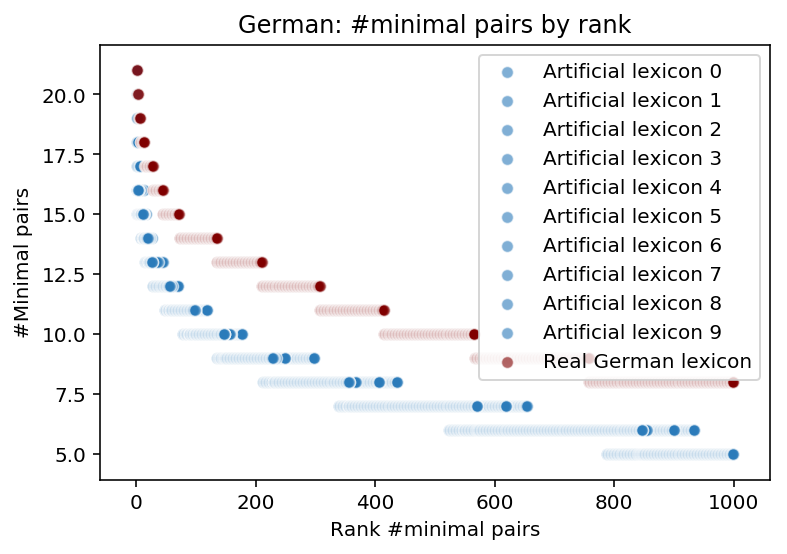

In [24]:
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_neighborhood'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    sns.scatterplot(data = df_tmp_art[df_tmp_art['rank_neighborhood']<1000],
                    x = "rank_neighborhood",
                    alpha = .6,
                    y = "neighborhood_size", 
                    color = sns.color_palette("Blues")[4], 
                    label = "Artificial lexicon {x}".format(x=index))

df_celex_processed['rank_neighborhood'] = df_celex_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_neighborhood']<1000],
               x = "rank_neighborhood",
               y = "neighborhood_size", 
                color = "maroon",
                alpha = .6,
                label = "Real German lexicon")
plt.xlabel("Rank #minimal pairs")
plt.ylabel("#Minimal pairs")
plt.title("German: #minimal pairs by rank")

plt.savefig("Figures/german/data_visualizations/rank_neighborhoods.png", dpi=300)

### Comparing neighborhood distributions (Dautriche et al, 2016)

As reported by Dautriche et al (2016), the real lexicon has higher average neighborhood sizes (and larger maximum neighborhoods) than the artificial lexicons.

Comparing the actual distributions, it seems like this is driven by the real lexicon having a longer, larger tail (consistent with the idea that there is a larger **maximum** neighborhood size in the real lexicon). 

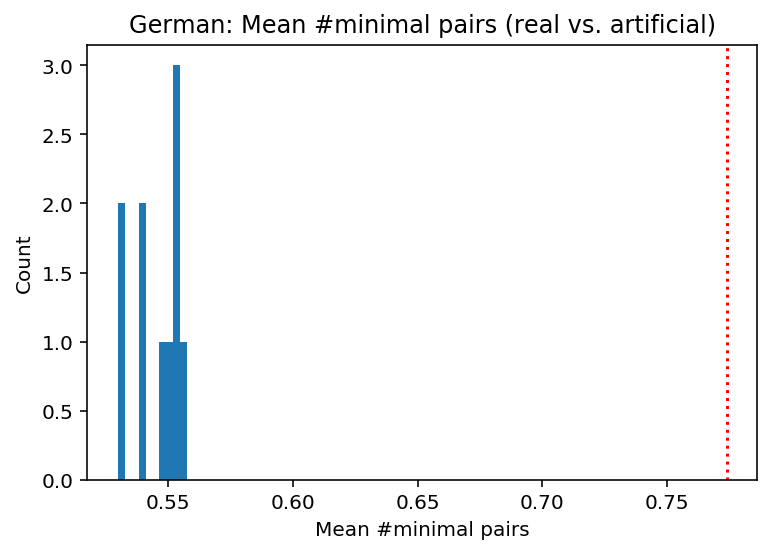

In [71]:
plot_real_vs_art(info_for_german['mean_mp'], df_german_stats['mean_mp'],
                'Mean #minimal pairs', language="German")

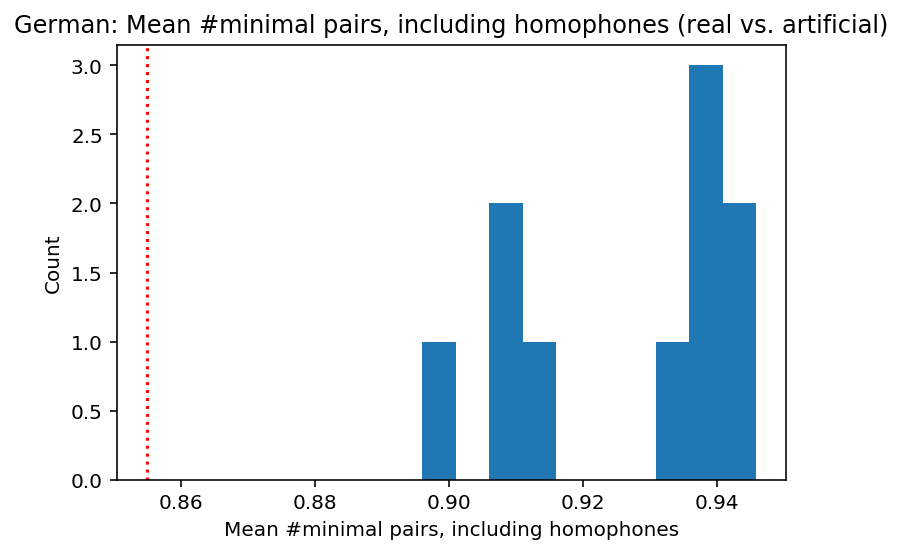

In [72]:
plot_real_vs_art(info_for_german['mean_mp_w_hp'], df_german_stats['mean_mp_w_hp'],
                'Mean #minimal pairs, including homophones', language="German")

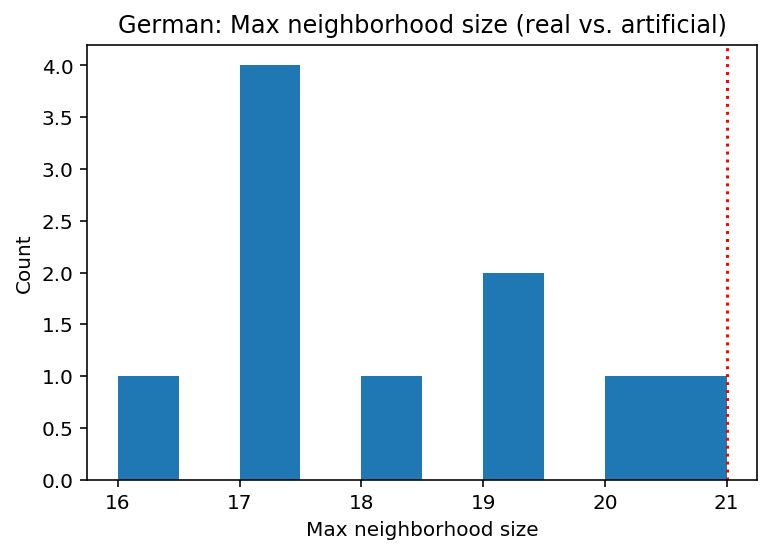

In [73]:
plot_real_vs_art(info_for_german['max_mp'], df_german_stats['max_mp'],
                'Max neighborhood size', language="German")

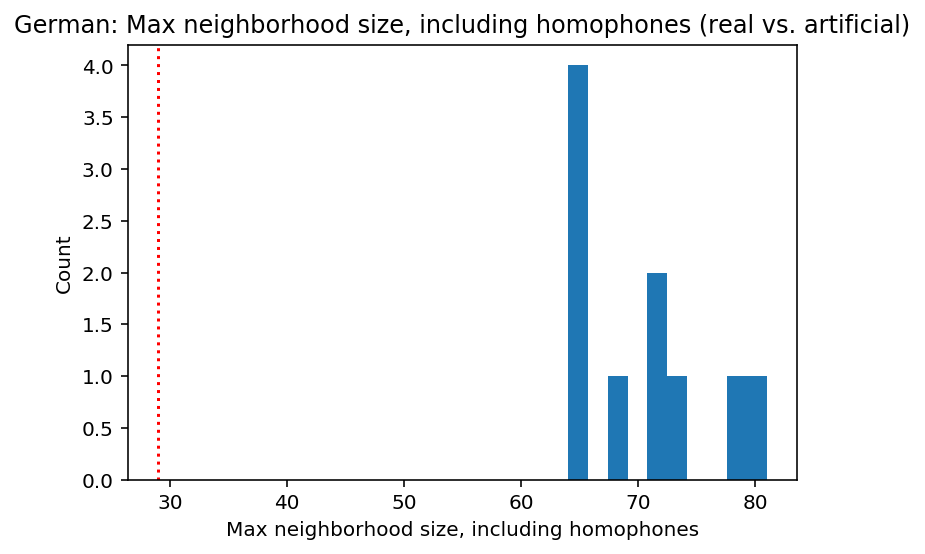

In [74]:
plot_real_vs_art(info_for_german['max_mp_w_hp'], df_german_stats['max_mp_w_hp'],
                'Max neighborhood size, including homophones', language="German")

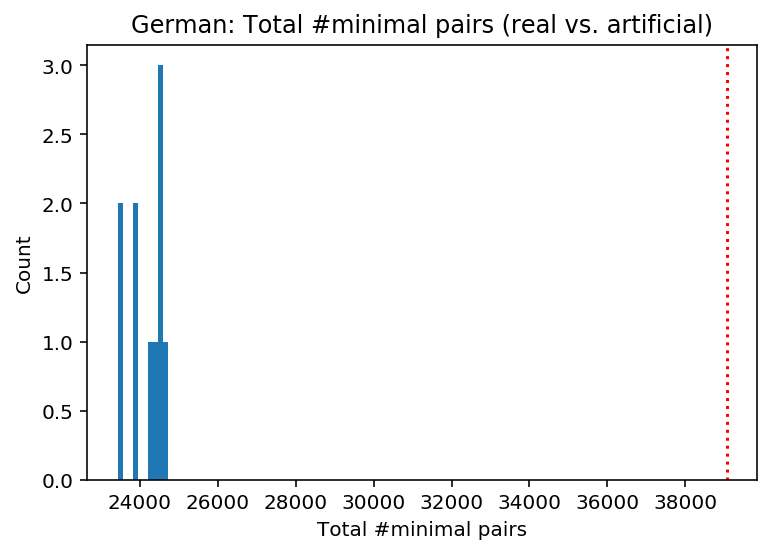

In [75]:
plot_real_vs_art(info_for_german['total_mp'], df_german_stats['total_mp'],
                'Total #minimal pairs', language='German')

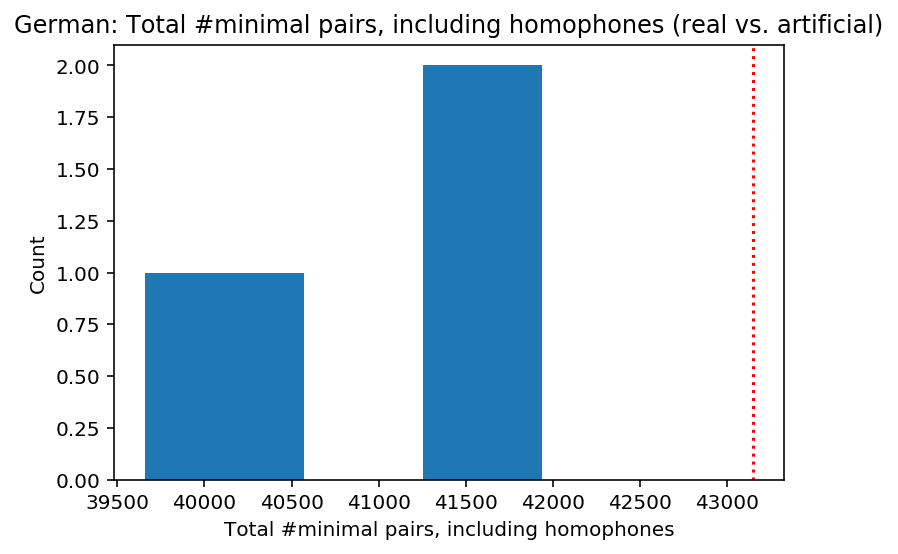

In [76]:
plot_real_vs_art(info_for_german['total_mp_w_hp'], df_german_stats['total_mp_w_hp'],
                'Total #minimal pairs, including homophones', language='German')

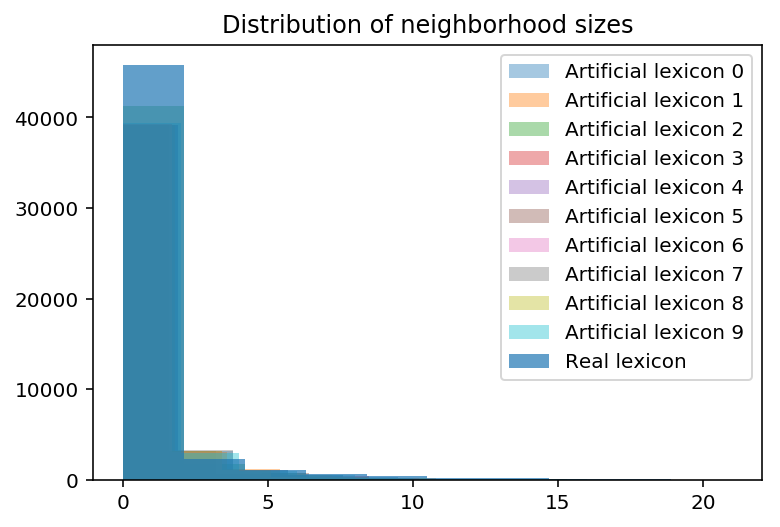

In [29]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size'], 
          alpha = .7, label = "Real lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

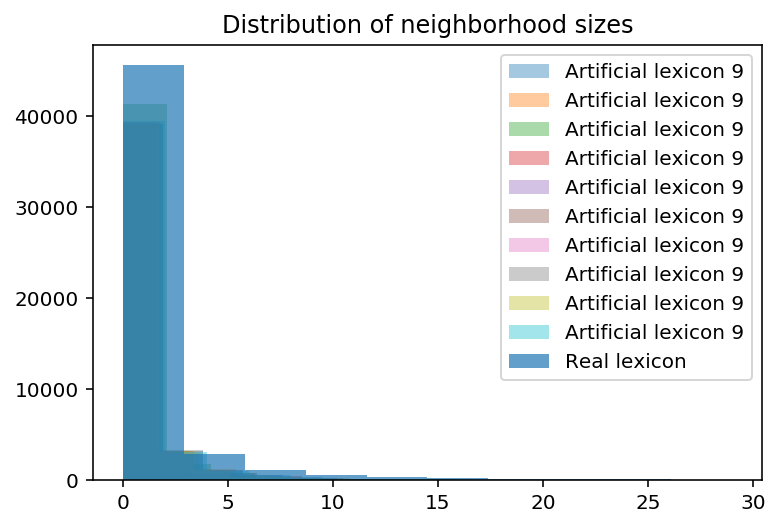

In [30]:
for df_tmp in processed_artificials:
    plt.hist(df_tmp['neighborhood_size'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size_with_homophones'], 
          alpha = .7, label = "Real lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

### Comparing homophone distributions

See also: https://github.com/seantrott/homophone_simulations/blob/master/using_null_lexicons.ipynb

When it comes to **homophones**, however, the artificial lexicons have a higher number of *maximum* homophones per word (upwards of 40, in some cases) than the real lexicon (below 10). There is also a higher number of *mean* homophones per word, and a higher percentage of homophonous wordforms overall.

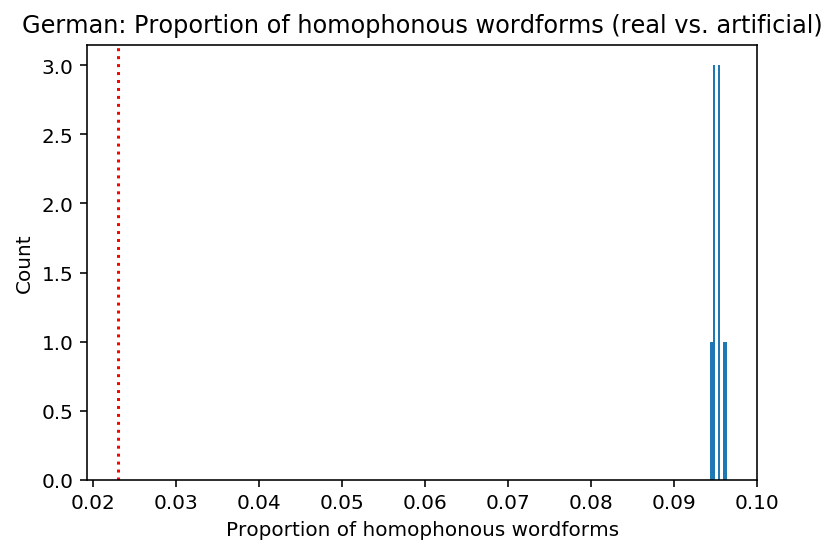

In [58]:
plot_real_vs_art(info_for_german['homophone_percentages'], df_german_stats['homophone_percentage'],
                'Proportion of homophonous wordforms', language='German')
plt.savefig("Figures/german/german_%_homophones.png", dpi=300)

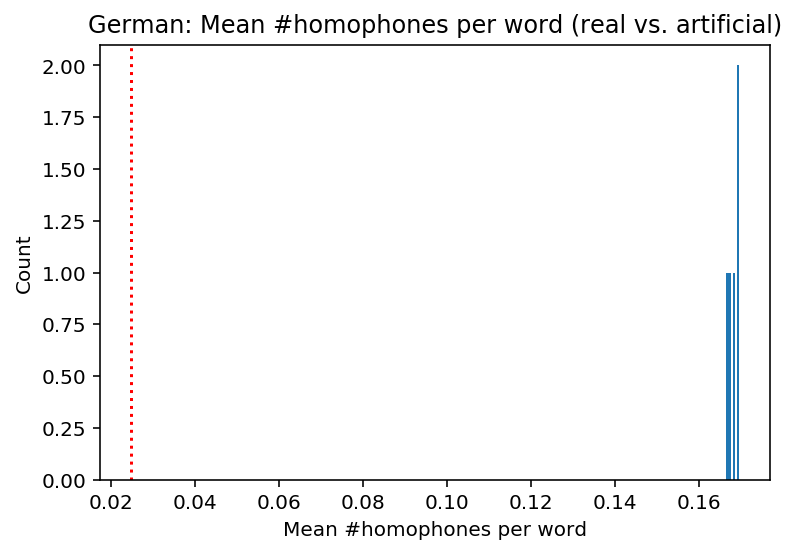

In [78]:
plot_real_vs_art(info_for_german['mean_homophones'], df_german_stats['mean_homophones'],
                'Mean #homophones per word', language='German')
plt.savefig("Figures/german/german_mean_homophones.png", dpi=300)

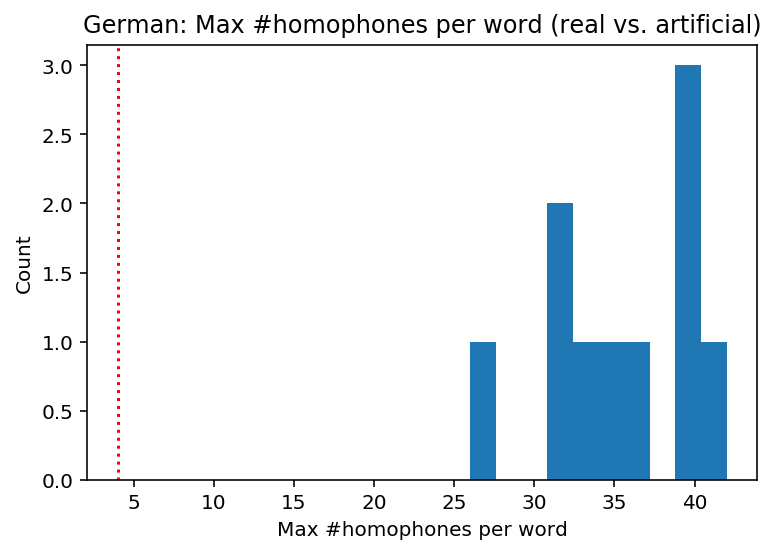

In [79]:
plot_real_vs_art(info_for_german['max_homophones'], df_german_stats['max_homophones'],
                'Max #homophones per word', language='German')
plt.savefig("Figures/german/german_max_homophones.png", dpi=300)

### Number of homophones and neighborhood size (German)

Do larger neighborhoods have more homophones?

Here, we regress: 
```
#homophones ~ neighborhood size + #syllables + surprisal
```


Interestingly, we find the following effects:

- The effect of **surprisal** is larger in artificial lexicons than the real lexicon (as shown in our other analysis).
- The effect of **#syllables** is smaller in the artificial lexicons than real lexicon (as shown in the other analysis).
- Finally, the effect of **neighborhood size** is larger in the *real* lexicon than artifical lexicons. 

#### Analysis

In [44]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#syllables', 
    # '#minimal pairs'
]
LANGUAGE = 'German'

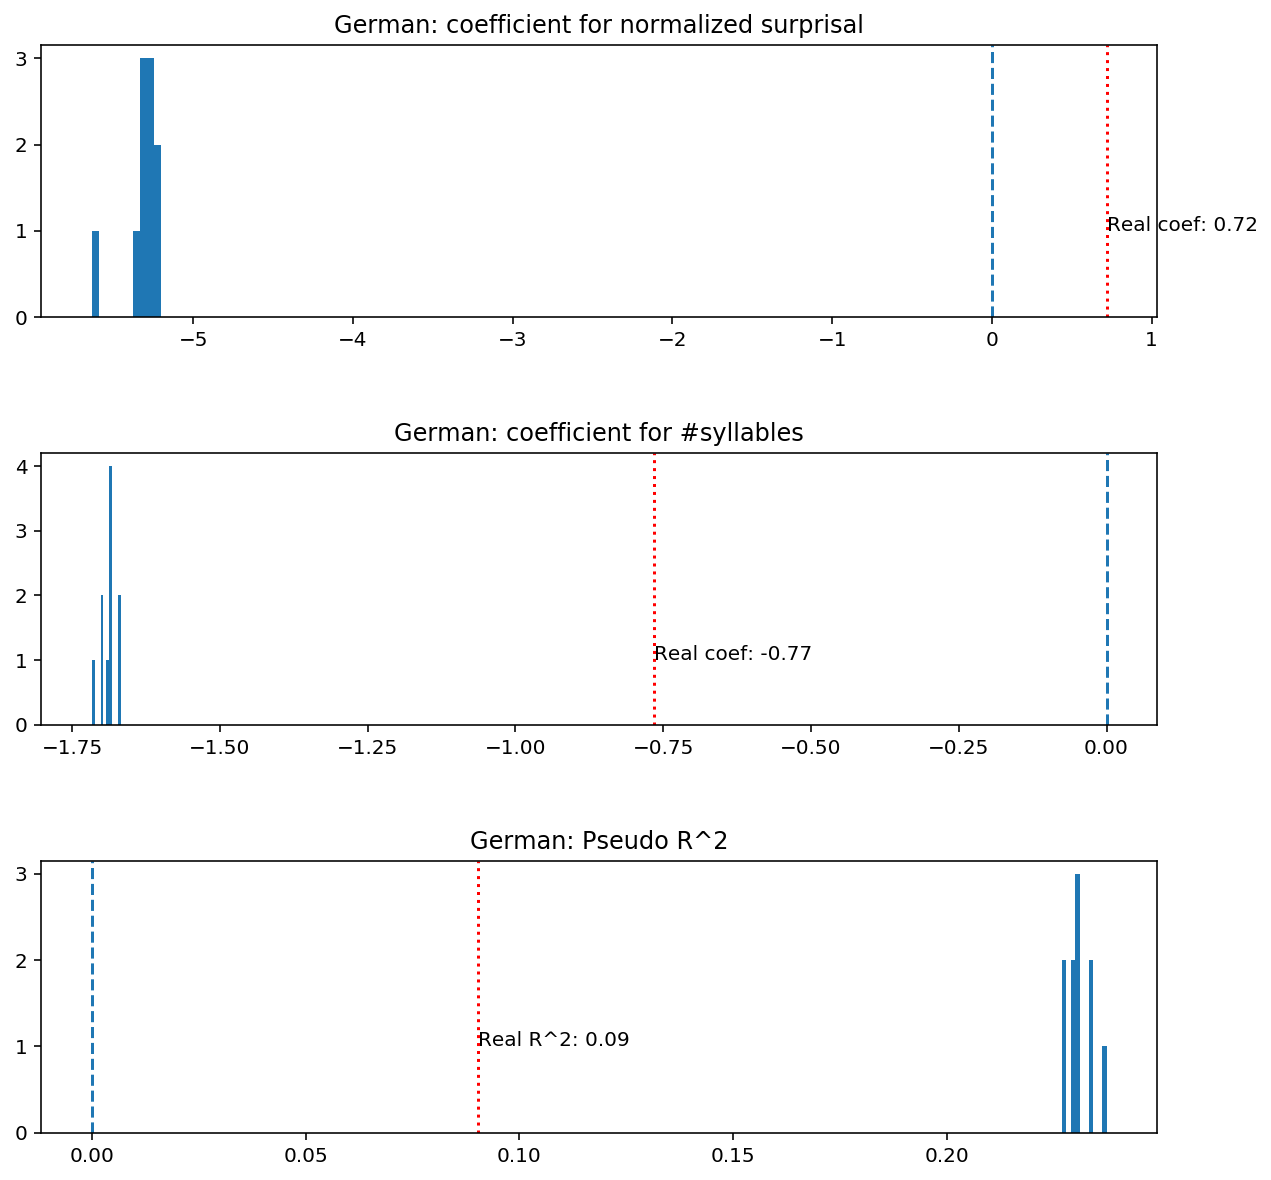

In [45]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

In [46]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
    'neighborhood_size'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#syllables', 
    '#minimal pairs'
]
LANGUAGE = 'German'

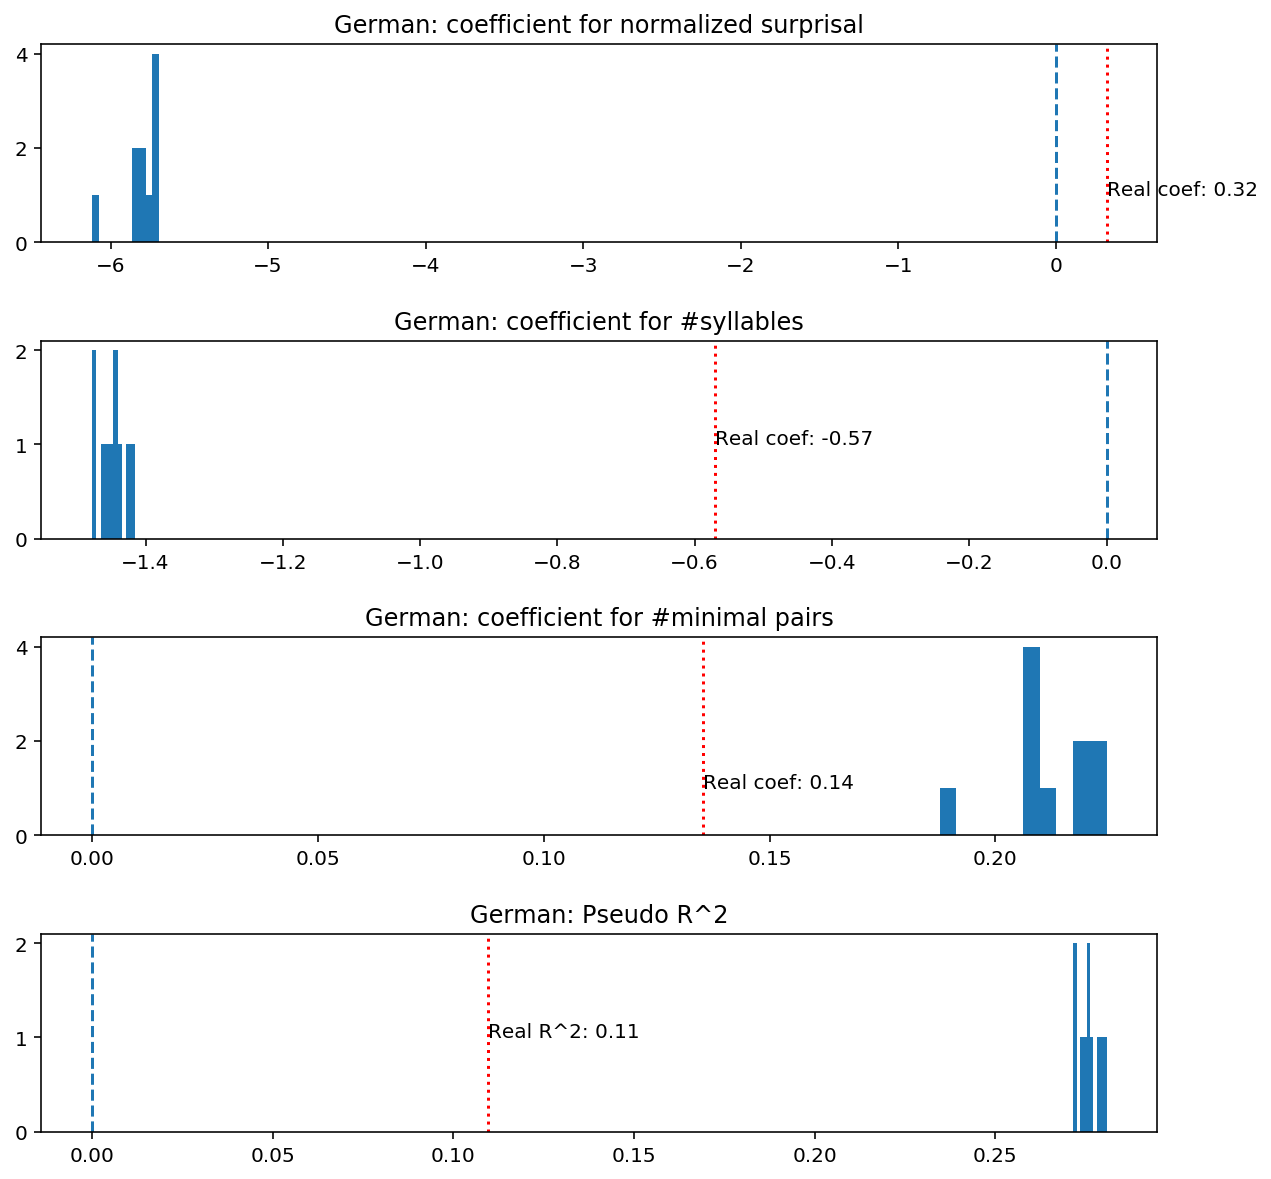

In [47]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

### Predicting neighborhood size from number of homophones

Do words with more homophones have larger neighborhoods?

This just takes the analysis above and inverts it:

```
neighborhood size ~ #homophones + #syllables + surprisal
```

Mostly consistent with the above analysis in English, we find:

- The effect of **surprisal** (predicting #minimal pairs) is larger in the real lexicon than in the artificial lexicon.
- The effect of **#syllables** is larger in the artificial than real lexicon (this is distinct from the analysis in English).
- The effect of **#homophones** is larger in the real lexicon than in the artificial lexicons.

#### Analysis

In [48]:
TARGET = 'neighborhood_size'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
    # 'num_homophones'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#syllables', 
    # '#homophones'
]
LANGUAGE = 'German'

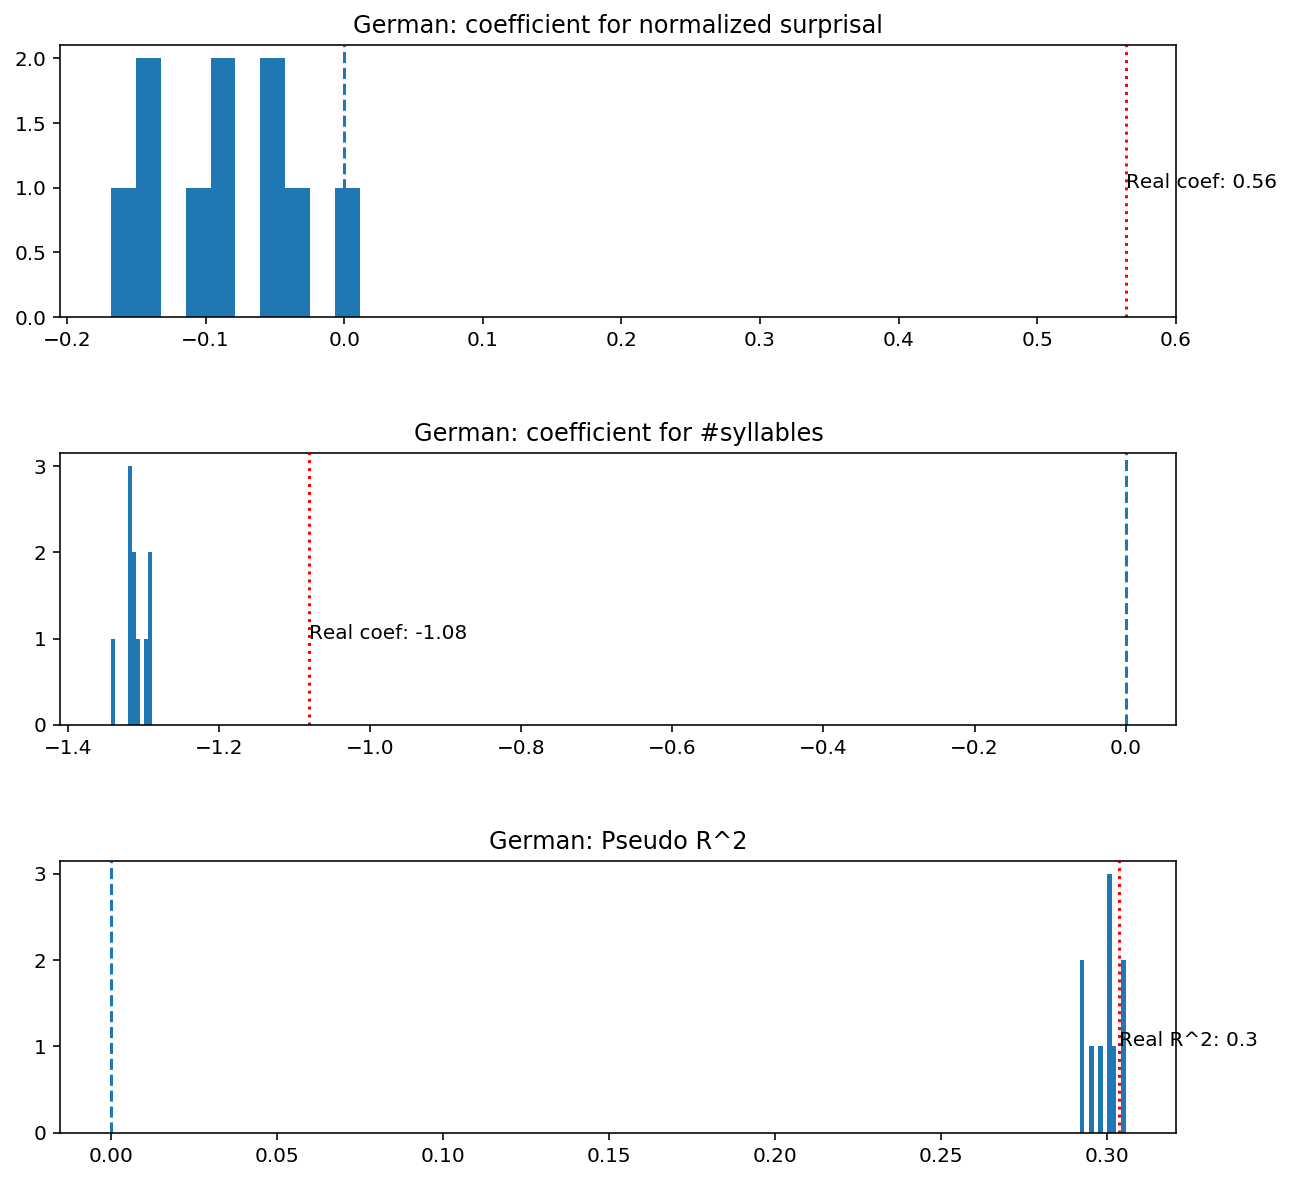

In [49]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

# Dutch

In [50]:
df_celex, df_celex_processed, df_dutch_artificials = load_lexicons_for_language("dutch")

In [51]:
len(df_celex)

67910

In [52]:
len(df_celex_processed)

65351

In [53]:
df_dutch_stats = get_stats_for_lexicon(df_celex_processed)

### Preprocess artificials

In [54]:
info_for_dutch = process_and_extract_artificials(df_dutch_artificials)

100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


In [55]:
processed_artificials = info_for_dutch['processed_dataframes']

In [58]:
df_celex_processed['surprisal_normed'] = df_celex_processed['surprisal'] / df_celex_processed['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Visualizations

### `#homophones` ~ `rank_homophones`

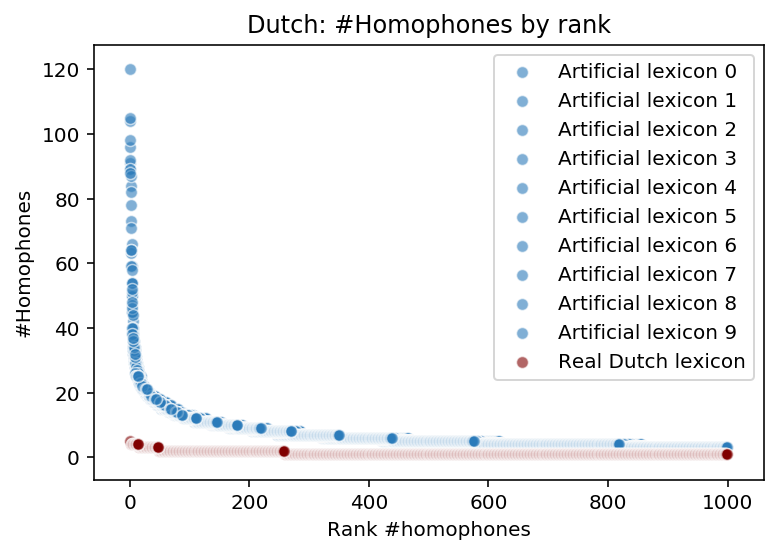

In [197]:
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    sns.scatterplot(data = df_tmp_art[df_tmp_art['rank_num']<1000],
                    x = "rank_num",
                    alpha = .6,
                    y = "num_homophones", 
                    color = sns.color_palette("Blues")[4], 
                    label = "Artificial lexicon {x}".format(x=index))

df_celex_processed['rank_num'] = df_celex_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "num_homophones", 
                color = "maroon",
                alpha = .6,
                label = "Real Dutch lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("Dutch: #Homophones by rank")

plt.savefig("Figures/dutch/data_visualizations/rank_homophones.png", dpi=300)

### `#minimal pairs` ~ `rank_minimal_pairs`

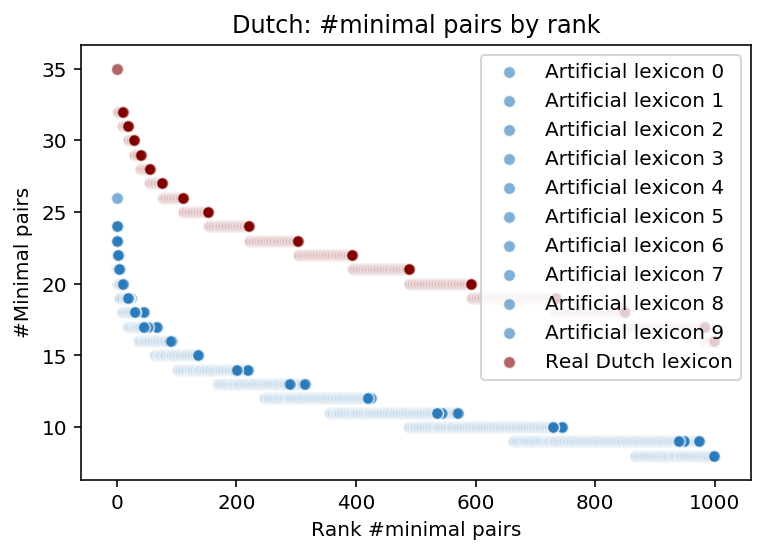

In [31]:
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_neighborhood'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    sns.scatterplot(data = df_tmp_art[df_tmp_art['rank_neighborhood']<1000],
                    x = "rank_neighborhood",
                    alpha = .6,
                    y = "neighborhood_size", 
                    color = sns.color_palette("Blues")[4], 
                    label = "Artificial lexicon {x}".format(x=index))

df_celex_processed['rank_neighborhood'] = df_celex_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_neighborhood']<1000],
               x = "rank_neighborhood",
               y = "neighborhood_size", 
                color = "maroon",
                alpha = .6,
                label = "Real Dutch lexicon")
plt.xlabel("Rank #minimal pairs")
plt.ylabel("#Minimal pairs")
plt.title("Dutch: #minimal pairs by rank")

plt.savefig("Figures/dutch/data_visualizations/rank_neighborhoods.png", dpi=300)


### Comparing neighborhood distributions (Dautriche et al, 2016)

As reported by Dautriche et al (2016), the real lexicon has higher average neighborhood sizes (and larger maximum neighborhoods) than the artificial lexicons.

Comparing the actual distributions, it seems like this is driven by the real lexicon having a longer, larger tail (consistent with the idea that there is a larger **maximum** neighborhood size in the real lexicon). 

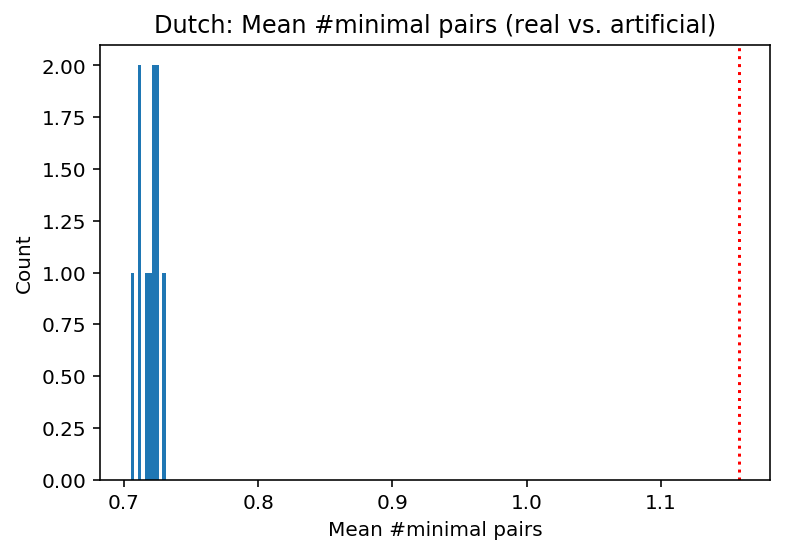

In [86]:
plot_real_vs_art(info_for_dutch['mean_mp'], df_dutch_stats['mean_mp'],
                'Mean #minimal pairs', language="Dutch")

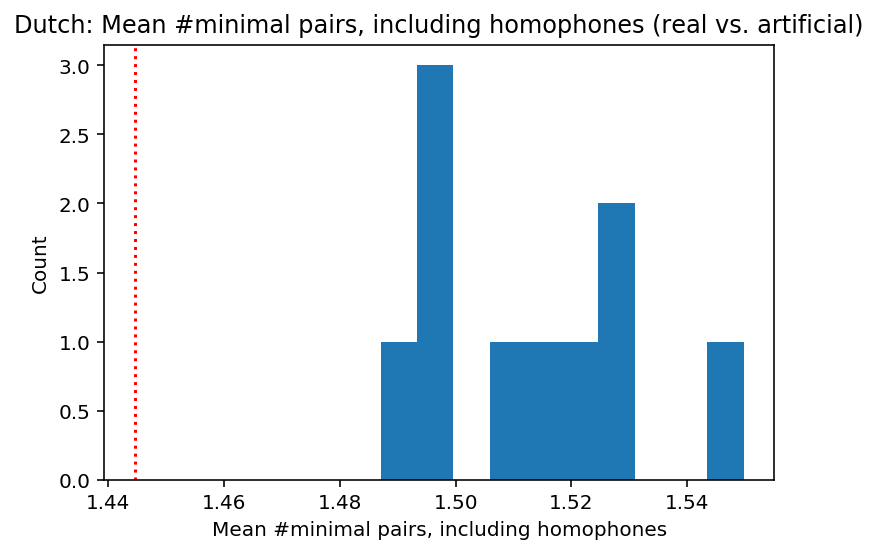

In [87]:
plot_real_vs_art(info_for_dutch['mean_mp_w_hp'], df_dutch_stats['mean_mp_w_hp'],
                'Mean #minimal pairs, including homophones', language="Dutch")

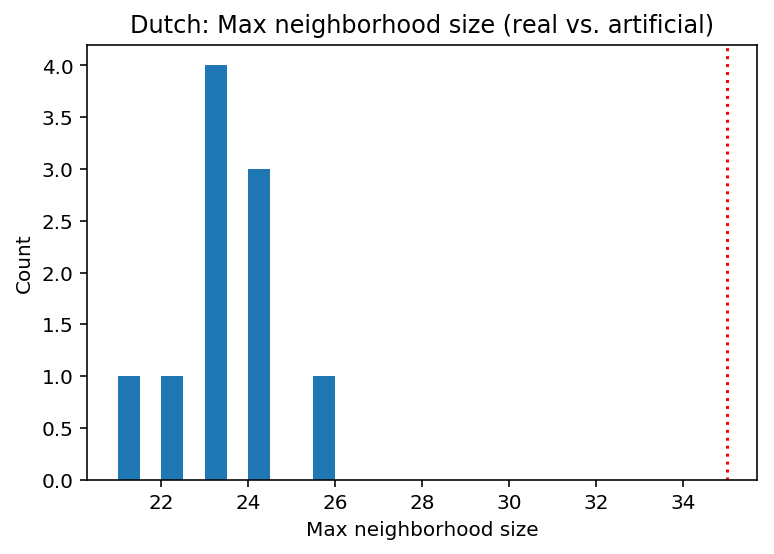

In [88]:
plot_real_vs_art(info_for_dutch['max_mp'], df_dutch_stats['max_mp'],
                'Max neighborhood size', language="Dutch")

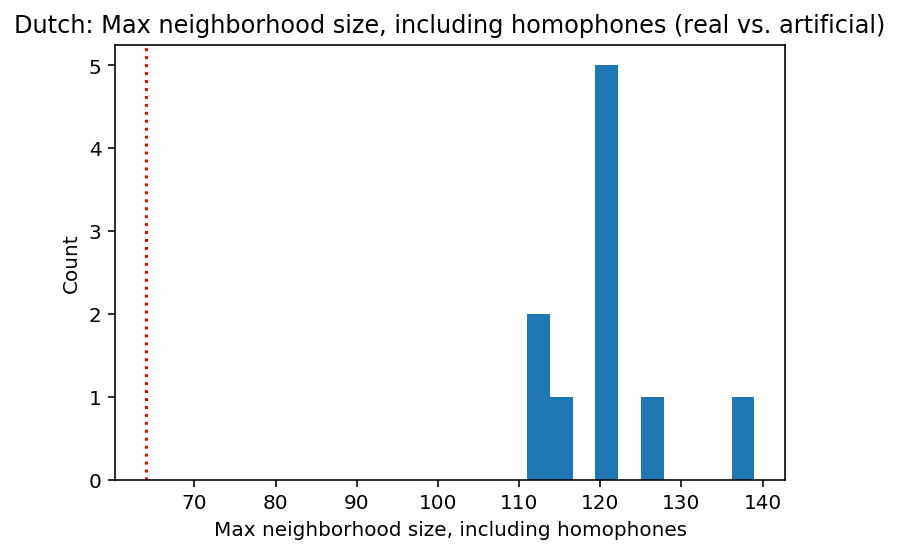

In [89]:
plot_real_vs_art(info_for_dutch['max_mp_w_hp'], df_dutch_stats['max_mp_w_hp'],
                'Max neighborhood size, including homophones', language="Dutch")

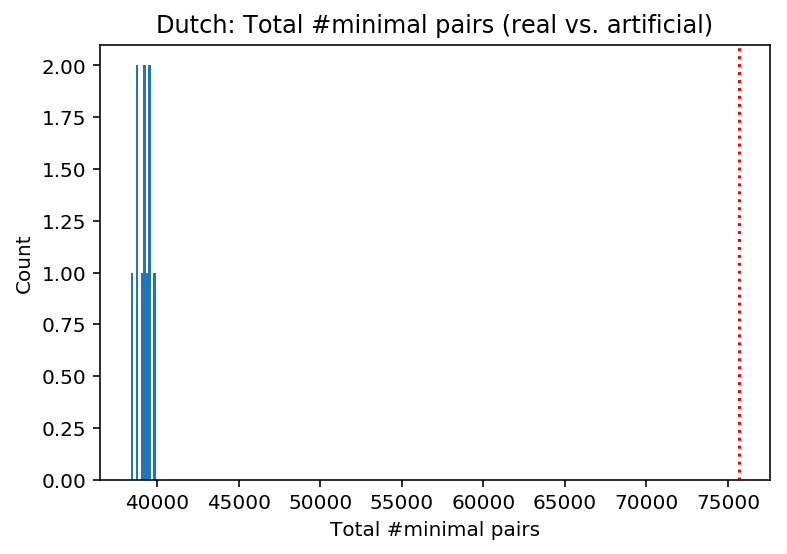

In [90]:
plot_real_vs_art(info_for_dutch['total_mp'], df_dutch_stats['total_mp'],
                'Total #minimal pairs', language='Dutch')

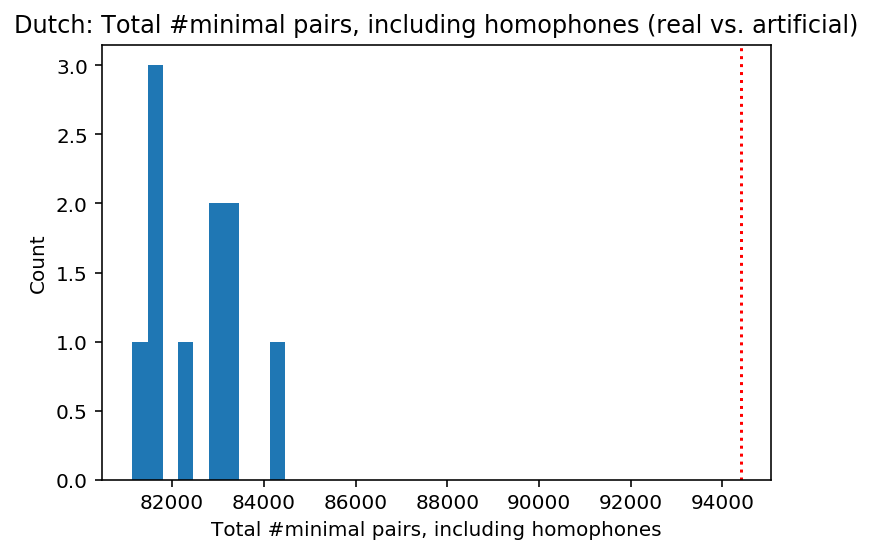

In [91]:
plot_real_vs_art(info_for_dutch['total_mp_w_hp'], df_dutch_stats['total_mp_w_hp'],
                'Total #minimal pairs, including homophones', language='Dutch')

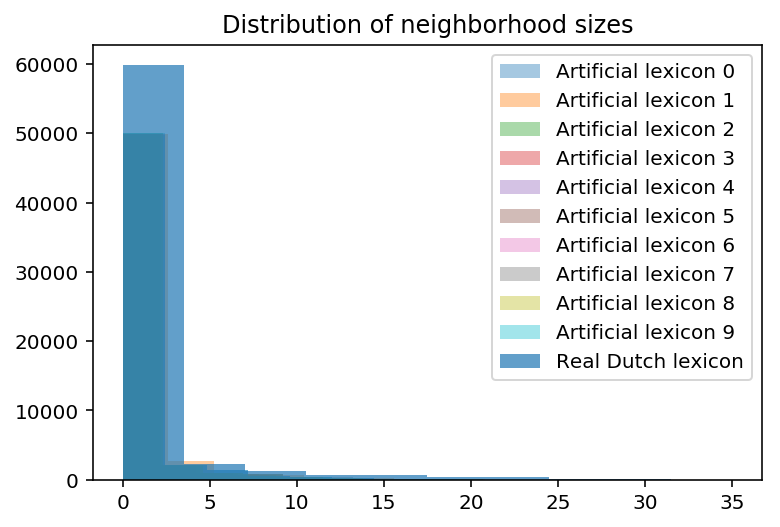

In [92]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size'], 
          alpha = .7, label = "Real Dutch lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

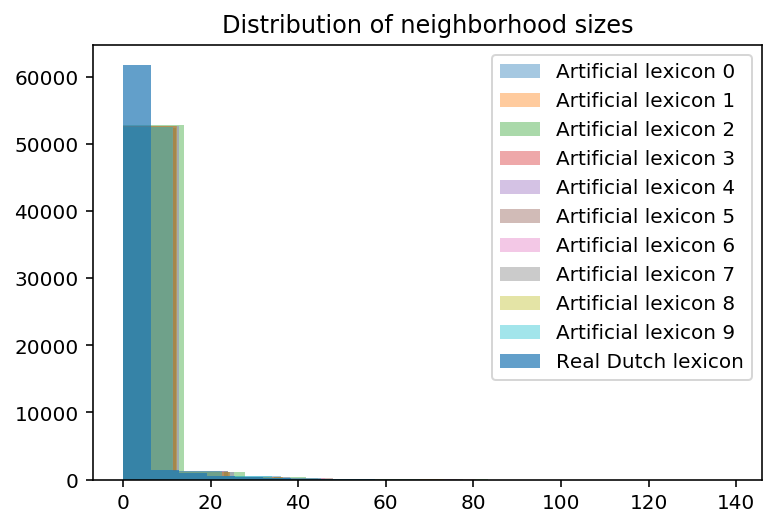

In [93]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size_with_homophones'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size_with_homophones'], 
          alpha = .7, label = "Real Dutch lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

### Comparing homophone distributions

See also: https://github.com/seantrott/homophone_simulations/blob/master/using_null_lexicons.ipynb

When it comes to **homophones**, however, the artificial lexicons have a higher number of *maximum* homophones per word (upwards of 40, in some cases) than the real lexicon (below 10). There is also a higher number of *mean* homophones per word.

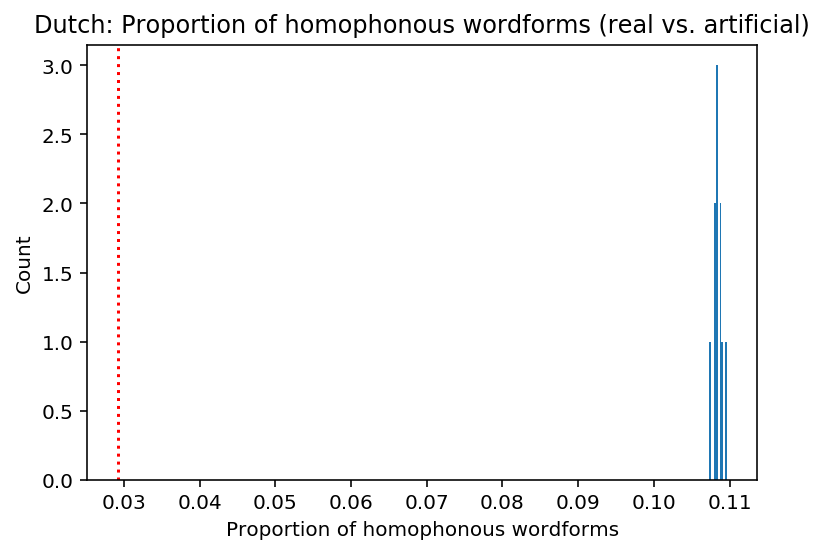

In [51]:
plot_real_vs_art(info_for_dutch['homophone_percentages'], df_dutch_stats['homophone_percentage'],
                'Proportion of homophonous wordforms', language='Dutch')
plt.savefig("Figures/dutch/dutch_%_homophones.png", dpi=300)

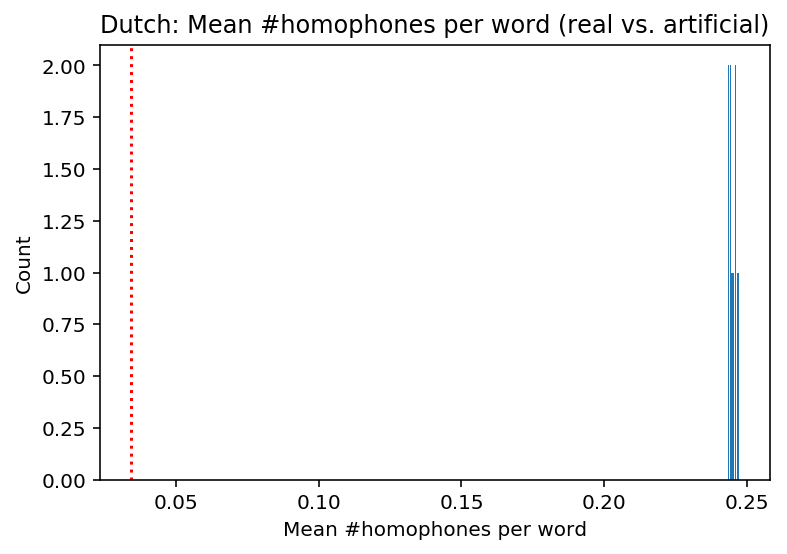

In [95]:
plot_real_vs_art(info_for_dutch['mean_homophones'], df_dutch_stats['mean_homophones'],
                'Mean #homophones per word', language='Dutch')
plt.savefig("Figures/dutch/dutch_mean_homophones.png", dpi=300)

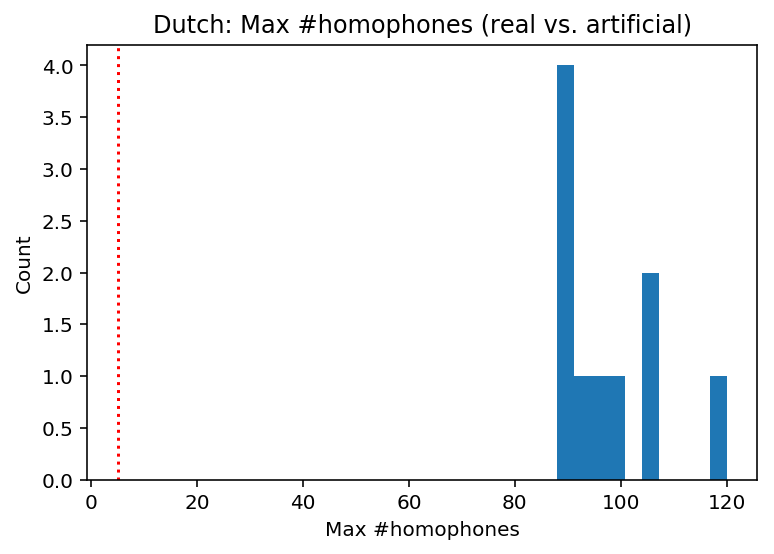

In [96]:
plot_real_vs_art(info_for_dutch['max_homophones'], df_dutch_stats['max_homophones'],
                'Max #homophones', language='Dutch')
plt.savefig("Figures/dutch/dutch_max_homophones.png", dpi=300)

### Number of homophones and neighborhood size (Dutch)

Do larger neighborhoods have more homophones?

Here, we regress: 
```
#homophones ~ neighborhood size + #syllables + surprisal
```


Interestingly, we find the following effects:

- The effect of **surprisal** is larger in artificial lexicons than the real lexicon (as shown in our other analysis).
- The effect of **#syllables** is smaller in the artificial lexicons than real lexicon (as shown in the other analysis).
- Finally, the effect of **neighborhood size** is larger in the *real* lexicon than artifical lexicons. 

#### Analysis

In [56]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#syllables', 
]
LANGUAGE = 'Dutch'

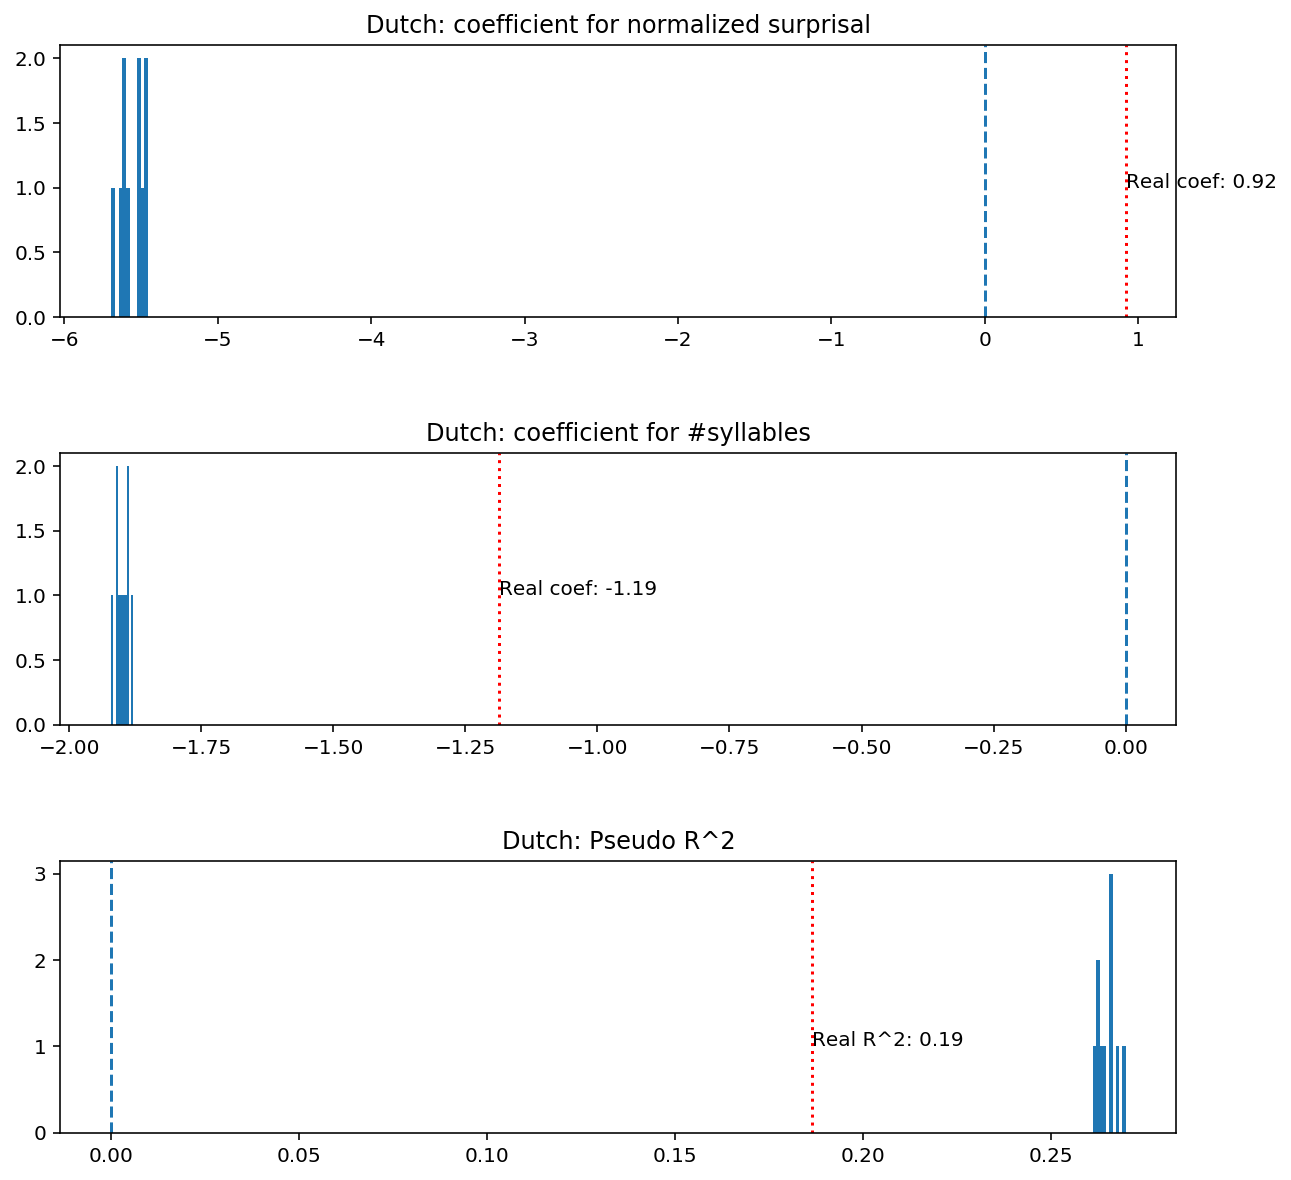

In [59]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

In [60]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
    'neighborhood_size'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#syllables', 
    '#minimal pairs'
]
LANGUAGE = 'Dutch'

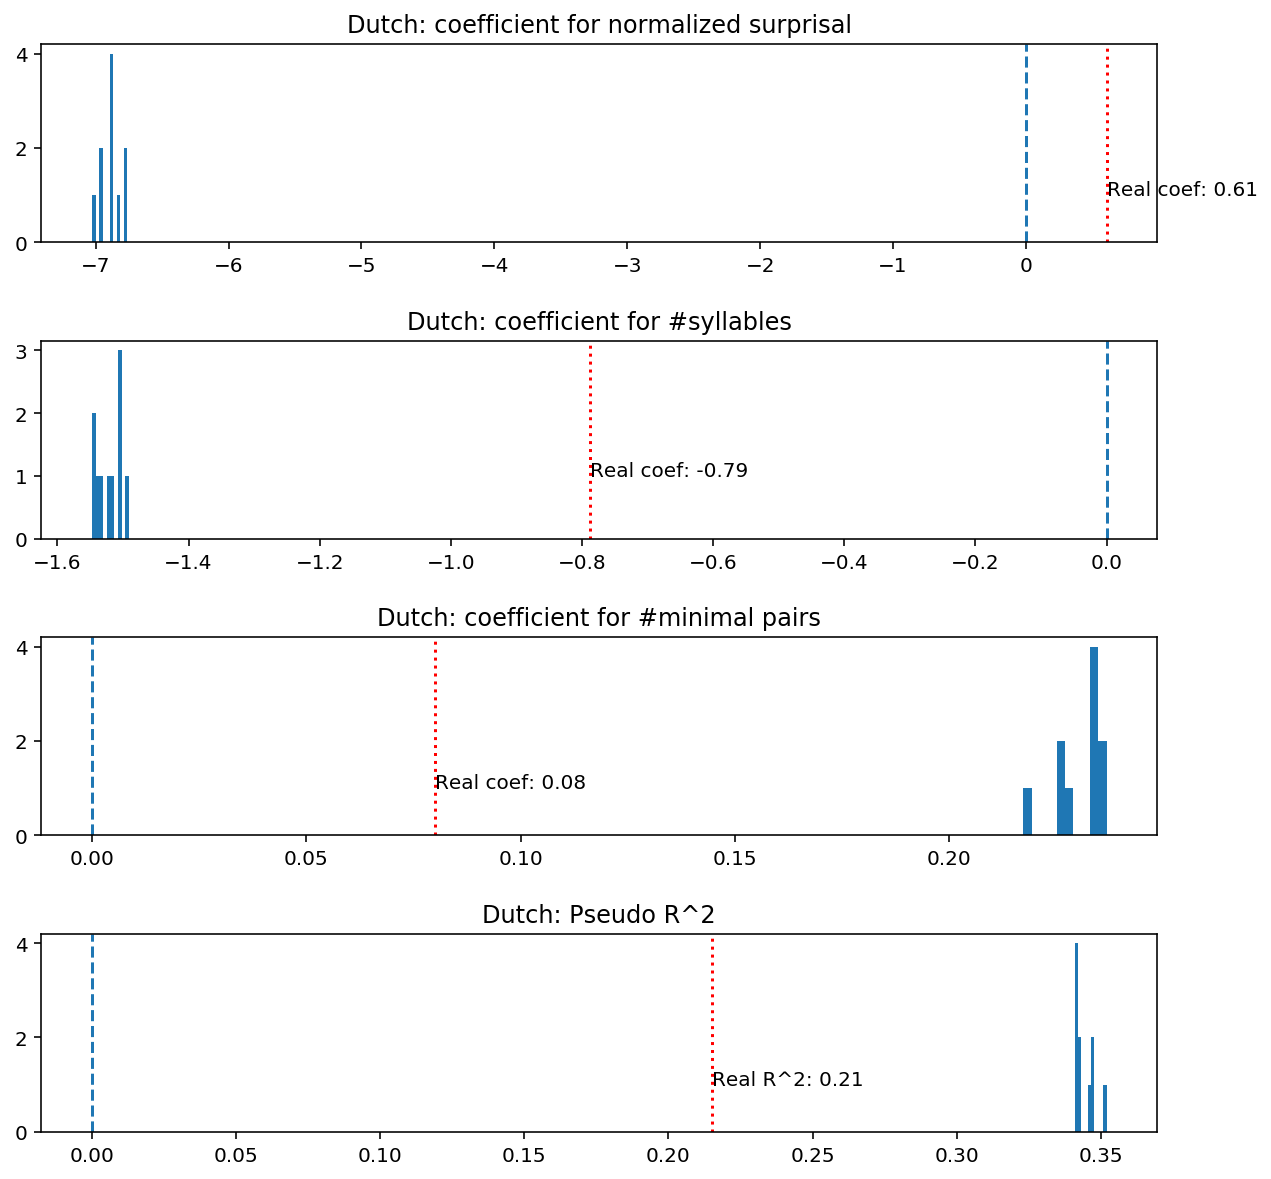

In [61]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

### Predicting neighborhood size from number of homophones

Do words with more homophones have larger neighborhoods?

This just takes the analysis above and inverts it:

```
neighborhood size ~ #syllables + surprisal
```


#### Analysis

In [62]:
TARGET = 'neighborhood_size'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#syllables', 
]
LANGUAGE = 'Dutch'

/Users/seantrott/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


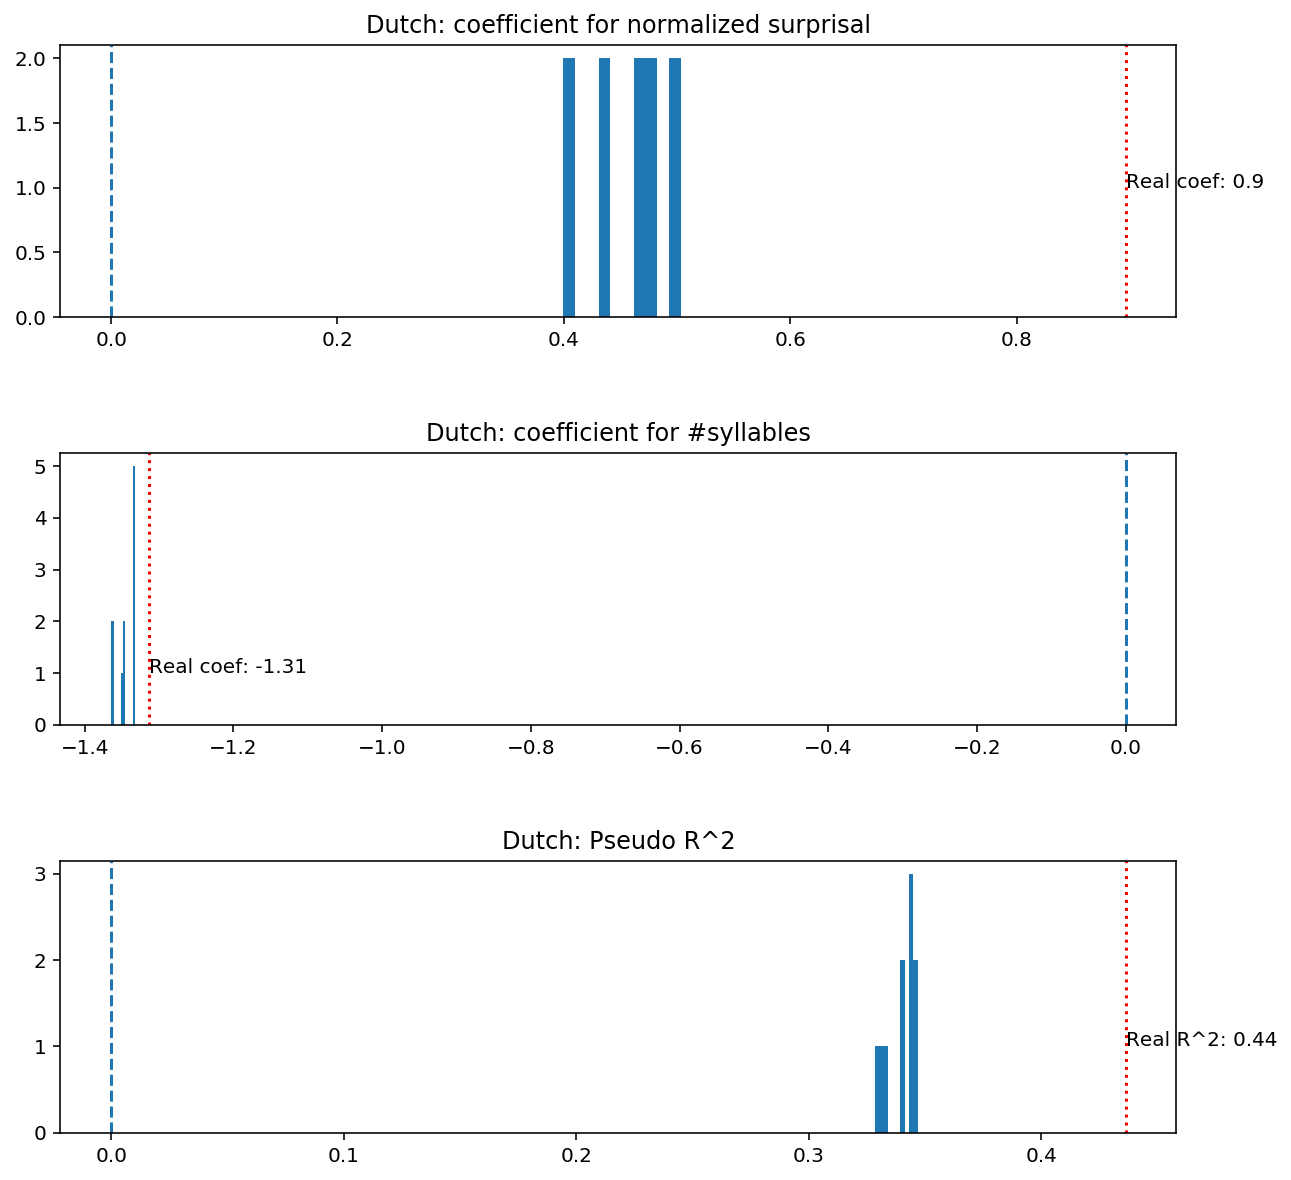

In [63]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

# French

In [64]:
import src.config as config

In [65]:
df_celex, df_celex_processed, df_french_artificials = load_lexicons_for_language("french", 
                                                                                word_column=config.WORD_COLUMN['french'], 
                                                                                phon_column=config.PHON_COLUMN['french'])

/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)


In [66]:
len(df_celex)

47310

In [67]:
len(df_celex_processed)

37278

In [68]:
df_french_stats = get_stats_for_lexicon(df_celex_processed)

### Preprocess artificials

In [69]:
info_for_french = process_and_extract_artificials(df_french_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


In [70]:
processed_artificials = info_for_french['processed_dataframes']

In [71]:
df_celex_processed['surprisal_normed'] = df_celex_processed['surprisal'] / df_celex_processed['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Visualizations

### `#homophones` ~ `rank_homophones`

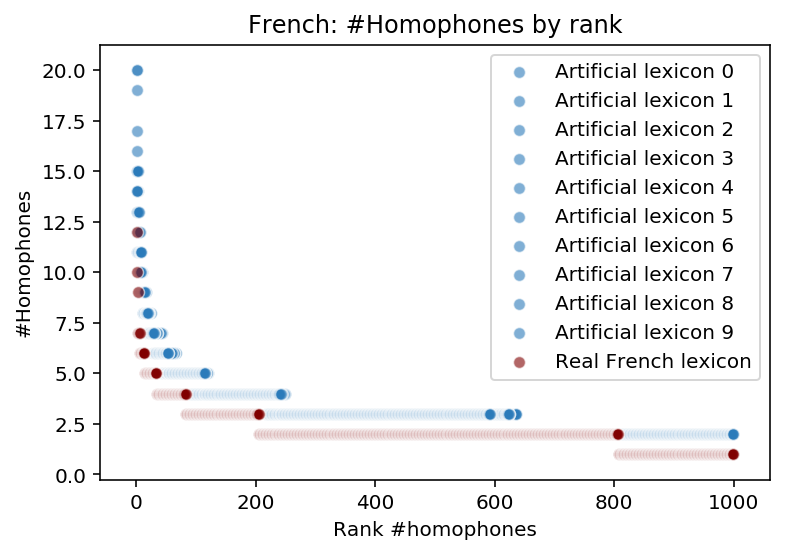

In [205]:
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    sns.scatterplot(data = df_tmp_art[df_tmp_art['rank_num']<1000],
                    x = "rank_num",
                    alpha = .6,
                    y = "num_homophones", 
                    color = sns.color_palette("Blues")[4], 
                    label = "Artificial lexicon {x}".format(x=index))

df_celex_processed['rank_num'] = df_celex_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "num_homophones", 
                color = "maroon",
                alpha = .6,
                label = "Real French lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("French: #Homophones by rank")

plt.savefig("Figures/french/data_visualizations/rank_homophones.png", dpi=300)

### `#minimal pairs` ~ `rank_minimal_pairs`

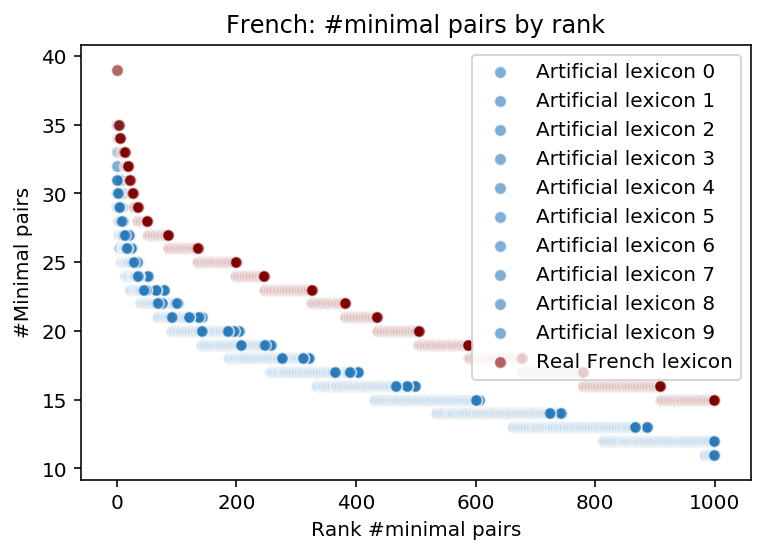

In [39]:
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_neighborhood'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    sns.scatterplot(data = df_tmp_art[df_tmp_art['rank_neighborhood']<1000],
                    x = "rank_neighborhood",
                    alpha = .6,
                    y = "neighborhood_size", 
                    color = sns.color_palette("Blues")[4], 
                    label = "Artificial lexicon {x}".format(x=index))

df_celex_processed['rank_neighborhood'] = df_celex_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_neighborhood']<1000],
               x = "rank_neighborhood",
               y = "neighborhood_size", 
                color = "maroon",
                alpha = .6,
                label = "Real French lexicon")
plt.xlabel("Rank #minimal pairs")
plt.ylabel("#Minimal pairs")
plt.title("French: #minimal pairs by rank")

plt.savefig("Figures/french/data_visualizations/rank_neighborhoods.png", dpi=300)


### Comparing neighborhood distributions (Dautriche et al, 2016)

As reported by Dautriche et al (2016), the real lexicon has higher average neighborhood sizes (and larger maximum neighborhoods) than the artificial lexicons.

Comparing the actual distributions, it seems like this is driven by the real lexicon having a longer, larger tail (consistent with the idea that there is a larger **maximum** neighborhood size in the real lexicon). 

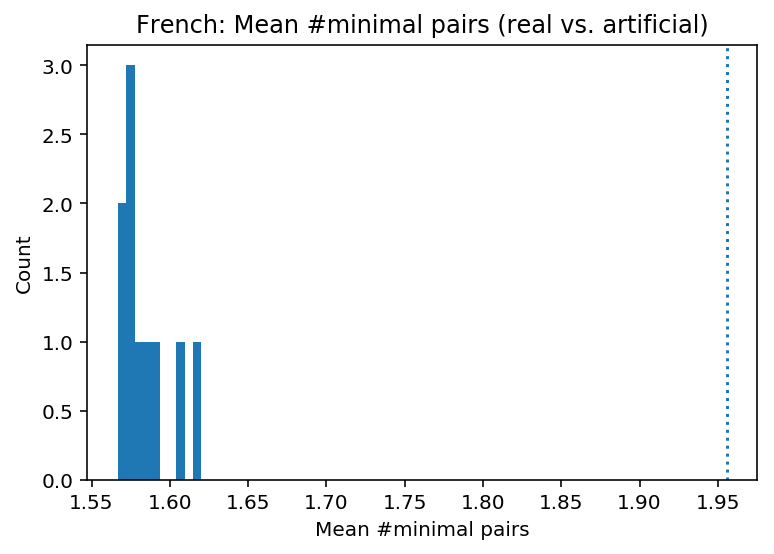

In [52]:
plot_real_vs_art(info_for_french['mean_mp'], df_french_stats['mean_mp'],
                'Mean #minimal pairs', language="French")

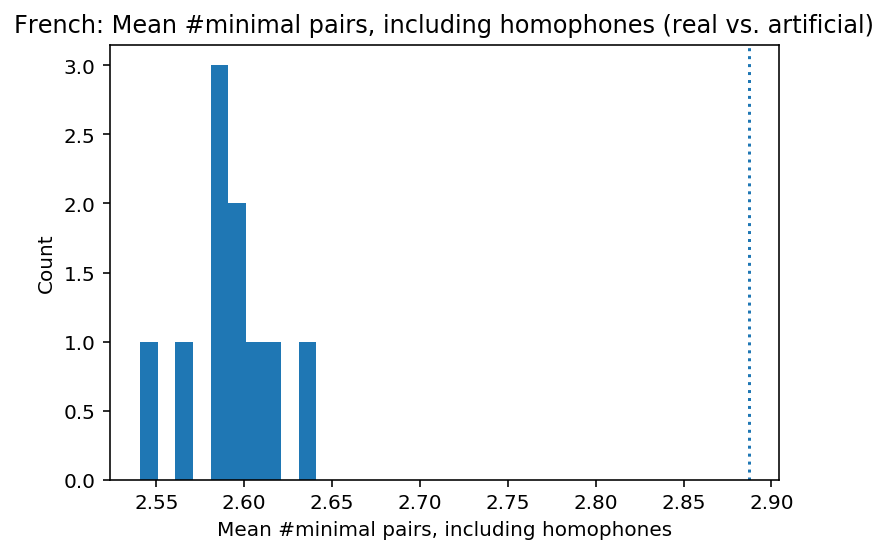

In [53]:
plot_real_vs_art(info_for_french['mean_mp_w_hp'], df_french_stats['mean_mp_w_hp'],
                'Mean #minimal pairs, including homophones', language="French")

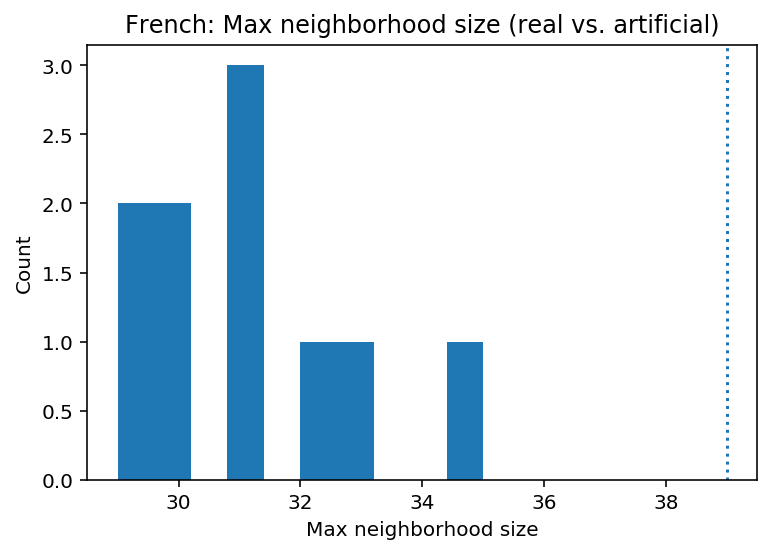

In [54]:
plot_real_vs_art(info_for_french['max_mp'], df_french_stats['max_mp'],
                'Max neighborhood size', language="French")

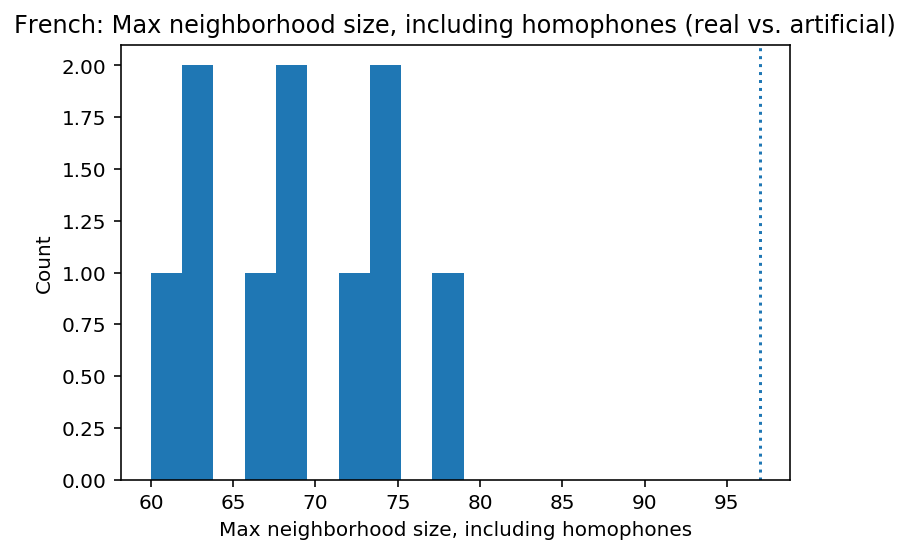

In [55]:
plot_real_vs_art(info_for_french['max_mp_w_hp'], df_french_stats['max_mp_w_hp'],
                'Max neighborhood size, including homophones', language="French")

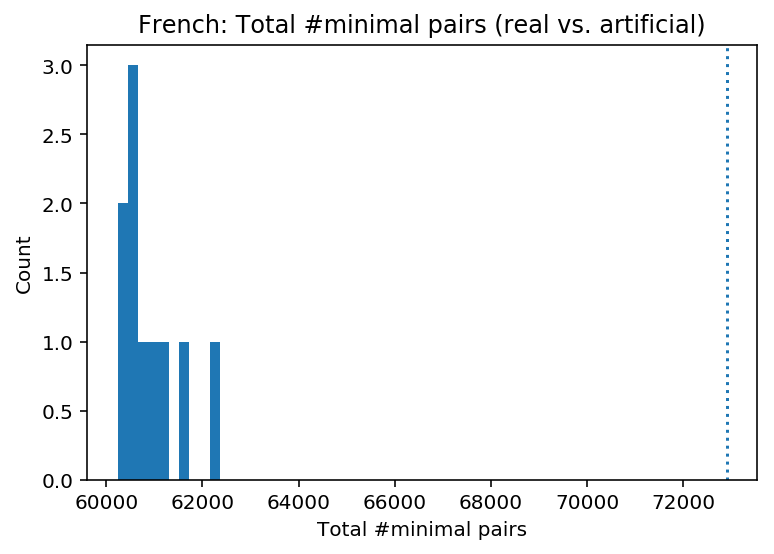

In [56]:
plot_real_vs_art(info_for_french['total_mp'], df_french_stats['total_mp'],
                'Total #minimal pairs', language='French')

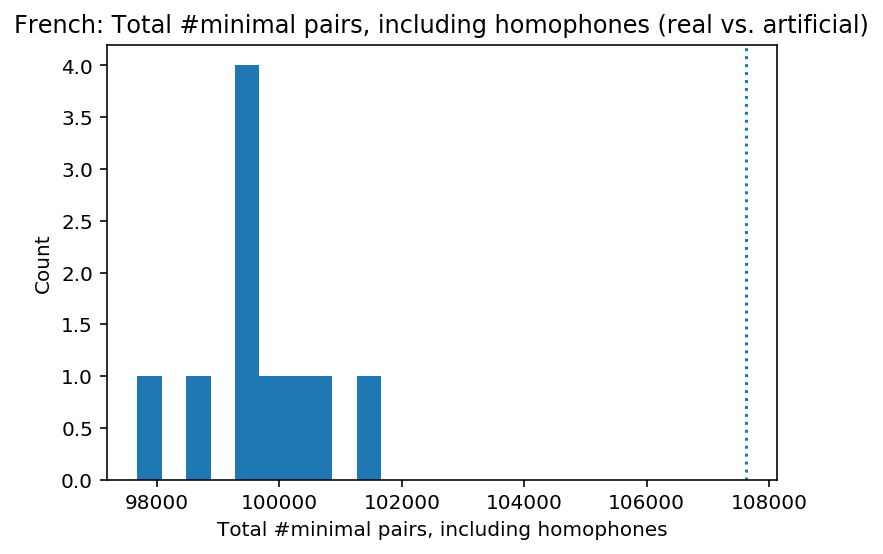

In [57]:
plot_real_vs_art(info_for_french['total_mp_w_hp'], df_french_stats['total_mp_w_hp'],
                'Total #minimal pairs, including homophones', language='French')

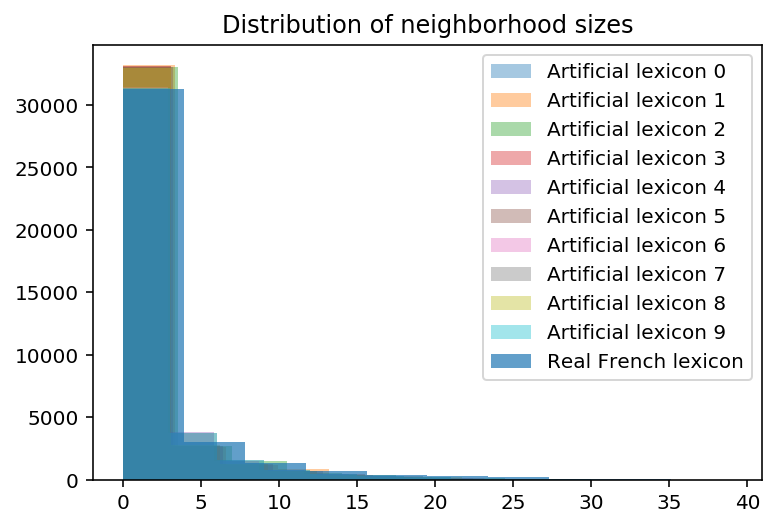

In [58]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size'], 
          alpha = .7, label = "Real French lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

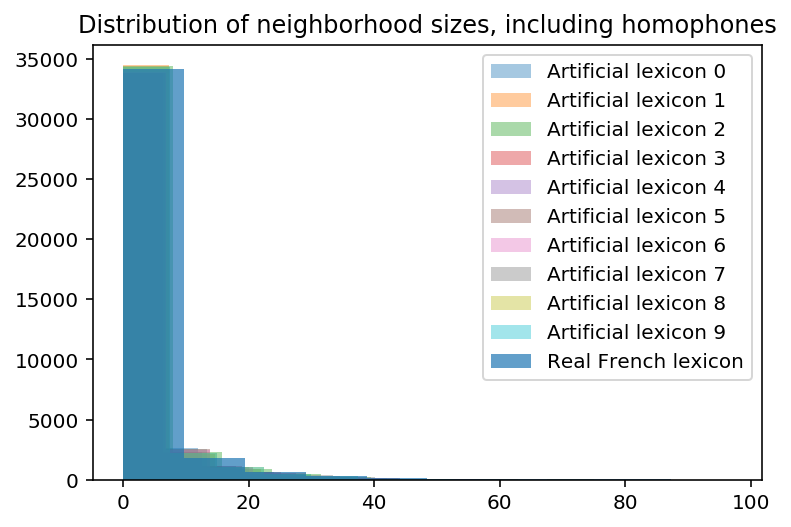

In [59]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size_with_homophones'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size_with_homophones'], 
          alpha = .7, label = "Real French lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes, including homophones")
plt.legend()

### Comparing homophone distributions

See also: https://github.com/seantrott/homophone_simulations/blob/master/using_null_lexicons.ipynb

When it comes to **homophones**, however, the artificial lexicons have a higher number of *maximum* homophones per word (upwards of 40, in some cases) than the real lexicon (below 10). There is also a higher number of *mean* homophones per word.

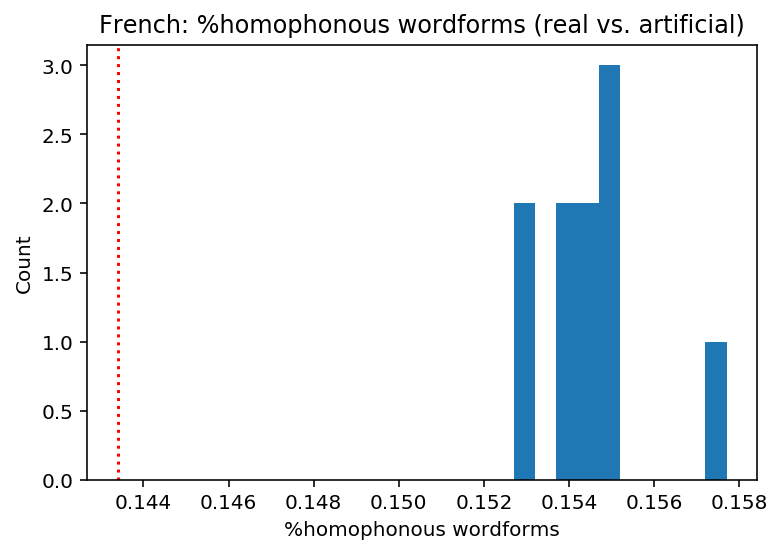

In [104]:
plot_real_vs_art(info_for_french['homophone_percentages'], df_french_stats['homophone_percentage'],
                'Proportion of homophonous wordforms', language='French')
plt.savefig("Figures/french/french_%_homophones.png", dpi=300)

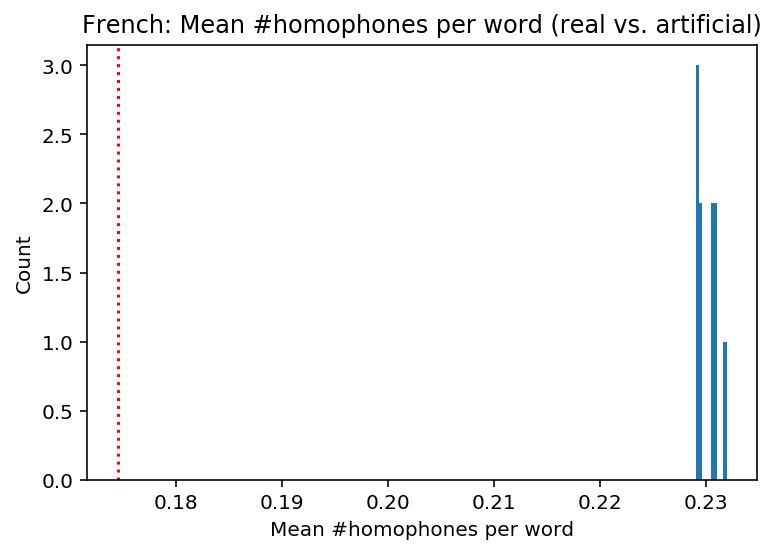

In [105]:
plot_real_vs_art(info_for_french['mean_homophones'], df_french_stats['mean_homophones'],
                'Mean #homophones per word', language='French')
plt.savefig("Figures/french/french_mean_homophones.png", dpi=300)

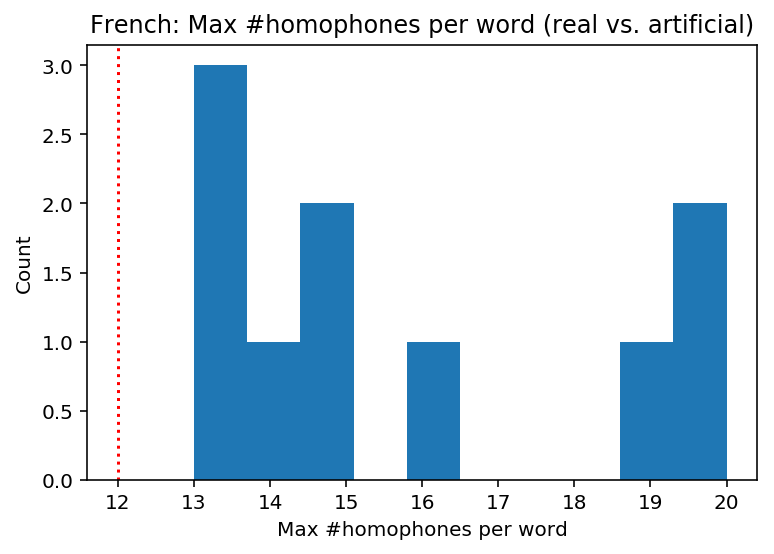

In [106]:
plot_real_vs_art(info_for_french['max_homophones'], df_french_stats['max_homophones'],
                'Max #homophones per word', language='French')
plt.savefig("Figures/french/french_max_homophones.png", dpi=300)

### Number of homophones and neighborhood size (French)

Do larger neighborhoods have more homophones?

Here, we regress: 
```
#homophones ~ neighborhood size + #syllables + surprisal
```


Interestingly, we find the following effects:

- The effect of **surprisal** is larger in artificial lexicons than the real lexicon (as shown in our other analysis).
- The effect of **#syllables** is larger in the artificial lexicons than real lexicon (as shown in English, when controlling for neighborhood size).
- Finally, the effect of **neighborhood size** is larger in the *real* lexicon than artifical lexicons. 

#### Analysis

In [72]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#syllables', 
]
LANGUAGE = 'French'

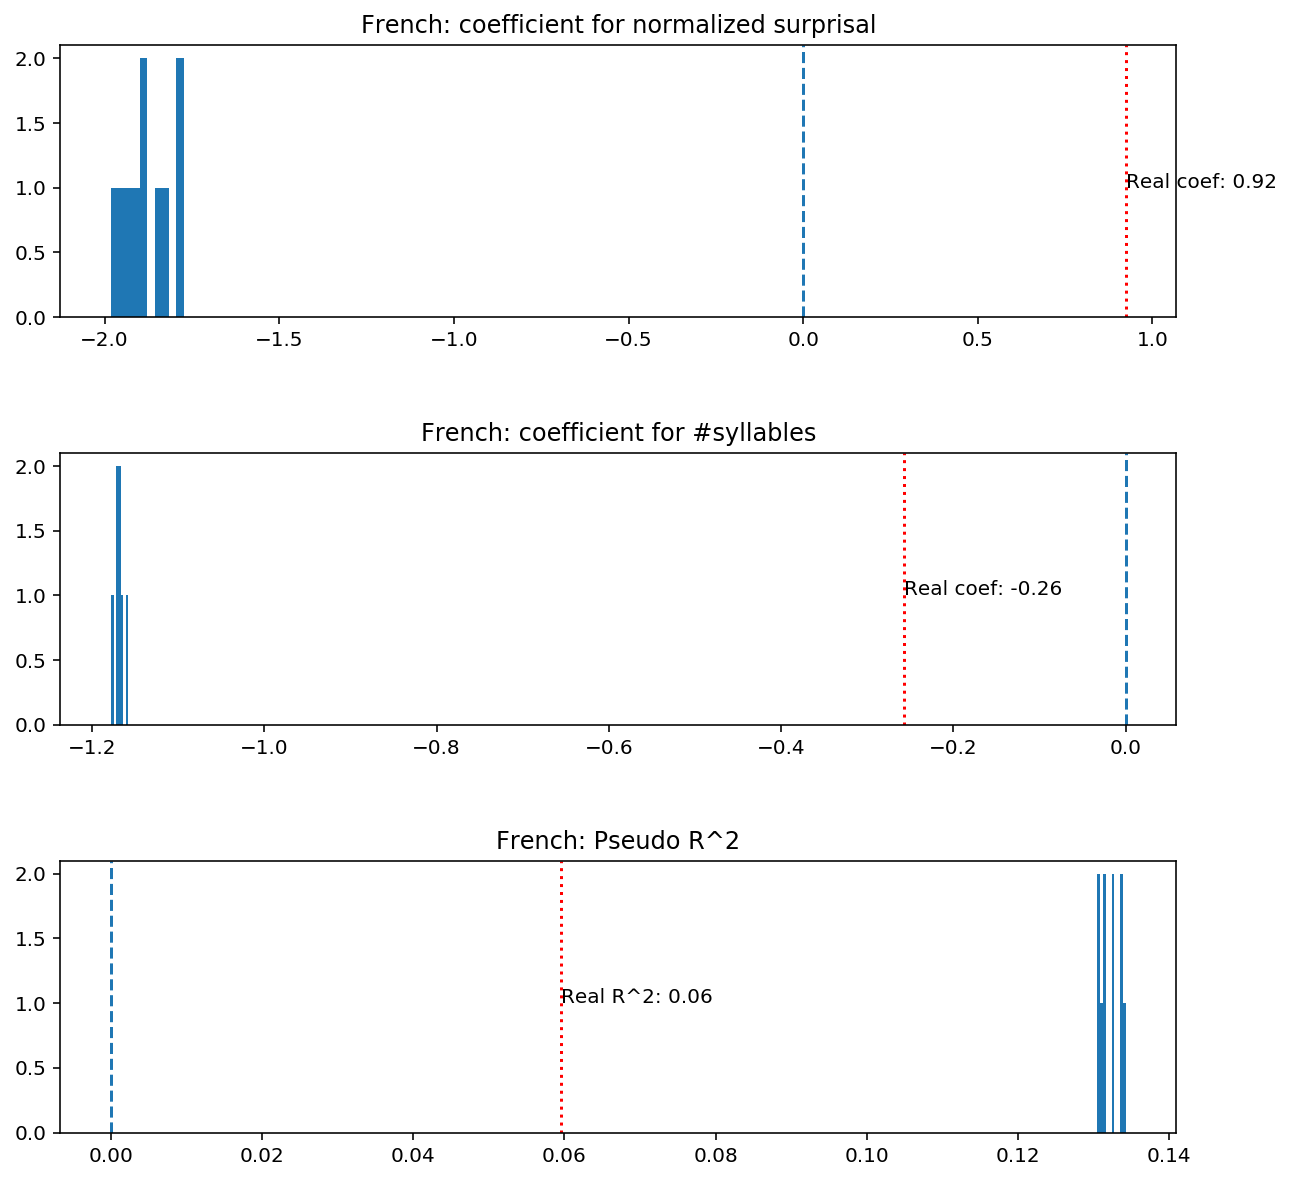

In [73]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

In [74]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
    'neighborhood_size'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized_surprisal', 
    '#syllables', 
    '#minimal pairs'
]
LANGUAGE = 'French'

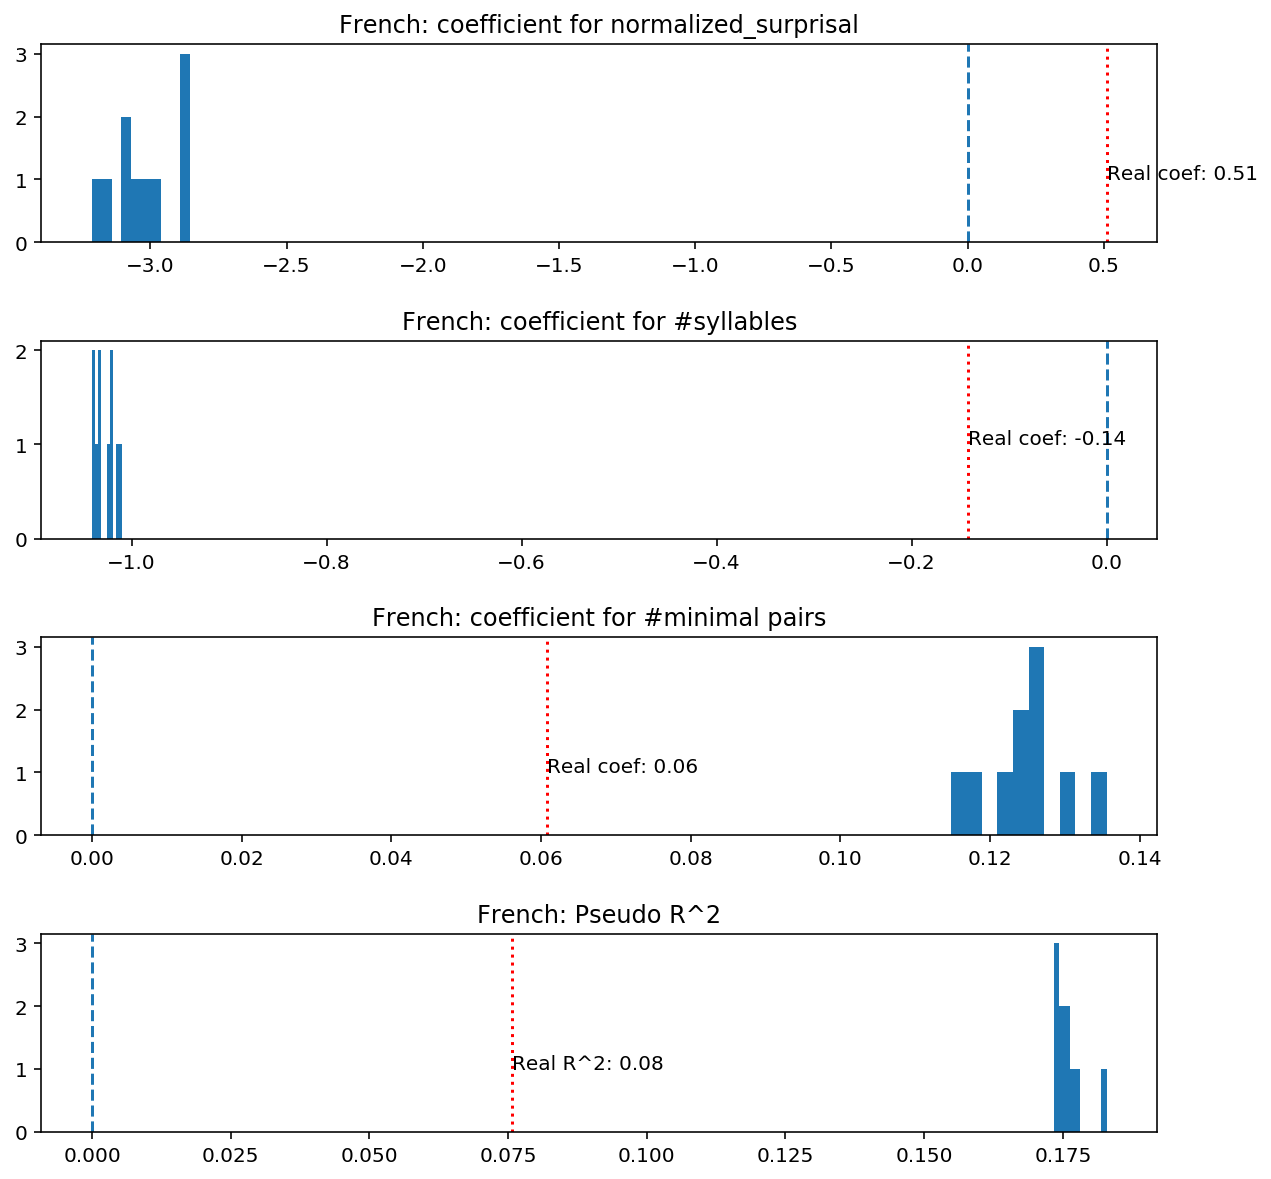

In [75]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

### Predicting neighborhood size from number of homophones

Do words with more homophones have larger neighborhoods?

This just takes the analysis above and inverts it:

```
neighborhood size ~ #homophones + #syllables + surprisal
```

Mostly consistent with the above analysis in English, we find:

- The effect of **surprisal** (predicting #minimal pairs) is larger in the real lexicon than in the artificial lexicon.
- The effect of **#syllables** is larger in the artificial than real lexicon (this is distinct from the analysis in English).
- The effect of **#homophones** is larger in the real lexicon than in the artificial lexicons.

#### Analysis

In [76]:
TARGET = 'neighborhood_size'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#syllables', 
]
LANGUAGE = 'French'

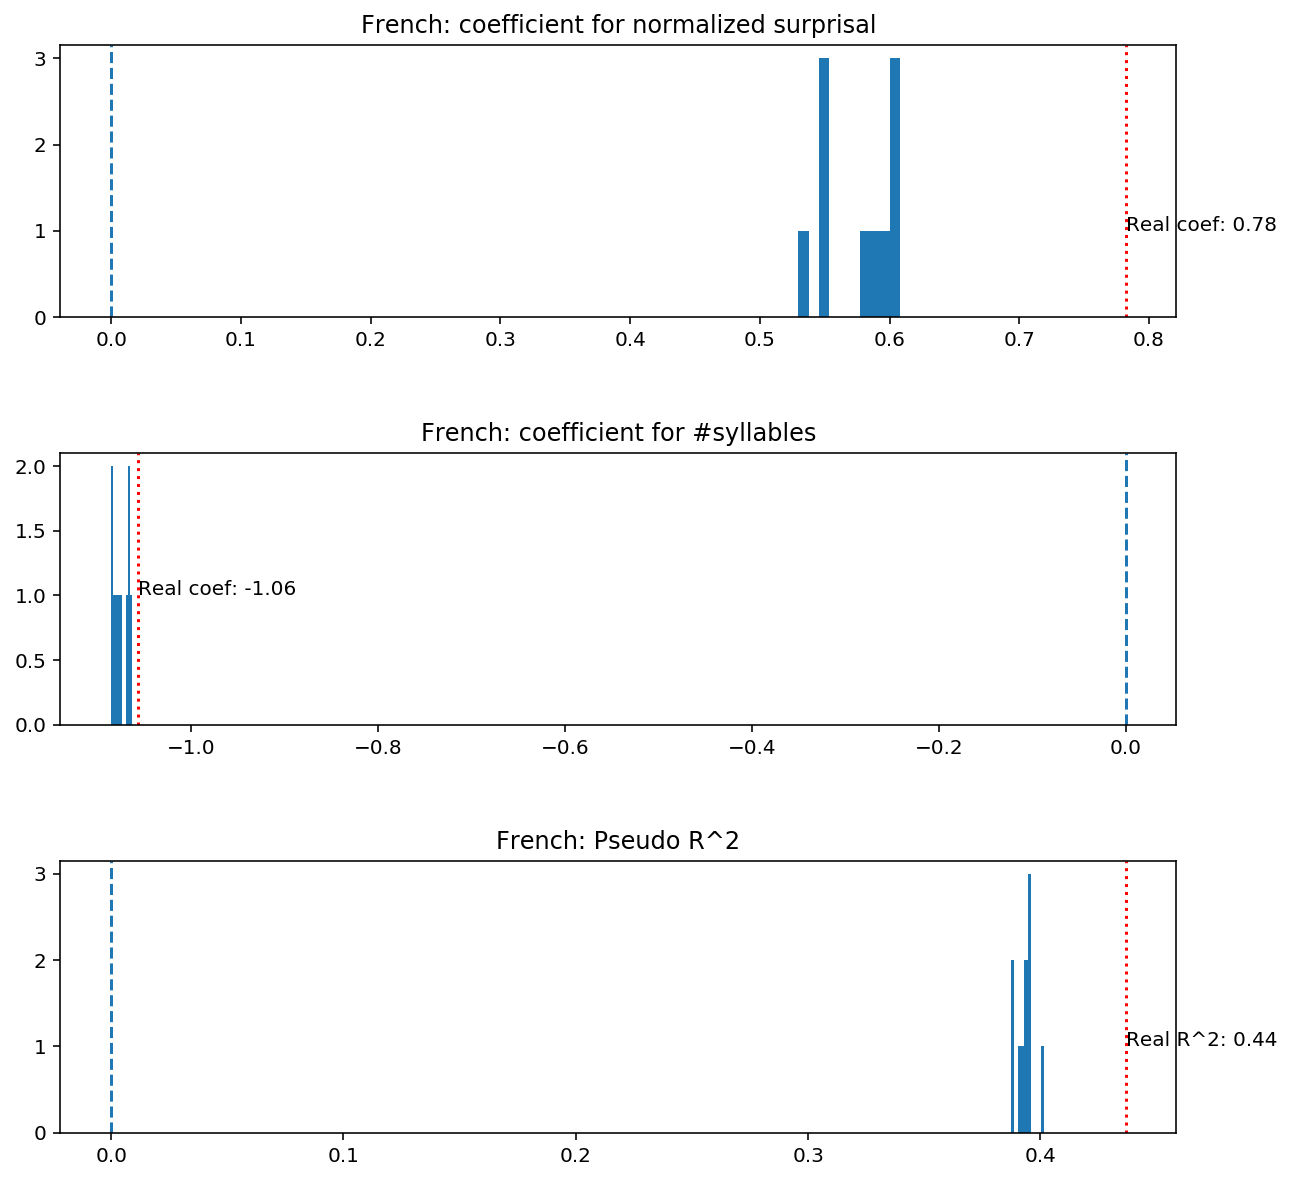

In [77]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

## Japanese

In [78]:
df_celex, df_celex_processed, df_japanese_artificials = load_lexicons_for_language("japanese", phon_column="phonetic_remapped",
                                                                                 word_column="orth_form_romaji")

In [79]:
len(df_celex)

51147

In [80]:
len(df_celex_processed)

40449

In [81]:
df_japanese_stats = get_stats_for_lexicon(df_celex_processed)
df_japanese_stats

{'homophone_percentage': 0.1506,
 'mean_homophones': 0.2645,
 'max_homophones': 33,
 'mean_mp': 3.9055,
 'max_mp': 43,
 'total_mp': 157972,
 'mean_mp_w_hp': 7.6132,
 'max_mp_w_hp': 273,
 'total_mp_w_hp': 307946}

### Preprocess artificials

In [82]:
info_for_japanese = process_and_extract_artificials(df_japanese_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


In [83]:
processed_artificials = info_for_japanese['processed_dataframes']

In [84]:
df_celex_processed['surprisal_normed'] = df_celex_processed['surprisal'] / df_celex_processed['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Visualizations

### `#homophones` ~ `rank_homophones`

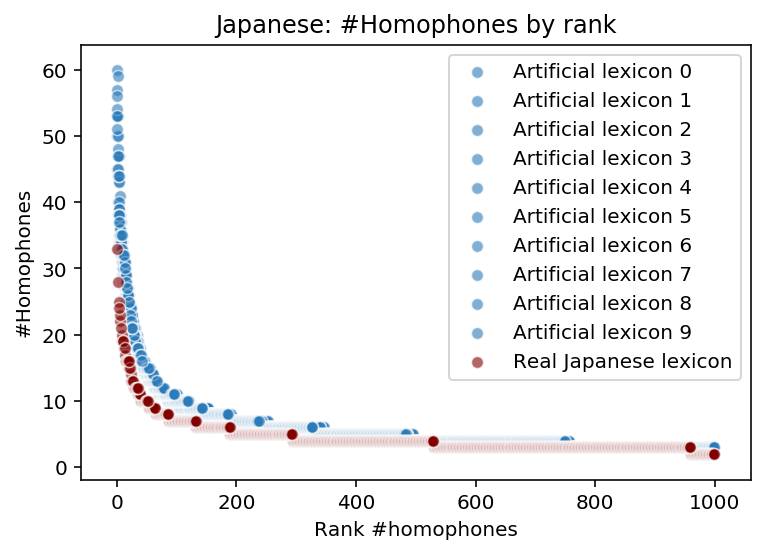

In [212]:
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    sns.scatterplot(data = df_tmp_art[df_tmp_art['rank_num']<1000],
                    x = "rank_num",
                    alpha = .6,
                    y = "num_homophones", 
                    color = sns.color_palette("Blues")[4], 
                    label = "Artificial lexicon {x}".format(x=index))

df_celex_processed['rank_num'] = df_celex_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "num_homophones", 
                color = "maroon",
                alpha = .6,
                label = "Real Japanese lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("Japanese: #Homophones by rank")

plt.savefig("Figures/japanese/data_visualizations/rank_homophones.png", dpi=300)

### `#minimal pairs` ~ `rank_minimal_pairs`

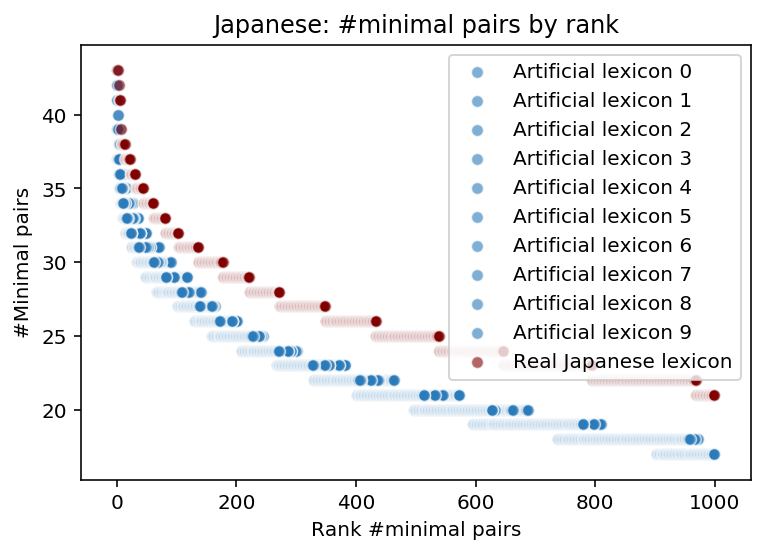

In [47]:
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_neighborhood'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    sns.scatterplot(data = df_tmp_art[df_tmp_art['rank_neighborhood']<1000],
                    x = "rank_neighborhood",
                    alpha = .6,
                    y = "neighborhood_size", 
                    color = sns.color_palette("Blues")[4], 
                    label = "Artificial lexicon {x}".format(x=index))

df_celex_processed['rank_neighborhood'] = df_celex_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_neighborhood']<1000],
               x = "rank_neighborhood",
               y = "neighborhood_size", 
                color = "maroon",
                alpha = .6,
                label = "Real Japanese lexicon")
plt.xlabel("Rank #minimal pairs")
plt.ylabel("#Minimal pairs")
plt.title("Japanese: #minimal pairs by rank")

plt.savefig("Figures/japanese/data_visualizations/rank_neighborhoods.png", dpi=300)


### Comparing neighborhood distributions (Dautriche et al, 2016)

As reported by Dautriche et al (2016), the real lexicon has higher average neighborhood sizes (and larger maximum neighborhoods) than the artificial lexicons.

Comparing the actual distributions, it seems like this is driven by the real lexicon having a longer, larger tail (consistent with the idea that there is a larger **maximum** neighborhood size in the real lexicon). 

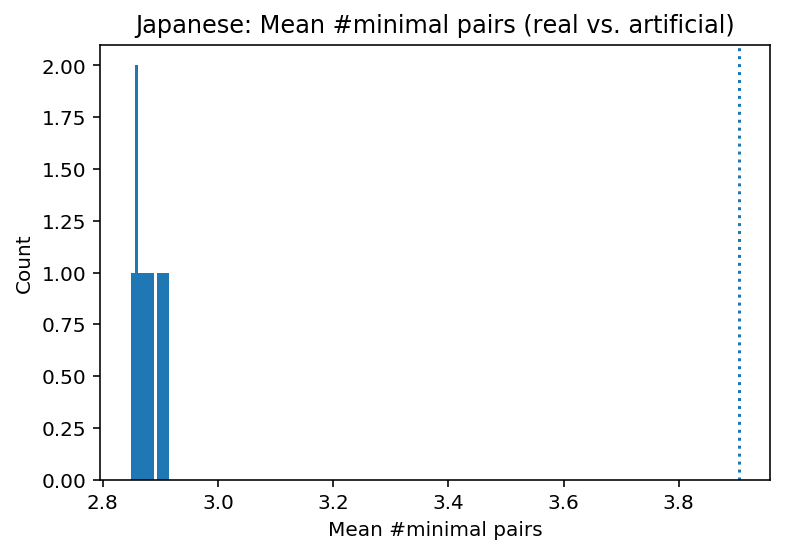

In [47]:
plot_real_vs_art(info_for_japanese['mean_mp'], df_japanese_stats['mean_mp'],
                'Mean #minimal pairs', language="Japanese")

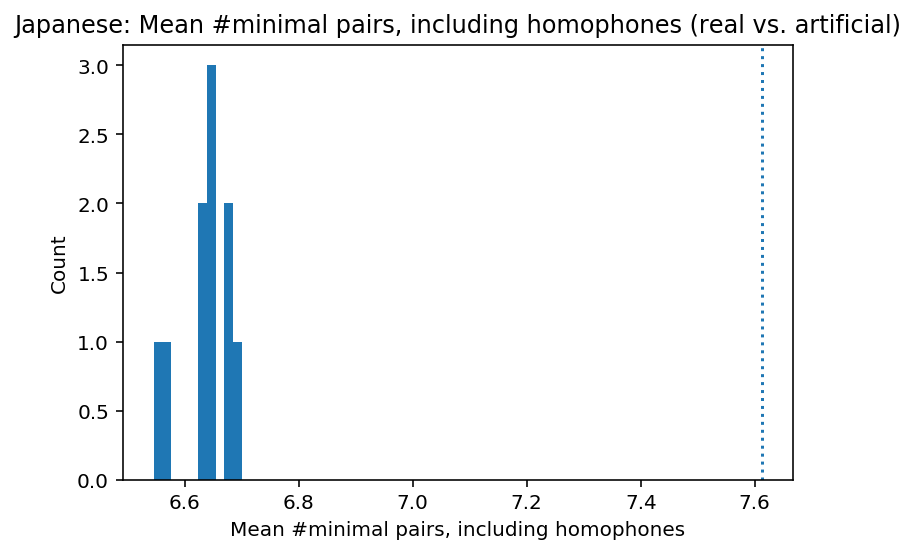

In [48]:
plot_real_vs_art(info_for_japanese['mean_mp_w_hp'], df_japanese_stats['mean_mp_w_hp'],
                'Mean #minimal pairs, including homophones', language="Japanese")

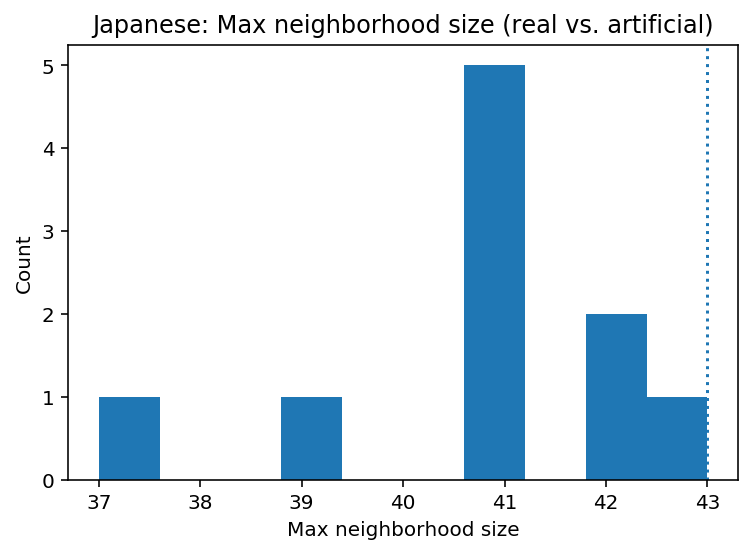

In [49]:
plot_real_vs_art(info_for_japanese['max_mp'], df_japanese_stats['max_mp'],
                'Max neighborhood size', language="Japanese")

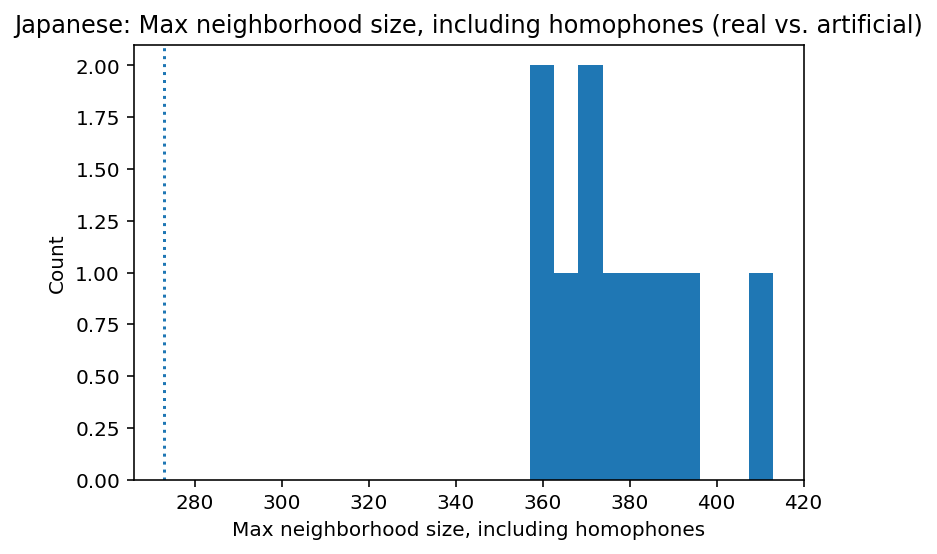

In [50]:
plot_real_vs_art(info_for_japanese['max_mp_w_hp'], df_japanese_stats['max_mp_w_hp'],
                'Max neighborhood size, including homophones', language="Japanese")

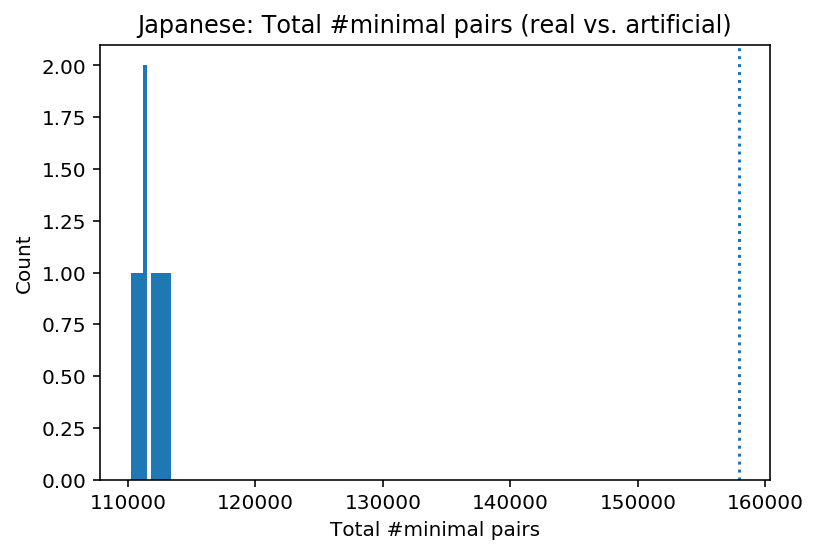

In [51]:
plot_real_vs_art(info_for_japanese['total_mp'], df_japanese_stats['total_mp'],
                'Total #minimal pairs', language='Japanese')

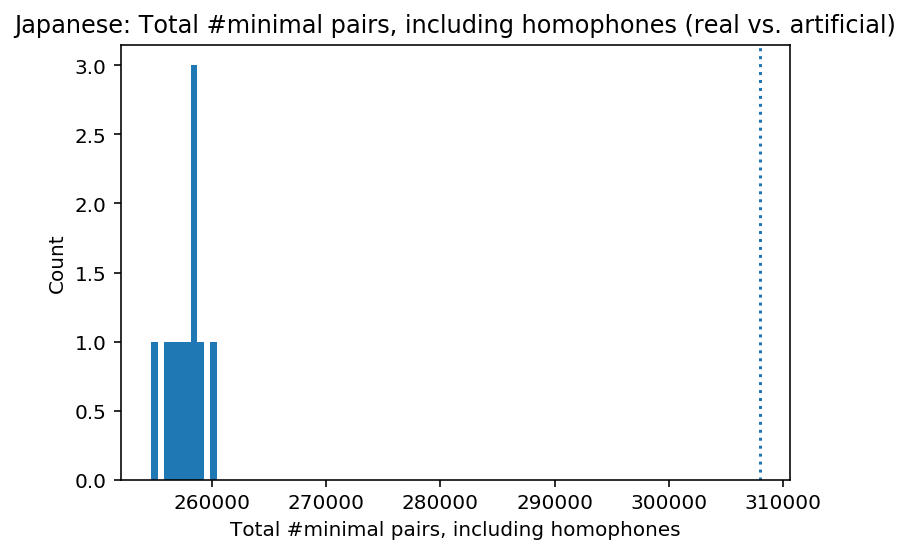

In [52]:
plot_real_vs_art(info_for_japanese['total_mp_w_hp'], df_japanese_stats['total_mp_w_hp'],
                'Total #minimal pairs, including homophones', language='Japanese')

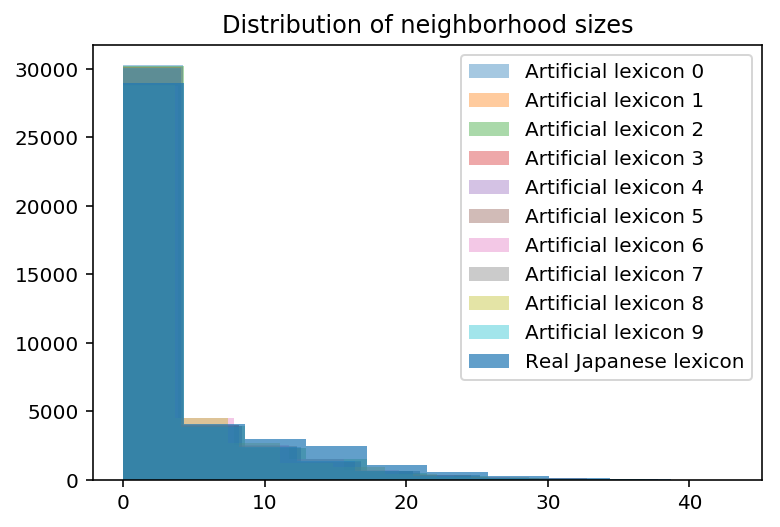

In [53]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size'], 
          alpha = .7, label = "Real Japanese lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes")
plt.legend()

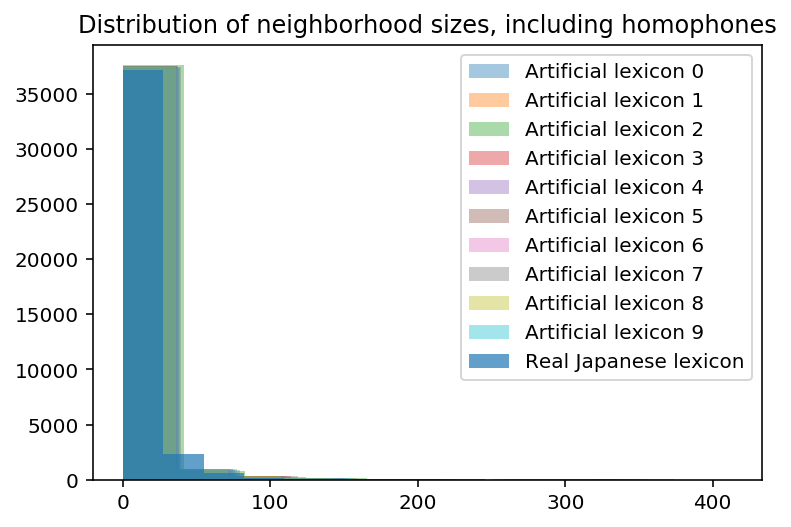

In [54]:
for i, df_tmp in enumerate(processed_artificials):
    plt.hist(df_tmp['neighborhood_size_with_homophones'], alpha = .4, label = "Artificial lexicon {x}".format(x=i))
plt.hist(df_celex_processed['neighborhood_size_with_homophones'], 
          alpha = .7, label = "Real Japanese lexicon".format(x=i))
plt.title("Distribution of neighborhood sizes, including homophones")
plt.legend()

### Comparing homophone distributions

See also: https://github.com/seantrott/homophone_simulations/blob/master/using_null_lexicons.ipynb

When it comes to **homophones**, however, the artificial lexicons have a higher number of *maximum* homophones per word (upwards of 100, in some cases) than the real lexicon (below ~30-40). There is also a higher number of *mean* homophones per word.

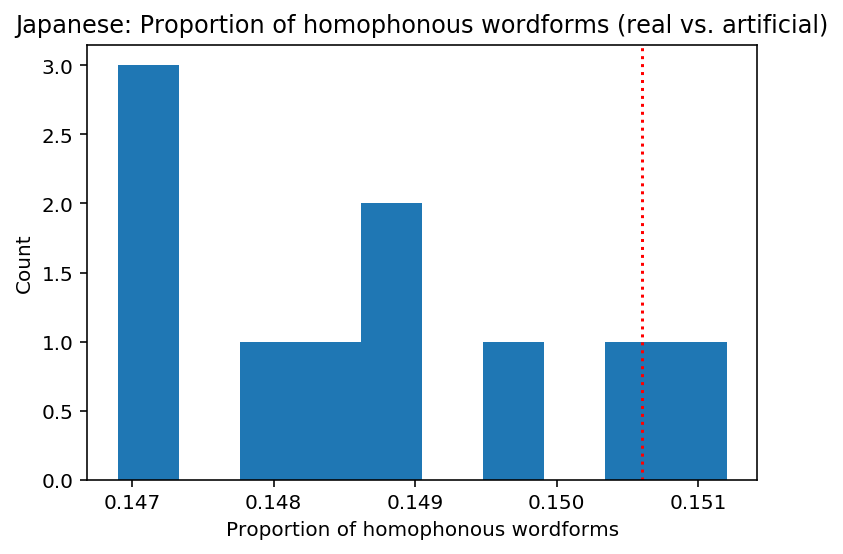

In [37]:
plot_real_vs_art(info_for_japanese['homophone_percentages'], df_japanese_stats['homophone_percentage'],
                'Proportion of homophonous wordforms', language='Japanese')
plt.savefig("Figures/japanese/japanese_%_homophones.png", dpi=300)

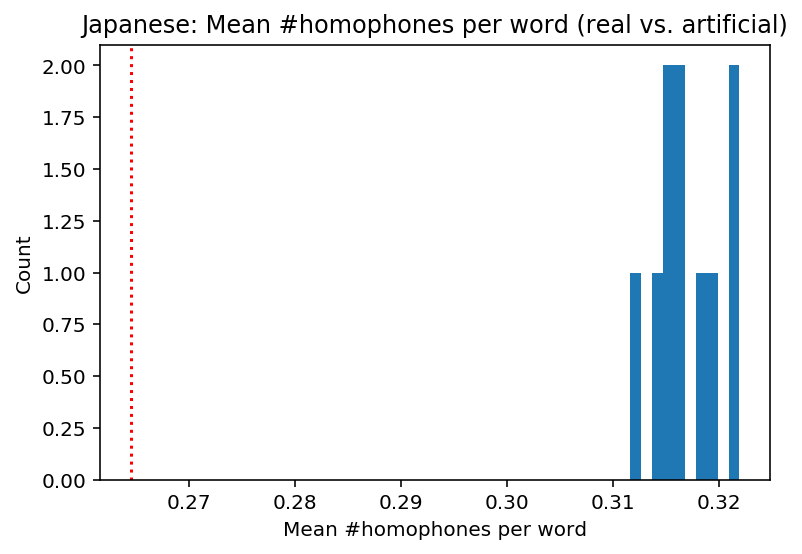

In [114]:
plot_real_vs_art(info_for_japanese['mean_homophones'], df_japanese_stats['mean_homophones'],
                'Mean #homophones per word', language='Japanese')
plt.savefig("Figures/japanese/japanese_mean_homophones.png", dpi=300)

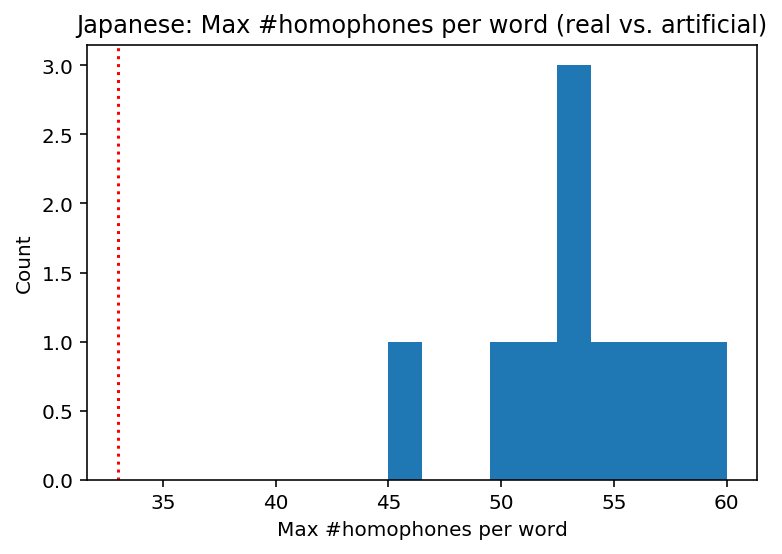

In [115]:
plot_real_vs_art(info_for_japanese['max_homophones'], df_japanese_stats['max_homophones'],
                'Max #homophones per word', language='Japanese')
plt.savefig("Figures/japanese/japanese_max_homophones.png", dpi=300)

## Statisical Analysis

### Predicting number of homophones

#### Analysis

In [85]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#syllables', 
]
LANGUAGE = 'Japanese'

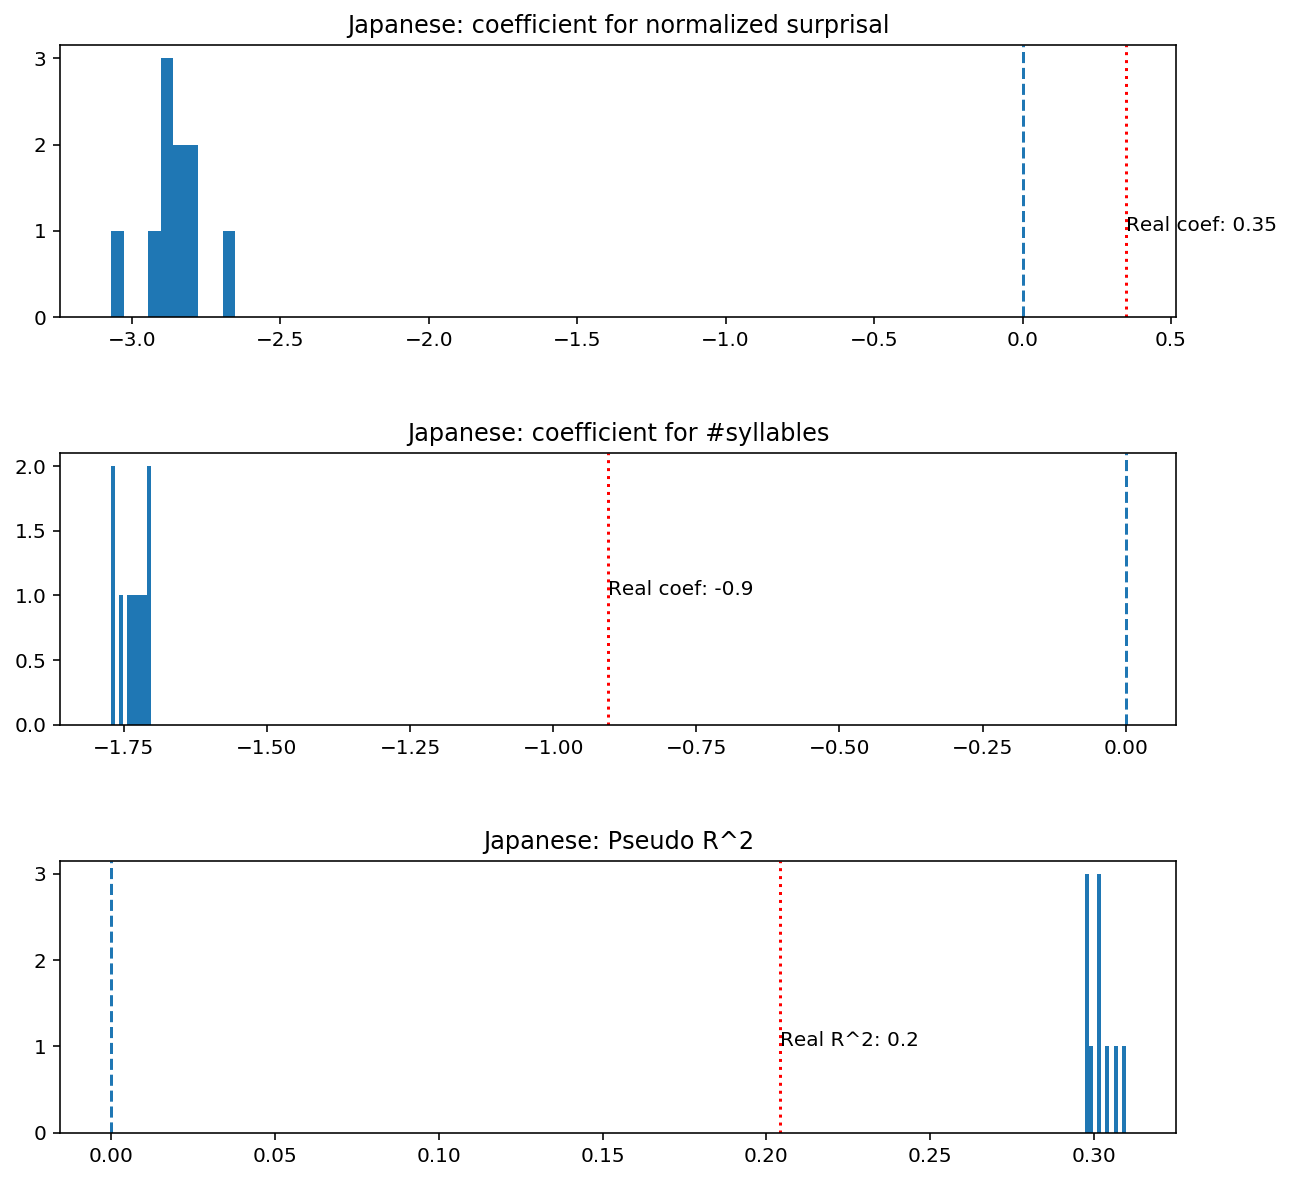

In [86]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

In [89]:
TARGET = 'num_homophones'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
    'neighborhood_size'
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#morae', 
    '#minimal pairs'
]
LANGUAGE = 'Japanese'

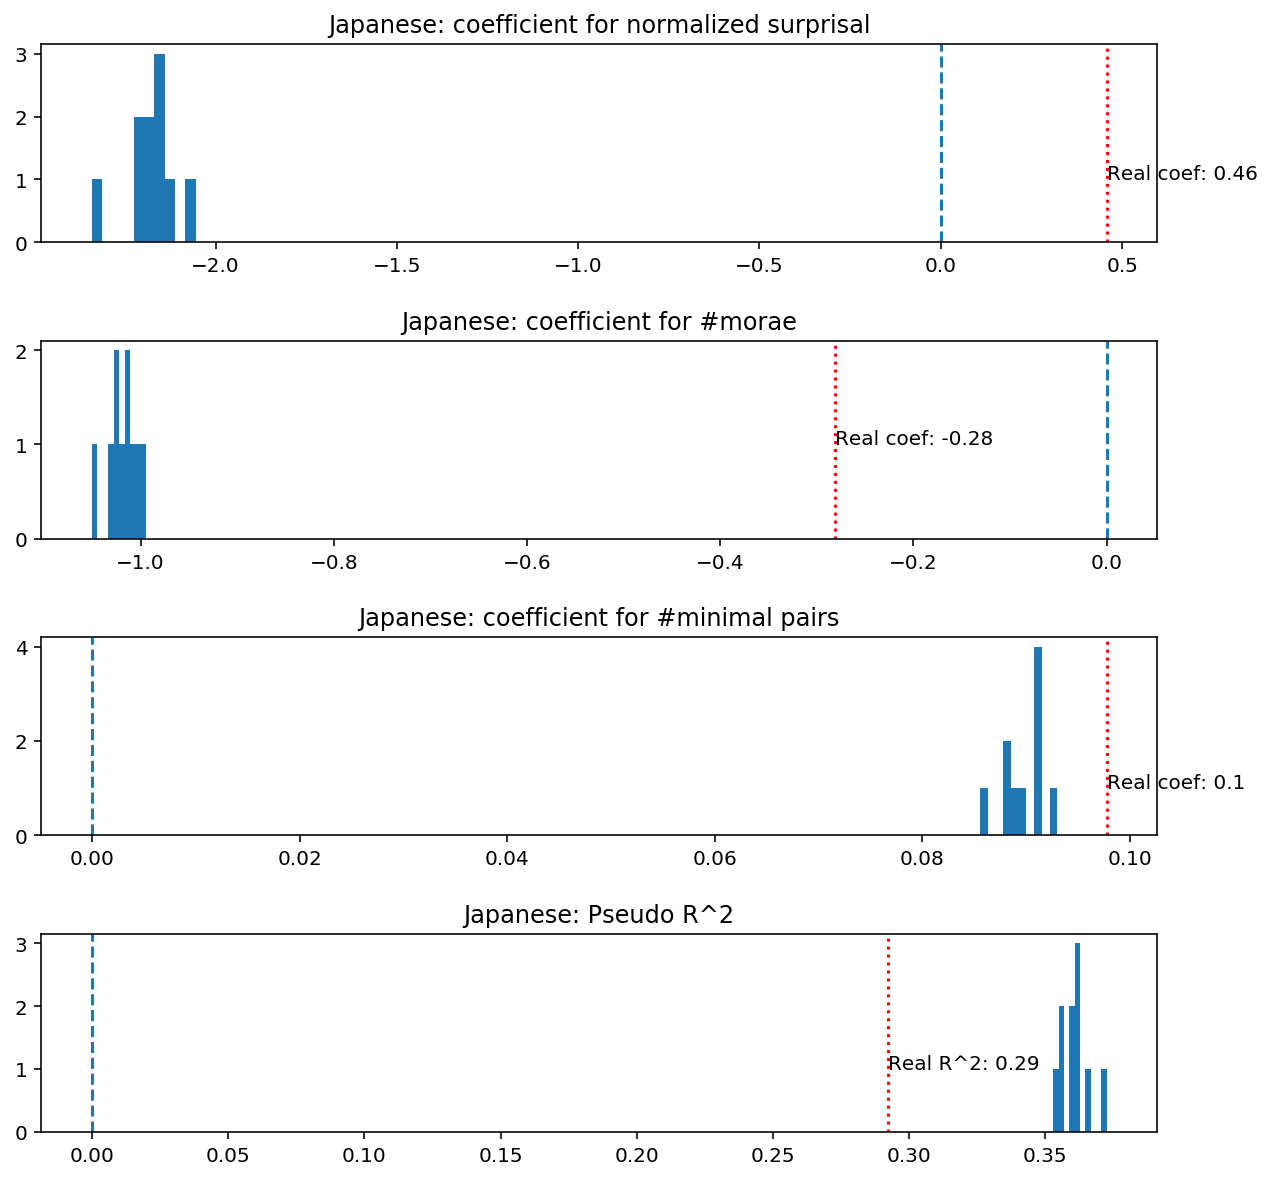

In [90]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

### Predicting neighborhood size

The effect of `surprisal` is larger in the **real** than **artificial** lexicons: the real Japanese lexicon appears to optimize neighborhoods more on the basis of surprisal than artificial lexicons.

The effect of `#morae` is smaller in the **real** than **artificial** lexicon: the artificial lexicons optimize neighborhoods more on the basis of word length than the real lexicon.

And the effect of `#homophones` is larger (in the expected direction) in the **real**  than the **artificial** lexicons: wordforms with more homophones also have larger neighborhoods. This isn't true in the artificial lexicon.

#### Analysis

In [91]:
TARGET = 'neighborhood_size'
COVARIATES = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA = '{y} ~ {regressors}'.format(y=TARGET, regressors=' + '.join(COVARIATES))

COVARIATE_LABELS = [
    'normalized surprisal', 
    '#morae', 
]
LANGUAGE = 'Japanese'

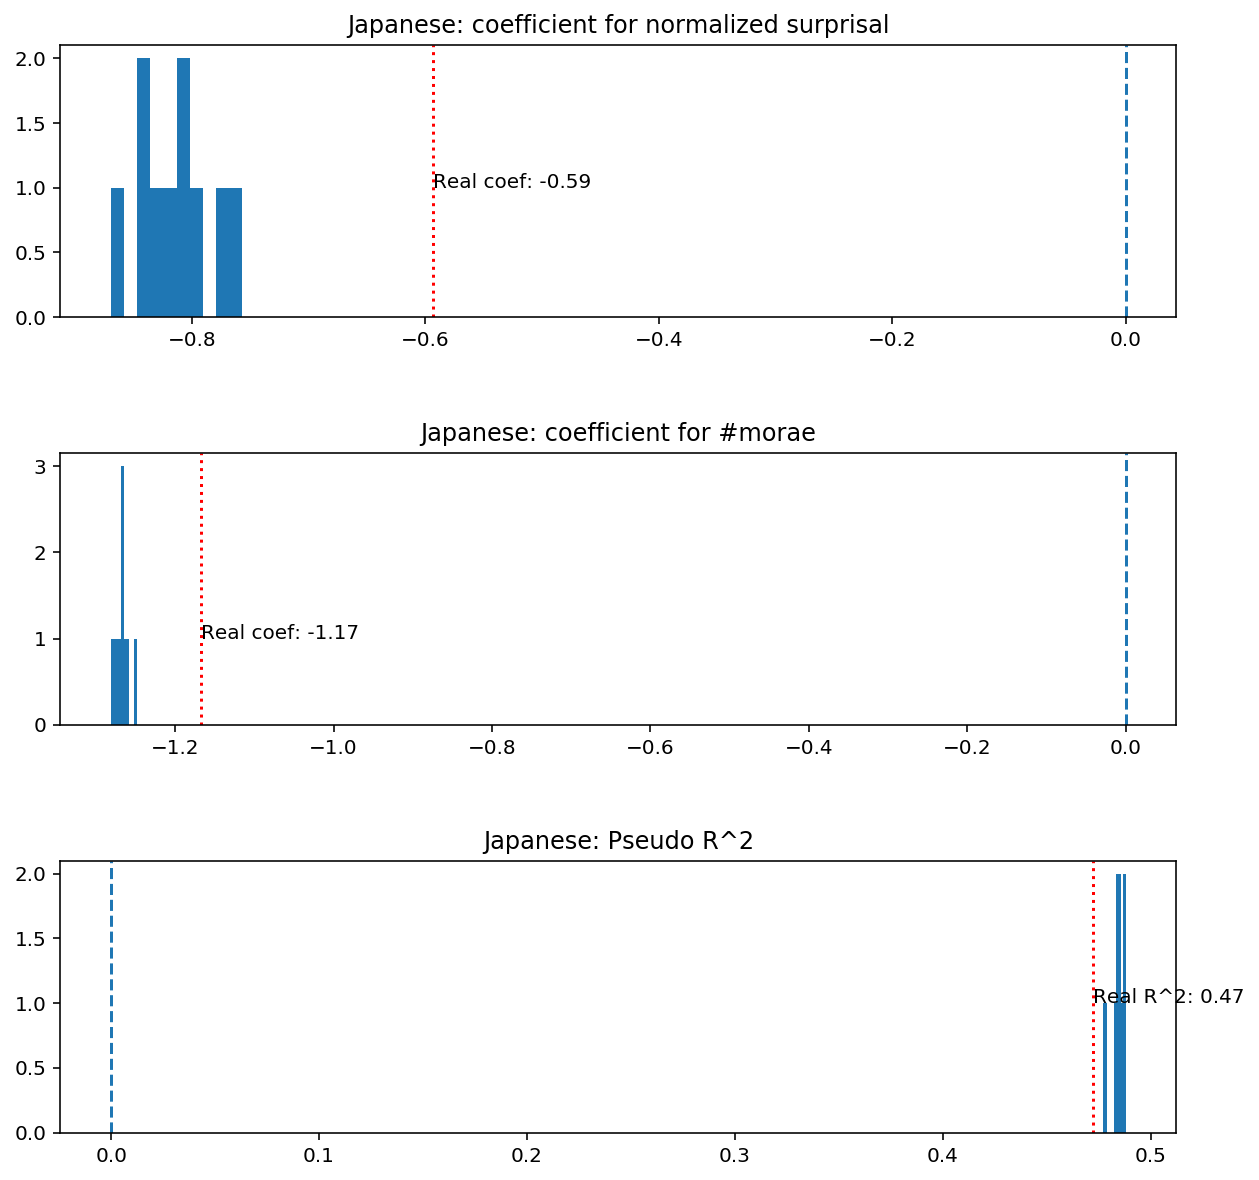

In [92]:
process_stats(df_celex_processed, processed_artificials, 
              formula=FORMULA, covariates=COVARIATES, 
              covariate_labels=COVARIATE_LABELS, language=LANGUAGE)
# plt.savefig("Figures/english/english_stats_results_homophones.png", dpi=300)

# Discussion

The central question in this analysis was whether the relationship between a word's **neighborhood size** and the **number of homophones** that this word has is larger in the real lexicon, or in artificial lexicons matched for length and phonotactic plausibility.

More broadly, we were interested in comparing distributional features of neighborhood sizes and homophony across these kinds of lexicons. 

Below, we discuss the results.
 

## Descriptive Results

### Neighborhood size

Consistent with [Dautriche et al (2016)](https://www.sciencedirect.com/science/article/pii/S0010027717300331), the real lexicons contained larger neighborhoods (e.g. more minimal pairs) overall. 

Words from the real lexicons had more minimal pairs on average, as well as a larger *maximum* number of minimal pairs, than words from the artificial lexicons. The only case in which this wasn't true was when neighborhood size was calculated *including* homophones; in these cases, maximum neighborhood size was larger for artificial, as opposed to real, lexicons. This is to be expected, considering that the artificial lexicons had a very high density of homophones overall.

In other words, the real lexicons are "clumpier" than the artificial lexicons. 

### Homophony

In all lexicons, artificial lexicons had a higher number of possible homophones *per word* than the real lexicon. The maximum number of homophones per word in English is ~7 (~4 in German, ~11 in French, ~5 in Dutch), whereas in the artificial lexicons, some wordforms enjoyed upwards of ~70 (~40 in German, ~150 in Dutch, ~60 in French) different entries.

The key difference across the 4 languages was that the artificial English lexicons had a *lower* proportion of homophonous wordforms than the real counterparts; whereas the German, French, and Dutch artificial lexicons had a *higher* proportion of homophonous wordforms than the real counterparts. The Japanese artificial lexicons had approximately the same proportion of homophonous wordforms as the real Japanese lexicon.

In other words, both artificial lexicons permitted more recycling of *particular* lexical items.

This raises the question: how are homophones **distributed** in the real vs. artificial lexicons?


## Results from Statistical Modeling

We also examined the relationship between **#homophones** of a word and its **phonotactic plausibility** (e.g. *surprisal*), **number of syllables/morae**, and its **neighborhood size**. 
